In [1]:
!pip3 install pybullet --upgrade --user

Requirement already up-to-date: pybullet in /Users/user/.local/lib/python3.7/site-packages (3.1.7)
You should consider upgrading via the '/Users/user/anaconda3/envs/pwil/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
import gym
import argparse
import os
import pickle
import numpy as np
import random
import torch.optim as optim
import torch_optimizer as th_optim
import pybullet_envs

from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal
from models import *
from utils import *
from dataset import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_bco(records, records2=None, env_name=None, s=100, off=0.8):
    ypoints = np.array(records)
    plt.plot(ypoints)
    if records2 is not None:
        ypoints = np.array(records2)
        plt.plot(ypoints, linestyle = 'dotted')
    else:
        ypoints[1:] = ypoints[1:] #- (np.random.rand(ypoints[1:].shape[0])-0.25)*2*s + (np.random.rand(ypoints[1:].shape[0])-off)*4*s
    plt.title(env_name)
    plt.xlabel('steps (10e3)')
    plt.ylabel('reward')
    plt.legend(["Forward matching", "BC from observation"], loc ="lower right")
    plt.show()

In [4]:
def inv_model_training(transitions, inv_model, ep_num=100):
    inv_dataset = transition_dataset(transitions)
    #inv_dataset_list.append(inv_dataset)
    #inv_dataset_final = ConcatDataset(inv_dataset_list)
    inv_loader = DataLoader(inv_dataset, batch_size=1024, shuffle=True, num_workers=4)

    #inv_opt = optim.Adam(inv_model.parameters(), lr=1e-3, weight_decay=0.0001)
    #"""
    inv_opt_yogi = th_optim.Yogi(
        inv_model.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    inv_opt = th_optim.Lookahead(inv_opt_yogi,  alpha=0.5)#k=5
    #"""
    inv_loss = nn.MSELoss()
    #inv_loss = nn.L1Loss()

    for epoch in range(ep_num): 
        running_loss = 0
        for i, data in enumerate(inv_loader):
            s, a, s_prime = data
            inv_opt.zero_grad()
            """
            a_pred = inv_model(s.float(), s_prime.float())
            """
            #print(s.shape, a.shape, s_prime.shape, torch.cat((s.float(), a.float()), dim=1).shape)
            try:
                inputs = torch.cat((s.float(), a.float()), dim=1)
                pred = inv_model.reparam_forward(inputs)
            except:
                sprime_m, sprime_v = inv_model(s.float(), a.float())
                pred = Normal(sprime_m, sprime_v).rsample()
            loss = inv_loss(pred, s_prime.float())
            #loss2 = inv_model.mdn_loss(inputs, s_prime.float())
            #loss = loss1 #+ loss2
            #loss = inv_loss(a_pred, a.float())
            loss.backward()
            running_loss += loss.item()
            if i%100 == 99:
                running_loss = 0
            inv_opt.step()
        if epoch%20==0:
            print('Epoch:%d Batch:%d Loss:%.5f'%(epoch, i+1, loss))
    print('Done!')
    return inv_model

def train_bc(trajs, policy, dynamics,  ep_num=50, sample_itr=500):
    enable_dropout(dynamics)
    
    bc_dataset = imitation_dataset(trajs)
    bc_loader = DataLoader(bc_dataset, batch_size=1024, shuffle=True, num_workers=4)
    print('Learning policy....')
    #bc_opt = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.0001)
    #"""
    bc_opt_yogi = th_optim.Yogi(
        policy.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    bc_opt = th_optim.Lookahead(bc_opt_yogi,  alpha=0.5)#k=5,
    #"""
    bc_loss = nn.MSELoss()
    # bc_loss = nn.L1Loss()

    for epoch in range(ep_num):  
        running_loss = 0
        for i, data in enumerate(bc_loader):
            s, s_prime = data
            bc_opt.zero_grad()
            
            #"""
            #a_pred = policy.reparam_forward(s.float())
            try:
                a_mu, a_sigma = policy(s.float())
                a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
            except:
                a_pred = policy.reparam_forward(s.float())
            #"""
            #print(torch.cat((s, a_pred), dim=1).shape)
            try:
                preds = dynamics.reparam_forward(torch.cat((s, a_pred), dim=1)) 
            except:
                d_m, d_v = dynamics(s, a_pred) 
                preds = Normal(d_m, d_v).rsample()
            loss = bc_loss(preds, s_prime)
            #print(loss, loss.shape, preds.shape, new_gts.shape)
            
            #for sid in range(sample_itr):
                #"""
                #a_mu, a_sigma = policy(s.float())
                #a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
                #"""
                #s_m, s_v = dynamics(s, a_pred) 
                #print(pred.shape, s.shape, s_prime.shape)
                #print(pred[0])
                #loss = loss + bc_loss(preds[sid], s_prime)
                
            running_loss += loss.item()
            loss.backward()
            if i%20 == 19:
                running_loss = 0
            bc_opt.step()
        if epoch%10==0:
            print('Epoch:%d Batch:%d Loss:%.3f'%(epoch, i+1, loss))

    print('Done!')
    return policy


def load_demos(DEMO_DIR):
    """load demonstrations"""
    try:
        trajstrajs = np.load("experts/states_expert_walker_.npy")[:10]
    except:
        with open(DEMO_DIR, 'rb') as f:
            trajs = pickle.load(f)
    demos = []
    for t_id, traj in enumerate(trajs):
        demo =[]
        #print(t_id)
        for item in traj:    
            obs = item['observation']
            #obs = list(obs)
            #print(obs)
            demo.append(obs)
        #print(np.array(demo).shape)
        demos.append(np.array(demo))

    print(np.array(demos).shape)
    demos = demos[:10]
    return demos

In [5]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]

runs = 20
inv_samples = 1000
max_steps = 800
expert_path='experts/'
weight_path="weights/"
        
test_rewards_envs = []
record_folder = "records/forward/"
init_seeds = [0,2,4,5]
itr_per_env = len(init_seeds)

for itr_id in range(itr_per_env):
    seed = init_seeds[itr_id]
    for en in env_list[1:]:
        print("############# start "+en+" training ###################")

        ENV_NAME = en#env_list[3]
        env=ENV_NAME
        
        DEMO_DIR = os.path.join(expert_path, env+'.pkl')
        M = inv_samples

        record_fn = record_folder + ENV_NAME + str(itr_id) + ".txt"

        """load demonstrations"""
        demos = load_demos(DEMO_DIR)

        """create environments"""
        env = gym.make(ENV_NAME)
        obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]

        """init random seeds for reproduction"""
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)

        """init models"""
        policy = policy_multinomial(env.observation_space.shape[0],64,env.action_space.shape[0], n_heads=15, do_rate=0.04)#.cuda()
        
        #policy = MDN(obs_dim, out_features=act_dim, n_hidden=64,  num_gaussians=3)
        #policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
        #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)
        inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
        #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
    
        inv_model_best = None
        reward_best = -1000

        inv_dataset_list = []
        use_policy = False

        transitions = []
        test_rewards = []
        for steps in range(runs):
            print('######## STEP %d #######'%(steps+1))
            ### GET SAMPLES FOR LEARNING INVERSE MODEL
            print('Collecting transitions for learning inverse model....')
            if steps > 0:
                use_policy = True


            trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
            transitions = transitions+trans_samples

            f = open(record_fn, "a+")
            f.write(str(avg_reward) + "\n")
            f.close()

            """
            if len(transitions) > 92000:
                transitions = random.sample(transitions,92000)
            """
            test_rewards.append(avg_reward)
            print('Done!', np.array(transitions).shape)

            ### LEARN THE INVERSE MODEL
            #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
            inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
            #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

            print('Learning inverse model....')
            inv_model = inv_model_training(transitions, inv_model,  ep_num=150)

            ### GET ACTIONS FOR DEMOS
            inv_model.cpu()
            print('Getting labels for demos....')
            trajs = get_state_labels(demos)
            print('Done!')


            ### PERFORM BEHAVIORAL CLONING
            policy = train_bc(trajs, policy, inv_model, ep_num=50)

        torch.save(policy, weight_path+ENV_NAME+str(itr_id)+'.pt')
        test_rewards_envs.append(test_rewards)

############# start BipedalWalker-v3 training ###################


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(49,)
######## STEP 1 #######


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reward: -103.19613867788638 setps: 100 count: 100
reward: -104.89378569665428 setps: 60 count: 160
reward: -102.36979020965472 setps: 111 count: 271
reward: -122.54565536505669 setps: 115 count: 386
avg rewards: -108.25134248731301
Done! (1000, 3)
Learning inverse model....


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/user/Documents/rl/practical_IL/state_prediction_rl/bco/BCO/dataset.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.x = np.array([s, a]).flatten()


Epoch:0 Batch:1 Loss:1.31611
Epoch:20 Batch:1 Loss:0.16875
Epoch:40 Batch:1 Loss:0.14042
Epoch:60 Batch:1 Loss:0.11249
Epoch:80 Batch:1 Loss:0.09480
Epoch:100 Batch:1 Loss:0.08098
Epoch:120 Batch:1 Loss:0.07282
Epoch:140 Batch:1 Loss:0.06927
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.128
Epoch:10 Batch:9 Loss:0.122
Epoch:20 Batch:9 Loss:0.111
Epoch:30 Batch:9 Loss:0.109
Epoch:40 Batch:9 Loss:0.103
Done!
######## STEP 2 #######
reward: -124.63664194877819 setps: 122 count: 122
reward: -33.652918032096075 setps: 800 count: 922
avg rewards: -79.14477999043713
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:1.25785
Epoch:20 Batch:2 Loss:0.10733
Epoch:40 Batch:2 Loss:0.08053
Epoch:60 Batch:2 Loss:0.06250
Epoch:80 Batch:2 Loss:0.05433
Epoch:100 Batch:2 Loss:0.05032
Epoch:120 Batch:2 Loss:0.04783
Epoch:140 Batch:2 Loss:0.04286
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.095
Epoch:10 Batch:9 Loss:0

Epoch:0 Batch:10 Loss:0.30300
Epoch:20 Batch:10 Loss:0.04971
Epoch:40 Batch:10 Loss:0.03900
Epoch:60 Batch:10 Loss:0.03442
Epoch:80 Batch:10 Loss:0.03213
Epoch:100 Batch:10 Loss:0.03129
Epoch:120 Batch:10 Loss:0.02885
Epoch:140 Batch:10 Loss:0.02896
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.058
Epoch:10 Batch:9 Loss:0.057
Epoch:20 Batch:9 Loss:0.056
Epoch:30 Batch:9 Loss:0.059
Epoch:40 Batch:9 Loss:0.058
Done!
######## STEP 11 #######
reward: -122.68223219709596 setps: 85 count: 85
reward: -111.11971743888905 setps: 48 count: 133
reward: -109.28898411481642 setps: 48 count: 181
reward: -119.69879151639435 setps: 69 count: 250
reward: -121.45125848980621 setps: 65 count: 315
reward: -120.40150232761727 setps: 63 count: 378
reward: -107.22516276257485 setps: 58 count: 436
reward: -120.75119744300035 setps: 64 count: 500
reward: -111.92170123736064 setps: 53 count: 553
reward: -119.11269642802824 setps: 104 count: 657
reward: -116.51405472230725 s

Epoch:140 Batch:19 Loss:0.02795
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.042
Epoch:10 Batch:9 Loss:0.046
Epoch:20 Batch:9 Loss:0.039
Epoch:30 Batch:9 Loss:0.043
Epoch:40 Batch:9 Loss:0.041
Done!
######## STEP 20 #######
reward: 174.0506602534159 setps: 800 count: 800
avg rewards: 174.0506602534159
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.15896
Epoch:20 Batch:20 Loss:0.04056
Epoch:40 Batch:20 Loss:0.03471
Epoch:60 Batch:20 Loss:0.03179
Epoch:80 Batch:20 Loss:0.03023
Epoch:100 Batch:20 Loss:0.02701
Epoch:120 Batch:20 Loss:0.02757
Epoch:140 Batch:20 Loss:0.02669
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.036
Epoch:10 Batch:9 Loss:0.034
Epoch:20 Batch:9 Loss:0.037
Epoch:30 Batch:9 Loss:0.037
Epoch:40 Batch:9 Loss:0.033
Done!
############# start Walker2DBulletEnv-v0 training ###################
(49, 1000, 22)


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


######## STEP 1 #######
reward: 13.612366641615518 setps: 9 count: 9
reward: 15.333661909894728 setps: 11 count: 20
reward: 14.06518672312959 setps: 10 count: 30
reward: 22.825537883289506 setps: 26 count: 56
reward: 20.030772349816107 setps: 20 count: 76
reward: 16.999050246212573 setps: 16 count: 92
reward: 15.545413191551052 setps: 14 count: 106
reward: 16.226392472333103 setps: 13 count: 119
reward: 14.878472657156816 setps: 18 count: 137
reward: 17.093303792305232 setps: 15 count: 152
reward: 25.38579114184395 setps: 28 count: 180
reward: 15.62311114539043 setps: 12 count: 192
reward: 25.67762851235602 setps: 21 count: 213
reward: 27.122905671574703 setps: 28 count: 241
reward: 16.43561664125446 setps: 12 count: 253
reward: 19.666378375614293 setps: 19 count: 272
reward: 13.895775478085852 setps: 9 count: 281
reward: 15.099087875016266 setps: 10 count: 291
reward: 17.484739339732915 setps: 15 count: 306
reward: 16.458311988427884 setps: 13 count: 319
reward: 24.631510851769416 set

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/user/Documents/rl/practical_IL/state_prediction_rl/bco/BCO/dataset.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.x = np.array([s, a]).flatten()


Epoch:0 Batch:1 Loss:1.32712
Epoch:20 Batch:1 Loss:0.12492
Epoch:40 Batch:1 Loss:0.09037
Epoch:60 Batch:1 Loss:0.06754
Epoch:80 Batch:1 Loss:0.05568
Epoch:100 Batch:1 Loss:0.05001
Epoch:120 Batch:1 Loss:0.04576
Epoch:140 Batch:1 Loss:0.04281
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.106
Epoch:10 Batch:10 Loss:0.107
Epoch:20 Batch:10 Loss:0.107
Epoch:30 Batch:10 Loss:0.104
Epoch:40 Batch:10 Loss:0.102
Done!
######## STEP 2 #######
reward: 375.9841329031508 setps: 800 count: 800
reward: 15.187196978322742 setps: 77 count: 877
reward: 30.422413327236427 setps: 117 count: 994
avg rewards: 140.53124773623665
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:1.21024
Epoch:20 Batch:2 Loss:0.07685
Epoch:40 Batch:2 Loss:0.04856
Epoch:60 Batch:2 Loss:0.03600
Epoch:80 Batch:2 Loss:0.03311
Epoch:100 Batch:2 Loss:0.02788
Epoch:120 Batch:2 Loss:0.02555
Epoch:140 Batch:2 Loss:0.02286
Done!
Getting labels for demos....
Done!
Learning policy....


Epoch:0 Batch:8 Loss:0.30544
Epoch:20 Batch:8 Loss:0.02345
Epoch:40 Batch:8 Loss:0.01611
Epoch:60 Batch:8 Loss:0.01280
Epoch:80 Batch:8 Loss:0.01202
Epoch:100 Batch:8 Loss:0.01137
Epoch:120 Batch:8 Loss:0.01130
Epoch:140 Batch:8 Loss:0.00916
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.066
Epoch:10 Batch:10 Loss:0.066
Epoch:20 Batch:10 Loss:0.066
Epoch:30 Batch:10 Loss:0.067
Epoch:40 Batch:10 Loss:0.065
Done!
######## STEP 9 #######
reward: 61.462925302129584 setps: 69 count: 69
reward: 23.84416537100478 setps: 58 count: 127
reward: 91.62902930819979 setps: 95 count: 222
reward: 97.82001563863449 setps: 107 count: 329
reward: 30.93459662456299 setps: 59 count: 388
reward: 160.37960956001697 setps: 182 count: 570
reward: 43.177038768735656 setps: 93 count: 663
reward: 44.71365358854094 setps: 81 count: 744
reward: 11.59284916643082 setps: 50 count: 794
reward: 45.62265938555937 setps: 76 count: 870
reward: 47.78354121338054 setps: 82 count: 952
av

Epoch:20 Batch:10 Loss:0.061
Epoch:30 Batch:10 Loss:0.061
Epoch:40 Batch:10 Loss:0.060
Done!
######## STEP 16 #######
reward: 359.54110234711425 setps: 533 count: 533
reward: 13.847522425389618 setps: 57 count: 590
reward: 37.139444489347824 setps: 98 count: 688
reward: 75.86657955641131 setps: 93 count: 781
reward: 20.43738431338715 setps: 69 count: 850
reward: 15.74871926790511 setps: 60 count: 910
reward: 24.954280404873135 setps: 70 count: 980
avg rewards: 78.21929040063262
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.07922
Epoch:20 Batch:16 Loss:0.01550
Epoch:40 Batch:16 Loss:0.01141
Epoch:60 Batch:16 Loss:0.00875
Epoch:80 Batch:16 Loss:0.00808
Epoch:100 Batch:16 Loss:0.00723
Epoch:120 Batch:16 Loss:0.00801
Epoch:140 Batch:16 Loss:0.00712
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.060
Epoch:10 Batch:10 Loss:0.057
Epoch:20 Batch:10 Loss:0.056
Epoch:30 Batch:10 Loss:0.057
Epoch:40 Batch:10 Loss:0.054
Done!
######## STE

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(49,)
######## STEP 1 #######
reward: 18.135717426698825 setps: 8 count: 8
reward: 20.31004078197002 setps: 10 count: 18
reward: 21.438978731670066 setps: 15 count: 33
reward: 17.765539309385346 setps: 9 count: 42
reward: 18.332904579787286 setps: 11 count: 53
reward: 21.875437221436005 setps: 19 count: 72
reward: 21.506266662621055 setps: 15 count: 87
reward: 19.376771460867893 setps: 11 count: 98
reward: 24.13838943464216 setps: 12 count: 110
reward: 20.692785486340288 setps: 17 count: 127
reward: 18.940834932563305 setps: 11 count: 138
reward: 21.166305673065654 setps: 14 count: 152
reward: 21.23852567662252 setps: 19 count: 171
reward: 21.796875095865108 setps: 11 count: 182
reward: 20.010833770128375 setps: 12 count: 194
reward: 20.04875340626022 setps: 10 count: 204
reward: 18.056655500577474 setps: 8 count: 212
reward: 17.39600966670987 setps: 7 count: 219
reward: 22.168040633604683 setps: 15 count: 234
reward: 22.489486426544318 setps: 12 count: 246
reward: 16.921681424420967 s

Epoch:40 Batch:10 Loss:0.083
Done!
######## STEP 4 #######
reward: 34.10366870642683 setps: 41 count: 41
reward: 30.60268456241174 setps: 40 count: 81
reward: 28.224104769995026 setps: 37 count: 118
reward: 29.027081444366193 setps: 40 count: 158
reward: 24.13212696707924 setps: 36 count: 194
reward: 27.69461887561265 setps: 38 count: 232
reward: 26.773687504997365 setps: 38 count: 270
reward: 23.203705432198326 setps: 36 count: 306
reward: 29.605055617273315 setps: 39 count: 345
reward: 25.758780352769822 setps: 36 count: 381
reward: 27.218632851462456 setps: 38 count: 419
reward: 25.520118226837074 setps: 38 count: 457
reward: 25.982585286711405 setps: 37 count: 494
reward: 25.260012251109583 setps: 36 count: 530
reward: 20.79731724492449 setps: 37 count: 567
reward: 27.542844370413516 setps: 36 count: 603
reward: 30.295848438261594 setps: 40 count: 643
reward: 29.309138647657157 setps: 38 count: 681
reward: 18.86012087092531 setps: 33 count: 714
reward: 42.55987871348917 setps: 47 c

reward: 27.206128163056565 setps: 14 count: 941
reward: 25.645772939454766 setps: 12 count: 953
reward: 27.632008303633487 setps: 12 count: 965
reward: 28.866916857195612 setps: 15 count: 980
reward: 27.876706530169752 setps: 12 count: 992
avg rewards: 28.9510901364717
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.65330
Epoch:20 Batch:7 Loss:0.03522
Epoch:40 Batch:7 Loss:0.02653
Epoch:60 Batch:7 Loss:0.02142
Epoch:80 Batch:7 Loss:0.02152
Epoch:100 Batch:7 Loss:0.01887
Epoch:120 Batch:7 Loss:0.01718
Epoch:140 Batch:7 Loss:0.01863
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.068
Epoch:10 Batch:10 Loss:0.064
Epoch:20 Batch:10 Loss:0.060
Epoch:30 Batch:10 Loss:0.063
Epoch:40 Batch:10 Loss:0.063
Done!
######## STEP 8 #######
reward: 59.22844533364987 setps: 58 count: 58
reward: 72.18104235279168 setps: 61 count: 119
reward: 126.38034946805419 setps: 99 count: 218
reward: 86.51796654081264 setps: 96 count: 314
reward: 47.59038945793

Epoch:140 Batch:11 Loss:0.01512
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.039
Epoch:10 Batch:10 Loss:0.038
Epoch:20 Batch:10 Loss:0.036
Epoch:30 Batch:10 Loss:0.035
Epoch:40 Batch:10 Loss:0.038
Done!
######## STEP 12 #######
reward: 22.12629497799644 setps: 40 count: 40
reward: 51.5639625120355 setps: 53 count: 93
reward: 48.293323174856766 setps: 48 count: 141
reward: 46.220223545530466 setps: 48 count: 189
reward: 67.47569622447922 setps: 102 count: 291
reward: 26.419209029055494 setps: 53 count: 344
reward: 52.49901693011632 setps: 55 count: 399
reward: 25.77930635802186 setps: 52 count: 451
reward: 66.81107949690052 setps: 71 count: 522
reward: 59.536189864210606 setps: 61 count: 583
reward: 22.101356912261686 setps: 45 count: 628
reward: 31.71263047886606 setps: 54 count: 682
reward: 20.33675849421416 setps: 40 count: 722
reward: 21.04849636676808 setps: 40 count: 762
reward: 19.778734688628177 setps: 39 count: 801
reward: 24.553651548988

avg rewards: 36.4078918806831
Done! (15000, 3)
Learning inverse model....
Epoch:0 Batch:15 Loss:0.14642
Epoch:20 Batch:15 Loss:0.02378
Epoch:40 Batch:15 Loss:0.01965
Epoch:60 Batch:15 Loss:0.01700
Epoch:80 Batch:15 Loss:0.01598
Epoch:100 Batch:15 Loss:0.01497
Epoch:120 Batch:15 Loss:0.01447
Epoch:140 Batch:15 Loss:0.01315
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.032
Epoch:10 Batch:10 Loss:0.029
Epoch:20 Batch:10 Loss:0.031
Epoch:30 Batch:10 Loss:0.031
Epoch:40 Batch:10 Loss:0.032
Done!
######## STEP 16 #######
reward: 36.864749989782275 setps: 29 count: 29
reward: 36.202753465338894 setps: 27 count: 56
reward: 36.52800329914899 setps: 29 count: 85
reward: 17.733720498539334 setps: 38 count: 123
reward: 28.994717618229338 setps: 32 count: 155
reward: 36.7287658391986 setps: 30 count: 185
reward: 19.893647136418444 setps: 36 count: 221
reward: 34.35647299890843 setps: 25 count: 246
reward: 17.601027609696022 setps: 33 count: 279
reward: 21.0430

reward: 31.07114233845059 setps: 28 count: 634
reward: 21.612283610014135 setps: 31 count: 665
reward: 36.53926947592552 setps: 30 count: 695
reward: 22.391397773679635 setps: 32 count: 727
reward: 33.490889530719144 setps: 34 count: 761
reward: 34.273674527059484 setps: 30 count: 791
reward: 37.38782394293811 setps: 33 count: 824
reward: 27.213183984313222 setps: 50 count: 874
reward: 15.054731536925832 setps: 41 count: 915
reward: 17.96840026828721 setps: 42 count: 957
reward: 38.899102530578965 setps: 34 count: 991
avg rewards: 27.79440100546042
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.10306
Epoch:20 Batch:20 Loss:0.02208
Epoch:40 Batch:20 Loss:0.01801
Epoch:60 Batch:20 Loss:0.01346
Epoch:80 Batch:20 Loss:0.01329
Epoch:100 Batch:20 Loss:0.01067
Epoch:120 Batch:20 Loss:0.01218
Epoch:140 Batch:20 Loss:0.01332
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.030
Epoch:10 Batch:10 Loss:0.030
Epoch:20 Batch:10 Loss:0.030
Epoc

Epoch:0 Batch:10 Loss:0.086
Epoch:10 Batch:10 Loss:0.086
Epoch:20 Batch:10 Loss:0.081
Epoch:30 Batch:10 Loss:0.083
Epoch:40 Batch:10 Loss:0.081
Done!
######## STEP 12 #######
reward: -1337.8664057871674 setps: 800 count: 800
avg rewards: -1337.8664057871674
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:12 Loss:0.33652
Epoch:20 Batch:12 Loss:0.03411
Epoch:40 Batch:12 Loss:0.02438
Epoch:60 Batch:12 Loss:0.02185
Epoch:80 Batch:12 Loss:0.02023
Epoch:100 Batch:12 Loss:0.01824
Epoch:120 Batch:12 Loss:0.01942
Epoch:140 Batch:12 Loss:0.01689
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.080
Epoch:10 Batch:10 Loss:0.079
Epoch:20 Batch:10 Loss:0.080
Epoch:30 Batch:10 Loss:0.076
Epoch:40 Batch:10 Loss:0.078
Done!
######## STEP 13 #######
reward: -1176.7620869666255 setps: 800 count: 800
avg rewards: -1176.7620869666255
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.32488
Epoch:20 Batch:13 Loss:0.03323
Epoch:40 Batch:13 Loss:0

Epoch:40 Batch:10 Loss:0.287
Done!
######## STEP 4 #######
reward: 278.5140764536555 setps: 800 count: 800
avg rewards: 278.5140764536555
Done! (4000, 3)
Learning inverse model....
Epoch:0 Batch:4 Loss:1.12942
Epoch:20 Batch:4 Loss:0.04047
Epoch:40 Batch:4 Loss:0.02362
Epoch:60 Batch:4 Loss:0.01803
Epoch:80 Batch:4 Loss:0.01630
Epoch:100 Batch:4 Loss:0.01455
Epoch:120 Batch:4 Loss:0.01279
Epoch:140 Batch:4 Loss:0.01259
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.266
Epoch:10 Batch:10 Loss:0.248
Epoch:20 Batch:10 Loss:0.249
Epoch:30 Batch:10 Loss:0.245
Epoch:40 Batch:10 Loss:0.245
Done!
######## STEP 5 #######
reward: 243.61326357557397 setps: 800 count: 800
avg rewards: 243.61326357557397
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:0.96386
Epoch:20 Batch:5 Loss:0.03574
Epoch:40 Batch:5 Loss:0.02352
Epoch:60 Batch:5 Loss:0.01839
Epoch:80 Batch:5 Loss:0.01516
Epoch:100 Batch:5 Loss:0.01310
Epoch:120 Batch:5 Loss:0.01284
Epoch:1

reward: 193.3222111081078 setps: 800 count: 800
avg rewards: 193.3222111081078
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.23091
Epoch:20 Batch:16 Loss:0.02100
Epoch:40 Batch:16 Loss:0.01486
Epoch:60 Batch:16 Loss:0.01448
Epoch:80 Batch:16 Loss:0.01172
Epoch:100 Batch:16 Loss:0.01156
Epoch:120 Batch:16 Loss:0.01052
Epoch:140 Batch:16 Loss:0.01104
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.088
Epoch:10 Batch:10 Loss:0.087
Epoch:20 Batch:10 Loss:0.088
Epoch:30 Batch:10 Loss:0.086
Epoch:40 Batch:10 Loss:0.088
Done!
######## STEP 17 #######
reward: -116.96557782948513 setps: 800 count: 800
avg rewards: -116.96557782948513
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.23553
Epoch:20 Batch:17 Loss:0.02125
Epoch:40 Batch:17 Loss:0.01579
Epoch:60 Batch:17 Loss:0.01374
Epoch:80 Batch:17 Loss:0.01277
Epoch:100 Batch:17 Loss:0.01170
Epoch:120 Batch:17 Loss:0.01166
Epoch:140 Batch:17 Loss:0.00959
Done!
Getting 

reward: 13.668143959355074 setps: 17 count: 809
reward: 19.79312948161387 setps: 21 count: 830
reward: 19.19280487193755 setps: 21 count: 851
reward: 14.112841390646642 setps: 17 count: 868
reward: 24.346062154811808 setps: 22 count: 890
reward: 21.833997327132966 setps: 23 count: 913
reward: 19.401853882485007 setps: 20 count: 933
reward: 21.598215678443378 setps: 21 count: 954
reward: 21.8644707813728 setps: 21 count: 975
reward: 20.714926219214977 setps: 22 count: 997
avg rewards: 19.85982326096276
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:1.43903
Epoch:20 Batch:2 Loss:0.32208
Epoch:40 Batch:2 Loss:0.25177
Epoch:60 Batch:2 Loss:0.22149
Epoch:80 Batch:2 Loss:0.18287
Epoch:100 Batch:2 Loss:0.16493
Epoch:120 Batch:2 Loss:0.15810
Epoch:140 Batch:2 Loss:0.14049
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.218
Epoch:10 Batch:8 Loss:0.216
Epoch:20 Batch:8 Loss:0.217
Epoch:30 Batch:8 Loss:0.216
Epoch:40 Batch:8 Loss:0.215
Done!
##

reward: 37.51761364810809 setps: 26 count: 701
reward: 19.72883065846836 setps: 17 count: 718
reward: 32.247530641993215 setps: 26 count: 744
reward: 34.95919872420638 setps: 24 count: 768
reward: 49.121387256037266 setps: 32 count: 800
reward: 49.61701068910915 setps: 36 count: 836
reward: 36.56255509494513 setps: 29 count: 865
reward: 42.0771372215575 setps: 30 count: 895
reward: 34.002358836015624 setps: 25 count: 920
reward: 34.13383551342995 setps: 27 count: 947
reward: 38.62783202327555 setps: 28 count: 975
reward: 18.36596733979532 setps: 18 count: 993
avg rewards: 38.40090205284909
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:1.12779
Epoch:20 Batch:6 Loss:0.15912
Epoch:40 Batch:6 Loss:0.11896
Epoch:60 Batch:6 Loss:0.10000
Epoch:80 Batch:6 Loss:0.08974
Epoch:100 Batch:6 Loss:0.08374
Epoch:120 Batch:6 Loss:0.08414
Epoch:140 Batch:6 Loss:0.08243
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.140
Epoch:10 Batch:8 Loss:0.138
Ep

Epoch:0 Batch:10 Loss:0.63320
Epoch:20 Batch:10 Loss:0.12161
Epoch:40 Batch:10 Loss:0.09343
Epoch:60 Batch:10 Loss:0.07567
Epoch:80 Batch:10 Loss:0.06947
Epoch:100 Batch:10 Loss:0.06280
Epoch:120 Batch:10 Loss:0.06683
Epoch:140 Batch:10 Loss:0.06243
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.103
Epoch:10 Batch:8 Loss:0.101
Epoch:20 Batch:8 Loss:0.101
Epoch:30 Batch:8 Loss:0.098
Epoch:40 Batch:8 Loss:0.100
Done!
######## STEP 11 #######
reward: 42.14768606287689 setps: 34 count: 34
reward: 34.36164792709897 setps: 29 count: 63
reward: 41.15897121769086 setps: 32 count: 95
reward: 14.990559335044235 setps: 17 count: 112
reward: 34.04053708772553 setps: 30 count: 142
reward: 35.98779635903193 setps: 30 count: 172
reward: 31.507680355424235 setps: 30 count: 202
reward: 17.76816448699683 setps: 18 count: 220
reward: 48.01136760575463 setps: 34 count: 254
reward: 34.28013770643156 setps: 32 count: 286
reward: 38.48846896024042 setps: 32 count: 318
rew

Epoch:30 Batch:8 Loss:0.089
Epoch:40 Batch:8 Loss:0.088
Done!
######## STEP 15 #######
reward: 36.04423027804005 setps: 26 count: 26
reward: 40.17718759348062 setps: 26 count: 52
reward: 40.056401566200655 setps: 27 count: 79
reward: 36.168443385821604 setps: 25 count: 104
reward: 41.775525397155434 setps: 27 count: 131
reward: 42.23912244664243 setps: 27 count: 158
reward: 28.54770794949873 setps: 26 count: 184
reward: 37.336272363932224 setps: 25 count: 209
reward: 44.088028807831876 setps: 28 count: 237
reward: 35.20604817940477 setps: 25 count: 262
reward: 35.35436104225955 setps: 24 count: 286
reward: 43.65671684314731 setps: 27 count: 313
reward: 23.074518622344478 setps: 20 count: 333
reward: 41.90990983849042 setps: 27 count: 360
reward: 24.660453410209445 setps: 21 count: 381
reward: 43.635281738196504 setps: 27 count: 408
reward: 34.648159228579615 setps: 25 count: 433
reward: 44.14072391959199 setps: 28 count: 461
reward: 36.771475611870116 setps: 24 count: 485
reward: 16.65

Epoch:20 Batch:8 Loss:0.076
Epoch:30 Batch:8 Loss:0.077
Epoch:40 Batch:8 Loss:0.077
Done!
######## STEP 19 #######
reward: 38.94994538587053 setps: 33 count: 33
reward: 42.483784535048464 setps: 34 count: 67
reward: 34.147274268911865 setps: 29 count: 96
reward: 40.63034617276716 setps: 40 count: 136
reward: 60.53061731625056 setps: 43 count: 179
reward: 35.99912075674802 setps: 29 count: 208
reward: 43.625096549853325 setps: 35 count: 243
reward: 36.9765174383967 setps: 36 count: 279
reward: 36.795836533819966 setps: 33 count: 312
reward: 13.450480507689644 setps: 18 count: 330
reward: 21.455471499303535 setps: 21 count: 351
reward: 66.88324312719486 setps: 47 count: 398
reward: 57.92258805577004 setps: 45 count: 443
reward: 53.037956457542876 setps: 42 count: 485
reward: 36.18043295823008 setps: 31 count: 516
reward: 32.30346769514436 setps: 29 count: 545
reward: 41.217652244259064 setps: 32 count: 577
reward: 23.021581990507546 setps: 21 count: 598
reward: 18.796532691361787 setps: 

Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.071
Epoch:10 Batch:9 Loss:0.065
Epoch:20 Batch:9 Loss:0.067
Epoch:30 Batch:9 Loss:0.065
Epoch:40 Batch:9 Loss:0.066
Done!
######## STEP 5 #######
reward: -36.44701844064366 setps: 800 count: 800
reward: -119.98286327225591 setps: 69 count: 869
reward: -106.89704945200744 setps: 46 count: 915
reward: -107.6378281761681 setps: 48 count: 963
avg rewards: -92.74118983526878
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:0.86200
Epoch:20 Batch:5 Loss:0.06552
Epoch:40 Batch:5 Loss:0.04775
Epoch:60 Batch:5 Loss:0.04086
Epoch:80 Batch:5 Loss:0.03693
Epoch:100 Batch:5 Loss:0.03410
Epoch:120 Batch:5 Loss:0.03421
Epoch:140 Batch:5 Loss:0.03122
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.068
Epoch:10 Batch:9 Loss:0.065
Epoch:20 Batch:9 Loss:0.062
Epoch:30 Batch:9 Loss:0.062
Epoch:40 Batch:9 Loss:0.061
Done!
######## STEP 6 #######
reward: -40.681655464279416 

reward: -9.764031865647688 setps: 800 count: 800
reward: -93.1641074767361 setps: 133 count: 933
reward: -114.10362920261423 setps: 62 count: 995
avg rewards: -72.34392284833267
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.22822
Epoch:20 Batch:13 Loss:0.04909
Epoch:40 Batch:13 Loss:0.03729
Epoch:60 Batch:13 Loss:0.03614
Epoch:80 Batch:13 Loss:0.03492
Epoch:100 Batch:13 Loss:0.03012
Epoch:120 Batch:13 Loss:0.02971
Epoch:140 Batch:13 Loss:0.02760
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.056
Epoch:10 Batch:9 Loss:0.051
Epoch:20 Batch:9 Loss:0.050
Epoch:30 Batch:9 Loss:0.053
Epoch:40 Batch:9 Loss:0.049
Done!
######## STEP 14 #######
reward: -24.15470471581259 setps: 800 count: 800
reward: -108.61216019980424 setps: 98 count: 898
avg rewards: -66.38343245780841
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.21164
Epoch:20 Batch:14 Loss:0.04442
Epoch:40 Batch:14 Loss:0.03731
Epoch:60 Batch:14 Loss:0.03439


reward: 15.08075326136459 setps: 12 count: 838
reward: 14.631682121122138 setps: 15 count: 853
reward: 15.342971074323579 setps: 10 count: 863
reward: 19.34638860751002 setps: 19 count: 882
reward: 18.63123921203369 setps: 17 count: 899
reward: 20.79012041430105 setps: 22 count: 921
reward: 17.032250068732537 setps: 11 count: 932
reward: 19.22291105356126 setps: 17 count: 949
reward: 15.178495415404905 setps: 13 count: 962
reward: 22.368147764010065 setps: 21 count: 983
reward: 17.395201157190606 setps: 14 count: 997
avg rewards: 18.095603291519186
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:1.28251
Epoch:20 Batch:1 Loss:0.12761
Epoch:40 Batch:1 Loss:0.10130
Epoch:60 Batch:1 Loss:0.07531
Epoch:80 Batch:1 Loss:0.06139
Epoch:100 Batch:1 Loss:0.05394
Epoch:120 Batch:1 Loss:0.05007
Epoch:140 Batch:1 Loss:0.04643
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.115
Epoch:10 Batch:10 Loss:0.105
Epoch:20 Batch:10 Loss:0.093
Epoch:30 Batc

Epoch:20 Batch:10 Loss:0.076
Epoch:30 Batch:10 Loss:0.075
Epoch:40 Batch:10 Loss:0.075
Done!
######## STEP 10 #######
reward: 57.457991392933764 setps: 73 count: 73
reward: 100.36591604285059 setps: 131 count: 204
reward: 36.161728888659844 setps: 69 count: 273
reward: 41.27151691388134 setps: 47 count: 320
reward: 106.00181187886632 setps: 123 count: 443
reward: 35.896222610691616 setps: 74 count: 517
reward: 39.84094329529326 setps: 47 count: 564
reward: 71.53453461282044 setps: 89 count: 653
reward: 46.026991726899 setps: 48 count: 701
reward: 38.481296117564504 setps: 71 count: 772
reward: 100.25753630020044 setps: 125 count: 897
reward: 76.31049384304931 setps: 91 count: 988
avg rewards: 62.467248635309204
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.24905
Epoch:20 Batch:10 Loss:0.01917
Epoch:40 Batch:10 Loss:0.01291
Epoch:60 Batch:10 Loss:0.01131
Epoch:80 Batch:10 Loss:0.01036
Epoch:100 Batch:10 Loss:0.00910
Epoch:120 Batch:10 Loss:0.00884
Epoch:140 Batch:1

Epoch:40 Batch:10 Loss:0.067
Done!
######## STEP 14 #######
reward: 26.448595700884482 setps: 51 count: 51
reward: 60.693763136345666 setps: 120 count: 171
reward: 18.248539722221913 setps: 59 count: 230
reward: 47.808321948982474 setps: 98 count: 328
avg rewards: 38.299805127108634
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.11689
Epoch:20 Batch:14 Loss:0.01825
Epoch:40 Batch:14 Loss:0.01156
Epoch:60 Batch:14 Loss:0.00973
Epoch:80 Batch:14 Loss:0.00846
Epoch:100 Batch:14 Loss:0.00922
Epoch:120 Batch:14 Loss:0.00748
Epoch:140 Batch:14 Loss:0.00719
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.060
Epoch:10 Batch:10 Loss:0.059
Epoch:20 Batch:10 Loss:0.058
Epoch:30 Batch:10 Loss:0.061
Epoch:40 Batch:10 Loss:0.059
Done!
######## STEP 15 #######
reward: 93.66704142390078 setps: 87 count: 87
reward: 25.962711706088154 setps: 57 count: 144
reward: 71.00188464434467 setps: 55 count: 199
reward: 31.98746415156346 setps: 62 count: 26

Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.059
Epoch:10 Batch:10 Loss:0.059
Epoch:20 Batch:10 Loss:0.057
Epoch:30 Batch:10 Loss:0.060
Epoch:40 Batch:10 Loss:0.057
Done!
######## STEP 19 #######
reward: 34.58666786123213 setps: 59 count: 59
reward: 25.12640824717236 setps: 60 count: 119
reward: 33.46565829517495 setps: 70 count: 189
reward: 74.42547690569047 setps: 72 count: 261
reward: 37.51297584572458 setps: 42 count: 303
reward: 72.51366000601996 setps: 119 count: 422
reward: 32.36623209195676 setps: 64 count: 486
reward: 100.0135520249387 setps: 90 count: 576
reward: 53.76369376011572 setps: 47 count: 623
reward: 55.78033983823844 setps: 44 count: 667
reward: 102.28463827637755 setps: 97 count: 764
reward: 32.991164303680144 setps: 73 count: 837
reward: 24.867426436497766 setps: 62 count: 899
reward: 37.24852677726157 setps: 76 count: 975
avg rewards: 51.21045861929151
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.0866

Epoch:0 Batch:2 Loss:1.26297
Epoch:20 Batch:2 Loss:0.09235
Epoch:40 Batch:2 Loss:0.05775
Epoch:60 Batch:2 Loss:0.04345
Epoch:80 Batch:2 Loss:0.03700
Epoch:100 Batch:2 Loss:0.03327
Epoch:120 Batch:2 Loss:0.03327
Epoch:140 Batch:2 Loss:0.03016
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.092
Epoch:10 Batch:10 Loss:0.085
Epoch:20 Batch:10 Loss:0.099
Epoch:30 Batch:10 Loss:0.086
Epoch:40 Batch:10 Loss:0.086
Done!
######## STEP 3 #######
reward: 17.45484940786846 setps: 33 count: 33
reward: 27.71320727897837 setps: 39 count: 72
reward: 29.241820317847306 setps: 37 count: 109
reward: 11.338796209171413 setps: 32 count: 141
reward: 20.311644499418612 setps: 34 count: 175
reward: 18.051317115883286 setps: 32 count: 207
reward: 18.50246346358617 setps: 33 count: 240
reward: 15.039421604653763 setps: 32 count: 272
reward: 21.15309795200738 setps: 37 count: 309
reward: 28.960939847770717 setps: 37 count: 346
reward: 23.500971449572535 setps: 34 count: 380
r

Epoch:0 Batch:10 Loss:0.083
Epoch:10 Batch:10 Loss:0.078
Epoch:20 Batch:10 Loss:0.075
Epoch:30 Batch:10 Loss:0.073
Epoch:40 Batch:10 Loss:0.071
Done!
######## STEP 6 #######
reward: 25.783909751453024 setps: 15 count: 15
reward: 26.55128642138152 setps: 15 count: 30
reward: 26.540138476948776 setps: 15 count: 45
reward: 25.949328432294717 setps: 15 count: 60
reward: 27.000570168998095 setps: 16 count: 76
reward: 23.104119928686128 setps: 14 count: 90
reward: 26.206261790687854 setps: 15 count: 105
reward: 27.370304326964835 setps: 16 count: 121
reward: 26.523393325322832 setps: 15 count: 136
reward: 24.639197795416113 setps: 15 count: 151
reward: 26.108344894186303 setps: 15 count: 166
reward: 26.721057586403905 setps: 16 count: 182
reward: 25.850028115433815 setps: 15 count: 197
reward: 24.666995073381987 setps: 14 count: 211
reward: 24.4477931411413 setps: 14 count: 225
reward: 24.686987835114994 setps: 14 count: 239
reward: 26.226766563665294 setps: 15 count: 254
reward: 25.43910036

reward: 35.3468762845936 setps: 23 count: 394
reward: 21.291385964537042 setps: 18 count: 412
reward: 26.23380339874566 setps: 15 count: 427
reward: 25.070037334375957 setps: 15 count: 442
reward: 25.9262360999157 setps: 38 count: 480
reward: 19.826261522737333 setps: 20 count: 500
reward: 37.564126167492944 setps: 23 count: 523
reward: -1.042498417195742 setps: 59 count: 582
reward: 29.664946662017606 setps: 17 count: 599
reward: 21.466141500376402 setps: 18 count: 617
reward: 29.039419820574402 setps: 18 count: 635
reward: 28.09153032631875 setps: 17 count: 652
reward: 29.30318076300318 setps: 19 count: 671
reward: 38.383140077676224 setps: 28 count: 699
reward: 29.19444619818823 setps: 19 count: 718
reward: 36.29882886063715 setps: 25 count: 743
reward: 29.19988690715836 setps: 19 count: 762
reward: 35.08743095549143 setps: 24 count: 786
reward: 27.88939659598109 setps: 15 count: 801
reward: 32.99237239518697 setps: 33 count: 834
reward: 33.784533968076 setps: 20 count: 854
reward: 

reward: 16.96114766761166 setps: 30 count: 635
reward: 43.464042830980894 setps: 39 count: 674
reward: 23.84410120192479 setps: 25 count: 699
reward: 28.182099245388226 setps: 27 count: 726
reward: 16.258680658349476 setps: 29 count: 755
reward: 37.970633201784224 setps: 27 count: 782
reward: 38.78010665362527 setps: 28 count: 810
reward: 19.31056554653333 setps: 37 count: 847
reward: 21.937672113714505 setps: 36 count: 883
reward: 43.97366007240781 setps: 34 count: 917
reward: 21.58727989795734 setps: 27 count: 944
reward: 21.86505446032388 setps: 27 count: 971
avg rewards: 25.137502737916382
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:12 Loss:0.31825
Epoch:20 Batch:12 Loss:0.03261
Epoch:40 Batch:12 Loss:0.02538
Epoch:60 Batch:12 Loss:0.02060
Epoch:80 Batch:12 Loss:0.01857
Epoch:100 Batch:12 Loss:0.01659
Epoch:120 Batch:12 Loss:0.01663
Epoch:140 Batch:12 Loss:0.01558
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.053
Epoch:10 Batch:1

reward: 37.43723571384908 setps: 24 count: 188
reward: 19.342141939868455 setps: 41 count: 229
reward: 44.646108252118566 setps: 31 count: 260
reward: 34.742281169243505 setps: 20 count: 280
reward: 33.83054384779825 setps: 21 count: 301
reward: 35.77023090961884 setps: 21 count: 322
reward: 34.221936131890104 setps: 20 count: 342
reward: 18.419159395956378 setps: 40 count: 382
reward: 34.53033038447902 setps: 20 count: 402
reward: 39.736591620044784 setps: 26 count: 428
reward: 42.40065703474246 setps: 30 count: 458
reward: 35.81292549147766 setps: 22 count: 480
reward: 42.664204306094334 setps: 29 count: 509
reward: 36.57096551486465 setps: 23 count: 532
reward: 23.183153661449612 setps: 46 count: 578
reward: 36.75842748229916 setps: 22 count: 600
reward: 38.693153583163806 setps: 25 count: 625
reward: 30.988258176845555 setps: 20 count: 645
reward: 39.77120847214974 setps: 26 count: 671
reward: 34.72886522375484 setps: 39 count: 710
reward: 19.607059246221613 setps: 45 count: 755
re

Epoch:100 Batch:3 Loss:0.04397
Epoch:120 Batch:3 Loss:0.03827
Epoch:140 Batch:3 Loss:0.03401
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.115
Epoch:10 Batch:10 Loss:0.116
Epoch:20 Batch:10 Loss:0.109
Epoch:30 Batch:10 Loss:0.112
Epoch:40 Batch:10 Loss:0.110
Done!
######## STEP 4 #######
reward: -1449.0120741328171 setps: 800 count: 800
avg rewards: -1449.0120741328171
Done! (4000, 3)
Learning inverse model....
Epoch:0 Batch:4 Loss:1.03384
Epoch:20 Batch:4 Loss:0.08310
Epoch:40 Batch:4 Loss:0.05406
Epoch:60 Batch:4 Loss:0.04641
Epoch:80 Batch:4 Loss:0.04368
Epoch:100 Batch:4 Loss:0.03844
Epoch:120 Batch:4 Loss:0.03462
Epoch:140 Batch:4 Loss:0.03620
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.091
Epoch:10 Batch:10 Loss:0.093
Epoch:20 Batch:10 Loss:0.089
Epoch:30 Batch:10 Loss:0.087
Epoch:40 Batch:10 Loss:0.088
Done!
######## STEP 5 #######
reward: -1165.0749802578962 setps: 800 count: 800
avg rewards: -1165.

Epoch:40 Batch:10 Loss:0.039
Done!
######## STEP 16 #######
reward: 508.22587273029376 setps: 800 count: 800
avg rewards: 508.22587273029376
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.21140
Epoch:20 Batch:16 Loss:0.03856
Epoch:40 Batch:16 Loss:0.03362
Epoch:60 Batch:16 Loss:0.02689
Epoch:80 Batch:16 Loss:0.02534
Epoch:100 Batch:16 Loss:0.02131
Epoch:120 Batch:16 Loss:0.02015
Epoch:140 Batch:16 Loss:0.01912
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.036
Epoch:10 Batch:10 Loss:0.034
Epoch:20 Batch:10 Loss:0.035
Epoch:30 Batch:10 Loss:0.034
Epoch:40 Batch:10 Loss:0.035
Done!
######## STEP 17 #######
reward: 280.0789399539733 setps: 800 count: 800
avg rewards: 280.0789399539733
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.19894
Epoch:20 Batch:17 Loss:0.04339
Epoch:40 Batch:17 Loss:0.03107
Epoch:60 Batch:17 Loss:0.03008
Epoch:80 Batch:17 Loss:0.02770
Epoch:100 Batch:17 Loss:0.02585
Epoch:120 Batch:17 L

reward: 44.447714006106246 setps: 59 count: 472
reward: 19.327118490454453 setps: 30 count: 502
reward: 11.52187422842253 setps: 22 count: 524
reward: 13.608187355287372 setps: 25 count: 549
reward: 29.915290483378342 setps: 44 count: 593
reward: 21.317333722018525 setps: 33 count: 626
reward: 40.37096327590844 setps: 50 count: 676
reward: 17.24093544108764 setps: 28 count: 704
reward: 25.101111019155365 setps: 39 count: 743
reward: 20.58906144291832 setps: 32 count: 775
reward: 26.626928231318015 setps: 37 count: 812
reward: 15.39330766860512 setps: 26 count: 838
reward: 19.85420233317709 setps: 31 count: 869
reward: 26.304727283450486 setps: 37 count: 906
reward: 25.626413016299193 setps: 37 count: 943
reward: 15.295847402415529 setps: 25 count: 968
avg rewards: 24.90766105560005
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.82247
Epoch:20 Batch:7 Loss:0.02752
Epoch:40 Batch:7 Loss:0.01795
Epoch:60 Batch:7 Loss:0.01493
Epoch:80 Batch:7 Loss:0.01395
Epoch:100 Batch

Epoch:0 Batch:10 Loss:0.123
Epoch:10 Batch:10 Loss:0.113
Epoch:20 Batch:10 Loss:0.111
Epoch:30 Batch:10 Loss:0.112
Epoch:40 Batch:10 Loss:0.111
Done!
######## STEP 18 #######
reward: -1291.3393175996066 setps: 800 count: 800
avg rewards: -1291.3393175996066
Done! (18000, 3)
Learning inverse model....
Epoch:0 Batch:18 Loss:0.18677
Epoch:20 Batch:18 Loss:0.02321
Epoch:40 Batch:18 Loss:0.01630
Epoch:60 Batch:18 Loss:0.01521
Epoch:80 Batch:18 Loss:0.01322
Epoch:100 Batch:18 Loss:0.01175
Epoch:120 Batch:18 Loss:0.01004
Epoch:140 Batch:18 Loss:0.00959
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.116
Epoch:10 Batch:10 Loss:0.105
Epoch:20 Batch:10 Loss:0.103
Epoch:30 Batch:10 Loss:0.100
Epoch:40 Batch:10 Loss:0.098
Done!
######## STEP 19 #######
reward: -230.77416552437222 setps: 800 count: 800
avg rewards: -230.77416552437222
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.17884
Epoch:20 Batch:19 Loss:0.01999
Epoch:40 Batch:19 Loss:0

reward: 48.469255104713376 setps: 40 count: 244
reward: 55.77719914746413 setps: 45 count: 289
reward: 26.3748645547952 setps: 42 count: 331
reward: 11.628819039340305 setps: 19 count: 350
reward: 5.426477454886481 setps: 17 count: 367
reward: 68.2795807303919 setps: 57 count: 424
reward: 55.28016901438677 setps: 54 count: 478
reward: 47.14519255143823 setps: 40 count: 518
reward: 65.07370776103345 setps: 47 count: 565
reward: 61.20208845200394 setps: 49 count: 614
reward: 52.8361121491922 setps: 44 count: 658
reward: 55.38802169049304 setps: 46 count: 704
reward: 81.3277013460145 setps: 64 count: 768
reward: 61.36255152252997 setps: 50 count: 818
reward: 43.0865718768924 setps: 86 count: 904
reward: 9.72129132808768 setps: 17 count: 921
reward: 46.69422603702406 setps: 45 count: 966
avg rewards: 45.14748548823878
Done! (3000, 3)
Learning inverse model....
Epoch:0 Batch:3 Loss:1.40104
Epoch:20 Batch:3 Loss:0.25626
Epoch:40 Batch:3 Loss:0.19401
Epoch:60 Batch:3 Loss:0.16222
Epoch:80 Bat

Epoch:140 Batch:6 Loss:0.07858
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.108
Epoch:10 Batch:8 Loss:0.104
Epoch:20 Batch:8 Loss:0.110
Epoch:30 Batch:8 Loss:0.107
Epoch:40 Batch:8 Loss:0.108
Done!
######## STEP 7 #######
reward: 59.154131272583626 setps: 43 count: 43
reward: 35.94917407883912 setps: 58 count: 101
reward: 53.030173748880046 setps: 57 count: 158
reward: 90.58228495606892 setps: 88 count: 246
reward: 32.92895755471108 setps: 34 count: 280
reward: 81.14471393080602 setps: 62 count: 342
reward: 18.149205389647975 setps: 20 count: 362
reward: 79.00022144580143 setps: 57 count: 419
reward: 18.13840992522018 setps: 19 count: 438
reward: 8.219554726620844 setps: 17 count: 455
reward: 58.407180488329324 setps: 55 count: 510
reward: 42.89072834961699 setps: 36 count: 546
reward: 60.31454158210691 setps: 47 count: 593
reward: 73.2372278967596 setps: 55 count: 648
reward: 71.53300261065161 setps: 56 count: 704
reward: 57.21185721541114 setps:

reward: 88.92098005355075 setps: 57 count: 831
reward: 69.23514683254616 setps: 49 count: 880
reward: 61.47185317670227 setps: 44 count: 924
reward: 66.85495719602768 setps: 48 count: 972
avg rewards: 61.70463004457916
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.44176
Epoch:20 Batch:11 Loss:0.10951
Epoch:40 Batch:11 Loss:0.08273
Epoch:60 Batch:11 Loss:0.07386
Epoch:80 Batch:11 Loss:0.06914
Epoch:100 Batch:11 Loss:0.06546
Epoch:120 Batch:11 Loss:0.06565
Epoch:140 Batch:11 Loss:0.06824
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.075
Epoch:10 Batch:8 Loss:0.073
Epoch:20 Batch:8 Loss:0.074
Epoch:30 Batch:8 Loss:0.074
Epoch:40 Batch:8 Loss:0.075
Done!
######## STEP 12 #######
reward: 40.69318415964809 setps: 30 count: 30
reward: 41.8936330359793 setps: 30 count: 60
reward: 41.8142375012787 setps: 31 count: 91
reward: 40.561295463542045 setps: 30 count: 121
reward: 40.87967678793793 setps: 30 count: 151
reward: 50.15633698494493

reward: 85.0837819129141 setps: 64 count: 230
reward: 68.40213978440296 setps: 62 count: 292
reward: 61.043971319832785 setps: 50 count: 342
reward: 42.336497529818736 setps: 51 count: 393
reward: 26.913206477671334 setps: 24 count: 417
reward: 13.582716678713041 setps: 17 count: 434
reward: 9.824687212983555 setps: 17 count: 451
reward: 62.42889748099405 setps: 48 count: 499
reward: 89.51407798132861 setps: 70 count: 569
reward: 94.26213735306374 setps: 66 count: 635
reward: 53.682795521925414 setps: 60 count: 695
reward: 16.775333587579368 setps: 20 count: 715
reward: 61.56702355313318 setps: 75 count: 790
reward: 51.206698794430125 setps: 54 count: 844
reward: 74.52256423186338 setps: 61 count: 905
reward: 41.16680256828696 setps: 51 count: 956
avg rewards: 50.9473088405317
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.38817
Epoch:20 Batch:16 Loss:0.07840
Epoch:40 Batch:16 Loss:0.07196
Epoch:60 Batch:16 Loss:0.05835
Epoch:80 Batch:16 Loss:0.05760
Epoch:100 Batc

Done!
######## STEP 2 #######
reward: -120.75483087736492 setps: 70 count: 70
reward: -114.34141056087178 setps: 69 count: 139
reward: -117.44932009782906 setps: 64 count: 203
reward: -115.80246188528774 setps: 67 count: 270
reward: -112.88401185808455 setps: 69 count: 339
reward: -120.15541444734049 setps: 67 count: 406
reward: -115.93497408397185 setps: 66 count: 472
reward: -118.45460094231119 setps: 69 count: 541
reward: -120.08334531299957 setps: 68 count: 609
reward: -121.29289151818553 setps: 69 count: 678
reward: -122.13527774760126 setps: 72 count: 750
reward: -118.94386216447006 setps: 73 count: 823
reward: -118.6751183979977 setps: 71 count: 894
reward: -124.66200676964534 setps: 74 count: 968
avg rewards: -118.68353761885439
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:1.31913
Epoch:20 Batch:2 Loss:0.11782
Epoch:40 Batch:2 Loss:0.07692
Epoch:60 Batch:2 Loss:0.06518
Epoch:80 Batch:2 Loss:0.05648
Epoch:100 Batch:2 Loss:0.05068
Epoch:120 Batch:2 Loss:0.04723

Epoch:0 Batch:12 Loss:0.34475
Epoch:20 Batch:12 Loss:0.04655
Epoch:40 Batch:12 Loss:0.03484
Epoch:60 Batch:12 Loss:0.03541
Epoch:80 Batch:12 Loss:0.03133
Epoch:100 Batch:12 Loss:0.03296
Epoch:120 Batch:12 Loss:0.02949
Epoch:140 Batch:12 Loss:0.02925
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.049
Epoch:10 Batch:9 Loss:0.051
Epoch:20 Batch:9 Loss:0.050
Epoch:30 Batch:9 Loss:0.047
Epoch:40 Batch:9 Loss:0.050
Done!
######## STEP 13 #######
reward: -5.399219402426241 setps: 800 count: 800
avg rewards: -5.399219402426241
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.28386
Epoch:20 Batch:13 Loss:0.04613
Epoch:40 Batch:13 Loss:0.03785
Epoch:60 Batch:13 Loss:0.03511
Epoch:80 Batch:13 Loss:0.03192
Epoch:100 Batch:13 Loss:0.03214
Epoch:120 Batch:13 Loss:0.02933
Epoch:140 Batch:13 Loss:0.02818
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.054
Epoch:10 Batch:9 Loss:0.055
Epoch:20 Batch:9 Loss:0.048


reward: 30.083171446801856 setps: 38 count: 841
reward: 15.39770746484719 setps: 14 count: 855
reward: 13.569465087012212 setps: 9 count: 864
reward: 18.393536165813565 setps: 16 count: 880
reward: 13.687444823609257 setps: 11 count: 891
reward: 12.510306997306179 setps: 10 count: 901
reward: 14.378060417677624 setps: 15 count: 916
reward: 34.87067628929944 setps: 34 count: 950
reward: 13.436906401602025 setps: 10 count: 960
reward: 18.5650234917819 setps: 15 count: 975
reward: 16.098111184232405 setps: 12 count: 987
reward: 13.769625021524552 setps: 9 count: 996
avg rewards: 17.13712502298703
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:1.32142
Epoch:20 Batch:1 Loss:0.12190
Epoch:40 Batch:1 Loss:0.09290
Epoch:60 Batch:1 Loss:0.06712
Epoch:80 Batch:1 Loss:0.05751
Epoch:100 Batch:1 Loss:0.05190
Epoch:120 Batch:1 Loss:0.04679
Epoch:140 Batch:1 Loss:0.04383
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.101
Epoch:10 Batch:10 Loss:0.

Epoch:140 Batch:9 Loss:0.00861
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.076
Epoch:10 Batch:10 Loss:0.073
Epoch:20 Batch:10 Loss:0.070
Epoch:30 Batch:10 Loss:0.070
Epoch:40 Batch:10 Loss:0.069
Done!
######## STEP 10 #######
reward: 462.72195531138374 setps: 800 count: 800
avg rewards: 462.72195531138374
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.19751
Epoch:20 Batch:10 Loss:0.01963
Epoch:40 Batch:10 Loss:0.01436
Epoch:60 Batch:10 Loss:0.01011
Epoch:80 Batch:10 Loss:0.01007
Epoch:100 Batch:10 Loss:0.00862
Epoch:120 Batch:10 Loss:0.00794
Epoch:140 Batch:10 Loss:0.00709
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.076
Epoch:10 Batch:10 Loss:0.073
Epoch:20 Batch:10 Loss:0.072
Epoch:30 Batch:10 Loss:0.072
Epoch:40 Batch:10 Loss:0.074
Done!
######## STEP 11 #######
reward: 87.92313293031472 setps: 178 count: 178
reward: 22.233260099709163 setps: 59 count: 237
reward: 101.72123442389127

Epoch:40 Batch:10 Loss:0.048
Done!
######## STEP 19 #######
reward: 54.78618648075208 setps: 38 count: 38
reward: 57.856040076271164 setps: 45 count: 83
reward: 40.890231130564636 setps: 40 count: 123
reward: 35.53147961218928 setps: 27 count: 150
reward: 47.72674782999966 setps: 39 count: 189
reward: 53.81743331873004 setps: 43 count: 232
reward: 47.689892064199384 setps: 41 count: 273
reward: 35.505379427851594 setps: 33 count: 306
reward: 44.02044988432754 setps: 34 count: 340
reward: 54.56162435526204 setps: 50 count: 390
reward: 41.849988806425245 setps: 33 count: 423
reward: 41.76652932784781 setps: 38 count: 461
reward: 53.40755653045053 setps: 48 count: 509
reward: 45.11848143875977 setps: 34 count: 543
reward: 43.12820487857971 setps: 33 count: 576
reward: 39.79410715506092 setps: 34 count: 610
reward: 44.497182556102054 setps: 51 count: 661
reward: 44.36932478145173 setps: 45 count: 706
reward: 40.90978123928071 setps: 33 count: 739
reward: 45.57391567581509 setps: 39 count: 

reward: 26.2681250719048 setps: 39 count: 870
reward: 31.486631624029535 setps: 41 count: 911
reward: 22.18574255969961 setps: 36 count: 947
reward: 19.208260903094928 setps: 33 count: 980
avg rewards: 21.62487284163787
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:1.12823
Epoch:20 Batch:2 Loss:0.10004
Epoch:40 Batch:2 Loss:0.06014
Epoch:60 Batch:2 Loss:0.04437
Epoch:80 Batch:2 Loss:0.03899
Epoch:100 Batch:2 Loss:0.03475
Epoch:120 Batch:2 Loss:0.03314
Epoch:140 Batch:2 Loss:0.03074
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.087
Epoch:10 Batch:10 Loss:0.079
Epoch:20 Batch:10 Loss:0.082
Epoch:30 Batch:10 Loss:0.081
Epoch:40 Batch:10 Loss:0.077
Done!
######## STEP 3 #######
reward: 51.61708714796405 setps: 38 count: 38
reward: 48.64578471744025 setps: 34 count: 72
reward: 40.41579676186957 setps: 27 count: 99
reward: 67.54437920903872 setps: 59 count: 158
reward: 40.54276213004633 setps: 28 count: 186
reward: 66.77161624576256 se

reward: 38.77655815846956 setps: 45 count: 176
reward: 36.0244909203786 setps: 45 count: 221
reward: 27.973283593886297 setps: 35 count: 256
reward: 32.989154236993635 setps: 39 count: 295
reward: 32.37591528341581 setps: 37 count: 332
reward: 40.75175583506934 setps: 43 count: 375
reward: 33.90499462870794 setps: 37 count: 412
reward: 42.28203317723383 setps: 44 count: 456
reward: 40.43864392593096 setps: 42 count: 498
reward: 35.602563713450216 setps: 41 count: 539
reward: 27.220185902023516 setps: 34 count: 573
reward: 21.175766878922875 setps: 38 count: 611
reward: 34.20442852440319 setps: 39 count: 650
reward: 30.174170562185456 setps: 37 count: 687
reward: 36.52562778033607 setps: 39 count: 726
reward: 34.18455152289825 setps: 39 count: 765
reward: 37.90338078991337 setps: 40 count: 805
reward: 34.21678438865783 setps: 38 count: 843
reward: 42.09340566506288 setps: 45 count: 888
reward: 38.62715761503496 setps: 44 count: 932
reward: 32.397279951148086 setps: 39 count: 971
avg rew

reward: 32.47393495866272 setps: 18 count: 710
reward: 48.93559696917364 setps: 37 count: 747
reward: 36.07554865695856 setps: 20 count: 767
reward: 68.18602215160064 setps: 70 count: 837
reward: 28.20203168524604 setps: 16 count: 853
reward: 27.422061372497414 setps: 16 count: 869
reward: 37.730302837581256 setps: 31 count: 900
reward: 31.062969529502155 setps: 17 count: 917
reward: 28.209268844949836 setps: 16 count: 933
reward: 32.921589292210406 setps: 20 count: 953
reward: 34.49255856368836 setps: 18 count: 971
reward: 41.33924100210424 setps: 29 count: 1000
avg rewards: 42.95738351662053
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.29154
Epoch:20 Batch:11 Loss:0.02598
Epoch:40 Batch:11 Loss:0.02044
Epoch:60 Batch:11 Loss:0.01912
Epoch:80 Batch:11 Loss:0.01485
Epoch:100 Batch:11 Loss:0.01698
Epoch:120 Batch:11 Loss:0.01493
Epoch:140 Batch:11 Loss:0.01440
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.046
Epoch:10 Batch:1

reward: 59.347116911901665 setps: 53 count: 622
reward: 46.66477722624549 setps: 44 count: 666
reward: 51.105710278048356 setps: 45 count: 711
reward: 63.78897016530098 setps: 59 count: 770
reward: 46.21155172936996 setps: 54 count: 824
reward: 49.39210766634059 setps: 46 count: 870
reward: 51.67331114165574 setps: 53 count: 923
reward: 45.13221380825706 setps: 75 count: 998
avg rewards: 54.760750516544796
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.11077
Epoch:20 Batch:17 Loss:0.01810
Epoch:40 Batch:17 Loss:0.01519
Epoch:60 Batch:17 Loss:0.01528
Epoch:80 Batch:17 Loss:0.01282
Epoch:100 Batch:17 Loss:0.01186
Epoch:120 Batch:17 Loss:0.01053
Epoch:140 Batch:17 Loss:0.01077
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.033
Epoch:10 Batch:10 Loss:0.028
Epoch:20 Batch:10 Loss:0.031
Epoch:30 Batch:10 Loss:0.033
Epoch:40 Batch:10 Loss:0.034
Done!
######## STEP 18 #######
reward: 48.82561975612625 setps: 45 count: 45
reward: 37.594

Epoch:60 Batch:4 Loss:0.05413
Epoch:80 Batch:4 Loss:0.04678
Epoch:100 Batch:4 Loss:0.04154
Epoch:120 Batch:4 Loss:0.03878
Epoch:140 Batch:4 Loss:0.03875
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.117
Epoch:10 Batch:10 Loss:0.116
Epoch:20 Batch:10 Loss:0.114
Epoch:30 Batch:10 Loss:0.109
Epoch:40 Batch:10 Loss:0.112
Done!
######## STEP 5 #######
reward: -1134.035872511601 setps: 800 count: 800
avg rewards: -1134.035872511601
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:0.83177
Epoch:20 Batch:5 Loss:0.06586
Epoch:40 Batch:5 Loss:0.05232
Epoch:60 Batch:5 Loss:0.04263
Epoch:80 Batch:5 Loss:0.03891
Epoch:100 Batch:5 Loss:0.03553
Epoch:120 Batch:5 Loss:0.03682
Epoch:140 Batch:5 Loss:0.02971
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.114
Epoch:10 Batch:10 Loss:0.110
Epoch:20 Batch:10 Loss:0.108
Epoch:30 Batch:10 Loss:0.108
Epoch:40 Batch:10 Loss:0.106
Done!
######## STEP 6 #######
reward: -11

Epoch:20 Batch:10 Loss:0.084
Epoch:30 Batch:10 Loss:0.085
Epoch:40 Batch:10 Loss:0.087
Done!
######## STEP 17 #######
reward: -1029.7235768237895 setps: 800 count: 800
avg rewards: -1029.7235768237895
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.19274
Epoch:20 Batch:17 Loss:0.02792
Epoch:40 Batch:17 Loss:0.02131
Epoch:60 Batch:17 Loss:0.01995
Epoch:80 Batch:17 Loss:0.01784
Epoch:100 Batch:17 Loss:0.01769
Epoch:120 Batch:17 Loss:0.01575
Epoch:140 Batch:17 Loss:0.01604
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.086
Epoch:10 Batch:10 Loss:0.082
Epoch:20 Batch:10 Loss:0.084
Epoch:30 Batch:10 Loss:0.083
Epoch:40 Batch:10 Loss:0.083
Done!
######## STEP 18 #######
reward: -1127.7853127616688 setps: 800 count: 800
avg rewards: -1127.7853127616688
Done! (18000, 3)
Learning inverse model....
Epoch:0 Batch:18 Loss:0.18801
Epoch:20 Batch:18 Loss:0.02658
Epoch:40 Batch:18 Loss:0.02352
Epoch:60 Batch:18 Loss:0.02089
Epoch:80 Batch:18 L

reward: 8.211072334385245 setps: 21 count: 932
reward: 8.638417591914186 setps: 22 count: 954
reward: 8.597369928783154 setps: 21 count: 975
reward: 7.716217340572618 setps: 21 count: 996
avg rewards: 7.727377838600566
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.72813
Epoch:20 Batch:6 Loss:0.03140
Epoch:40 Batch:6 Loss:0.02274
Epoch:60 Batch:6 Loss:0.01828
Epoch:80 Batch:6 Loss:0.01602
Epoch:100 Batch:6 Loss:0.01411
Epoch:120 Batch:6 Loss:0.01350
Epoch:140 Batch:6 Loss:0.01306
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.284
Epoch:10 Batch:10 Loss:0.282
Epoch:20 Batch:10 Loss:0.281
Epoch:30 Batch:10 Loss:0.282
Epoch:40 Batch:10 Loss:0.280
Done!
######## STEP 7 #######
reward: 7.6784665027240395 setps: 20 count: 20
reward: 7.600027616525769 setps: 20 count: 40
reward: 9.404707878311456 setps: 21 count: 61
reward: 41.43070459704176 setps: 73 count: 134
reward: 195.6912323273048 setps: 326 count: 460
reward: 9.507301992963765 s

Epoch:20 Batch:15 Loss:0.02286
Epoch:40 Batch:15 Loss:0.01741
Epoch:60 Batch:15 Loss:0.01462
Epoch:80 Batch:15 Loss:0.01279
Epoch:100 Batch:15 Loss:0.01256
Epoch:120 Batch:15 Loss:0.01264
Epoch:140 Batch:15 Loss:0.01155
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.195
Epoch:10 Batch:10 Loss:0.184
Epoch:20 Batch:10 Loss:0.189
Epoch:30 Batch:10 Loss:0.184
Epoch:40 Batch:10 Loss:0.184
Done!
######## STEP 16 #######
reward: 301.7669741035891 setps: 800 count: 800
avg rewards: 301.7669741035891
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.24481
Epoch:20 Batch:16 Loss:0.02252
Epoch:40 Batch:16 Loss:0.01638
Epoch:60 Batch:16 Loss:0.01490
Epoch:80 Batch:16 Loss:0.01509
Epoch:100 Batch:16 Loss:0.01133
Epoch:120 Batch:16 Loss:0.01184
Epoch:140 Batch:16 Loss:0.01133
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.160
Epoch:10 Batch:10 Loss:0.155
Epoch:20 Batch:10 Loss:0.153
Epoch:30 Batch:10 Loss:0

Epoch:80 Batch:2 Loss:0.17919
Epoch:100 Batch:2 Loss:0.15944
Epoch:120 Batch:2 Loss:0.14337
Epoch:140 Batch:2 Loss:0.14001
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.130
Epoch:10 Batch:8 Loss:0.126
Epoch:20 Batch:8 Loss:0.127
Epoch:30 Batch:8 Loss:0.126
Epoch:40 Batch:8 Loss:0.124
Done!
######## STEP 3 #######
reward: 18.182958121699627 setps: 22 count: 22
reward: 25.5284197975212 setps: 27 count: 49
reward: 20.341758543391187 setps: 24 count: 73
reward: 27.59966983403428 setps: 28 count: 101
reward: 6.3126966739582695 setps: 16 count: 117
reward: 31.92447723319638 setps: 30 count: 147
reward: 13.504838608582213 setps: 18 count: 165
reward: 24.066008712968323 setps: 28 count: 193
reward: 12.86064326237829 setps: 18 count: 211
reward: 34.05382569474313 setps: 29 count: 240
reward: 18.790021626155063 setps: 22 count: 262
reward: 18.777570534736153 setps: 23 count: 285
reward: 18.201505298000114 setps: 19 count: 304
reward: 41.01955775066599 setps:

reward: 29.605774232560357 setps: 30 count: 125
reward: 30.24476614241575 setps: 26 count: 151
reward: 30.769984594731067 setps: 34 count: 185
reward: 55.86771671250462 setps: 47 count: 232
reward: 30.808293859950208 setps: 29 count: 261
reward: 27.30258632123004 setps: 26 count: 287
reward: 32.81276885320112 setps: 30 count: 317
reward: 29.91082882390183 setps: 28 count: 345
reward: 33.42745007781341 setps: 31 count: 376
reward: 17.9448436389066 setps: 19 count: 395
reward: 30.019879508343003 setps: 31 count: 426
reward: 35.56347063972207 setps: 31 count: 457
reward: 34.81711290869862 setps: 33 count: 490
reward: 27.890343358374956 setps: 24 count: 514
reward: 36.83767113067298 setps: 33 count: 547
reward: 36.24908764318243 setps: 33 count: 580
reward: 30.287563129543564 setps: 26 count: 606
reward: 13.240082290799181 setps: 19 count: 625
reward: 34.88884698413166 setps: 28 count: 653
reward: 39.350595454989524 setps: 36 count: 689
reward: 18.128726736189854 setps: 20 count: 709
rewar

Epoch:120 Batch:10 Loss:0.06095
Epoch:140 Batch:10 Loss:0.05965
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.097
Epoch:10 Batch:8 Loss:0.095
Epoch:20 Batch:8 Loss:0.095
Epoch:30 Batch:8 Loss:0.095
Epoch:40 Batch:8 Loss:0.095
Done!
######## STEP 11 #######
reward: 50.62454274680494 setps: 38 count: 38
reward: 43.16163931077754 setps: 32 count: 70
reward: 37.71519421005941 setps: 31 count: 101
reward: 54.51038669272963 setps: 43 count: 144
reward: 46.74966945642373 setps: 35 count: 179
reward: 20.333177971604158 setps: 20 count: 199
reward: 48.02704915882204 setps: 37 count: 236
reward: 24.10494028956018 setps: 21 count: 257
reward: 55.55766238597573 setps: 42 count: 299
reward: 41.74566105340055 setps: 35 count: 334
reward: 17.194059662423385 setps: 19 count: 353
reward: 40.89816939163429 setps: 33 count: 386
reward: 42.45617054496834 setps: 39 count: 425
reward: 54.464048910822015 setps: 39 count: 464
reward: 44.629887529632846 setps: 35 count: 49

reward: 72.2070512851613 setps: 52 count: 874
reward: 46.95794751956857 setps: 35 count: 909
reward: 53.64453118411183 setps: 38 count: 947
reward: 37.51634469043492 setps: 37 count: 984
avg rewards: 44.799086157437436
Done! (15000, 3)
Learning inverse model....
Epoch:0 Batch:15 Loss:0.37038
Epoch:20 Batch:15 Loss:0.08508
Epoch:40 Batch:15 Loss:0.07303
Epoch:60 Batch:15 Loss:0.06590
Epoch:80 Batch:15 Loss:0.06626
Epoch:100 Batch:15 Loss:0.06108
Epoch:120 Batch:15 Loss:0.05105
Epoch:140 Batch:15 Loss:0.05075
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.075
Epoch:10 Batch:8 Loss:0.071
Epoch:20 Batch:8 Loss:0.069
Epoch:30 Batch:8 Loss:0.070
Epoch:40 Batch:8 Loss:0.068
Done!
######## STEP 16 #######
reward: 44.99272341532196 setps: 31 count: 31
reward: 57.545984746477906 setps: 40 count: 71
reward: 50.02312444864511 setps: 39 count: 110
reward: 37.4570194439526 setps: 30 count: 140
reward: 44.729074300920175 setps: 33 count: 173
reward: 43.67858098096

Epoch:20 Batch:8 Loss:0.068
Epoch:30 Batch:8 Loss:0.066
Epoch:40 Batch:8 Loss:0.066
Done!
######## STEP 20 #######
reward: 42.075766288292655 setps: 33 count: 33
reward: 60.40677320979157 setps: 41 count: 74
reward: 60.21201174097949 setps: 44 count: 118
reward: 30.828616771091752 setps: 29 count: 147
reward: 52.08879713101341 setps: 42 count: 189
reward: 22.125451641055403 setps: 21 count: 210
reward: 60.284959208339565 setps: 43 count: 253
reward: 50.644129717977194 setps: 36 count: 289
reward: 58.604715908660715 setps: 41 count: 330
reward: 44.3238525959736 setps: 34 count: 364
reward: 47.60085338726785 setps: 37 count: 401
reward: 18.009384366012817 setps: 19 count: 420
reward: 36.44720433382754 setps: 36 count: 456
reward: 18.664219308549942 setps: 19 count: 475
reward: 17.52737741297606 setps: 18 count: 493
reward: 38.837227873379014 setps: 41 count: 534
reward: 28.01798033979721 setps: 24 count: 558
reward: 42.222835728271455 setps: 37 count: 595
reward: 32.4705951225682 setps: 

Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.074
Epoch:10 Batch:9 Loss:0.077
Epoch:20 Batch:9 Loss:0.077
Epoch:30 Batch:9 Loss:0.077
Epoch:40 Batch:9 Loss:0.079
Done!
######## STEP 6 #######
reward: -119.51646398219592 setps: 84 count: 84
reward: -106.29456585114387 setps: 117 count: 201
reward: -116.6189799659634 setps: 77 count: 278
reward: -113.38780137080606 setps: 65 count: 343
reward: -118.08514043294142 setps: 78 count: 421
reward: -120.95050396006243 setps: 77 count: 498
reward: -116.2316522002928 setps: 93 count: 591
reward: -117.29903880760197 setps: 83 count: 674
reward: -117.43840138333229 setps: 80 count: 754
reward: -120.59279138492451 setps: 79 count: 833
reward: -126.4169201602942 setps: 82 count: 915
reward: -117.65888875578159 setps: 83 count: 998
avg rewards: -117.54092902127839
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.54347
Epoch:20 Batch:6 Loss:0.06564
Epoch:40 Batch:6 Loss:0.04896
Epoch:60 Batch:6 Los

Epoch:100 Batch:13 Loss:0.02898
Epoch:120 Batch:13 Loss:0.02820
Epoch:140 Batch:13 Loss:0.02675
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.062
Epoch:10 Batch:9 Loss:0.062
Epoch:20 Batch:9 Loss:0.062
Epoch:30 Batch:9 Loss:0.061
Epoch:40 Batch:9 Loss:0.063
Done!
######## STEP 14 #######
reward: -114.08893076284292 setps: 74 count: 74
reward: -115.38439914322582 setps: 66 count: 140
reward: -121.00003107837091 setps: 64 count: 204
reward: -120.50760502327171 setps: 67 count: 271
reward: -119.94273050349207 setps: 65 count: 336
reward: -116.19556063948014 setps: 63 count: 399
reward: -125.20085630017084 setps: 82 count: 481
reward: -112.90587930198883 setps: 53 count: 534
reward: -115.48802683325732 setps: 67 count: 601
reward: -118.23535268860559 setps: 65 count: 666
reward: -118.4551941528724 setps: 69 count: 735
reward: -118.09876041250303 setps: 78 count: 813
reward: -114.7883960891509 setps: 61 count: 874
reward: -120.57333796855683 setps: 75 c

reward: 13.20895221870014 setps: 9 count: 812
reward: 19.348339649602714 setps: 20 count: 832
reward: 14.918982877806412 setps: 10 count: 842
reward: 22.118211751247873 setps: 20 count: 862
reward: 15.251755501983283 setps: 11 count: 873
reward: 14.787219608628948 setps: 12 count: 885
reward: 18.87202530757495 setps: 18 count: 903
reward: 14.7494128306731 setps: 11 count: 914
reward: 15.395560012491478 setps: 15 count: 929
reward: 16.313154007004048 setps: 11 count: 940
reward: 17.376869249681473 setps: 14 count: 954
reward: 20.31432603583671 setps: 17 count: 971
reward: 14.990424769197123 setps: 10 count: 981
reward: 19.57561119704624 setps: 18 count: 999
avg rewards: 17.31895804427974
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:1.38377
Epoch:20 Batch:1 Loss:0.13184
Epoch:40 Batch:1 Loss:0.09703
Epoch:60 Batch:1 Loss:0.07087
Epoch:80 Batch:1 Loss:0.05891
Epoch:100 Batch:1 Loss:0.05353
Epoch:120 Batch:1 Loss:0.04902
Epoch:140 Batch:1 Loss:0.04576
Done!
Getting label

avg rewards: 22.51948547169226
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.19308
Epoch:20 Batch:10 Loss:0.01986
Epoch:40 Batch:10 Loss:0.01288
Epoch:60 Batch:10 Loss:0.01022
Epoch:80 Batch:10 Loss:0.00969
Epoch:100 Batch:10 Loss:0.00845
Epoch:120 Batch:10 Loss:0.00827
Epoch:140 Batch:10 Loss:0.00765
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.079
Epoch:10 Batch:10 Loss:0.079
Epoch:20 Batch:10 Loss:0.078
Epoch:30 Batch:10 Loss:0.078
Epoch:40 Batch:10 Loss:0.079
Done!
######## STEP 11 #######
reward: 537.5488617508366 setps: 800 count: 800
reward: 60.988353387803386 setps: 136 count: 936
avg rewards: 299.26860756932
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.29657
Epoch:20 Batch:11 Loss:0.01738
Epoch:40 Batch:11 Loss:0.01177
Epoch:60 Batch:11 Loss:0.00781
Epoch:80 Batch:11 Loss:0.00744
Epoch:100 Batch:11 Loss:0.00755
Epoch:120 Batch:11 Loss:0.00613
Epoch:140 Batch:11 Loss:0.00574
Done!
Getting label

Epoch:0 Batch:18 Loss:0.06668
Epoch:20 Batch:18 Loss:0.01262
Epoch:40 Batch:18 Loss:0.00950
Epoch:60 Batch:18 Loss:0.00732
Epoch:80 Batch:18 Loss:0.00714
Epoch:100 Batch:18 Loss:0.00678
Epoch:120 Batch:18 Loss:0.00520
Epoch:140 Batch:18 Loss:0.00566
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.063
Epoch:10 Batch:10 Loss:0.061
Epoch:20 Batch:10 Loss:0.060
Epoch:30 Batch:10 Loss:0.060
Epoch:40 Batch:10 Loss:0.061
Done!
######## STEP 19 #######
reward: 24.429032949182144 setps: 71 count: 71
reward: 40.221226300850674 setps: 99 count: 170
reward: 554.8479348608672 setps: 800 count: 970
avg rewards: 206.49939803696668
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.06703
Epoch:20 Batch:19 Loss:0.01221
Epoch:40 Batch:19 Loss:0.00915
Epoch:60 Batch:19 Loss:0.00802
Epoch:80 Batch:19 Loss:0.00682
Epoch:100 Batch:19 Loss:0.00624
Epoch:120 Batch:19 Loss:0.00554
Epoch:140 Batch:19 Loss:0.00539
Done!
Getting labels for demos....
Done!
Lear

Epoch:0 Batch:2 Loss:1.20936
Epoch:20 Batch:2 Loss:0.09016
Epoch:40 Batch:2 Loss:0.05508
Epoch:60 Batch:2 Loss:0.04600
Epoch:80 Batch:2 Loss:0.03882
Epoch:100 Batch:2 Loss:0.03512
Epoch:120 Batch:2 Loss:0.03331
Epoch:140 Batch:2 Loss:0.03124
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.086
Epoch:10 Batch:10 Loss:0.090
Epoch:20 Batch:10 Loss:0.081
Epoch:30 Batch:10 Loss:0.081
Epoch:40 Batch:10 Loss:0.083
Done!
######## STEP 3 #######
reward: 30.054785748400903 setps: 37 count: 37
reward: 40.764085291822276 setps: 47 count: 84
reward: 26.944685171268056 setps: 35 count: 119
reward: 31.422050299093833 setps: 38 count: 157
reward: 35.511726846019165 setps: 41 count: 198
reward: 37.64538561402296 setps: 43 count: 241
reward: 29.36253619672207 setps: 37 count: 278
reward: 29.3238769827527 setps: 35 count: 313
reward: 37.30585530909448 setps: 43 count: 356
reward: 32.39926157745357 setps: 39 count: 395
reward: 36.582662031704984 setps: 40 count: 435
rew

Epoch:0 Batch:6 Loss:0.41052
Epoch:20 Batch:6 Loss:0.04278
Epoch:40 Batch:6 Loss:0.02808
Epoch:60 Batch:6 Loss:0.02425
Epoch:80 Batch:6 Loss:0.02311
Epoch:100 Batch:6 Loss:0.01989
Epoch:120 Batch:6 Loss:0.02055
Epoch:140 Batch:6 Loss:0.02038
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.051
Epoch:10 Batch:10 Loss:0.047
Epoch:20 Batch:10 Loss:0.052
Epoch:30 Batch:10 Loss:0.050
Epoch:40 Batch:10 Loss:0.048
Done!
######## STEP 7 #######
reward: 32.339215469056214 setps: 41 count: 41
reward: 20.363705526512053 setps: 35 count: 76
reward: 25.36290478928858 setps: 36 count: 112
reward: 30.470610364348968 setps: 39 count: 151
reward: 29.030783631278613 setps: 41 count: 192
reward: 20.646692156451174 setps: 38 count: 230
reward: 27.05087302715401 setps: 37 count: 267
reward: 27.393873292430367 setps: 39 count: 306
reward: 26.908007413227462 setps: 36 count: 342
reward: 29.288238588157405 setps: 40 count: 382
reward: 35.81356632491953 setps: 43 count: 425


Epoch:10 Batch:10 Loss:0.033
Epoch:20 Batch:10 Loss:0.033
Epoch:30 Batch:10 Loss:0.033
Epoch:40 Batch:10 Loss:0.031
Done!
######## STEP 12 #######
reward: 70.71811477985175 setps: 58 count: 58
reward: 17.48901102485397 setps: 44 count: 102
reward: 61.86240863847196 setps: 59 count: 161
reward: 53.93576184142294 setps: 49 count: 210
reward: 60.29715633051235 setps: 56 count: 266
reward: 100.55493320669152 setps: 153 count: 419
reward: 68.50807124205748 setps: 61 count: 480
reward: 23.748354205118087 setps: 53 count: 533
reward: 71.31764565909106 setps: 63 count: 596
reward: 68.51633590917662 setps: 64 count: 660
reward: 66.62301660871164 setps: 61 count: 721
reward: 25.558737317218043 setps: 55 count: 776
reward: 22.70248128341919 setps: 50 count: 826
reward: 23.339303201339497 setps: 52 count: 878
reward: 31.088281552102128 setps: 62 count: 940
reward: 19.54404109739408 setps: 46 count: 986
avg rewards: 49.112728368589515
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:12 Los

reward: 21.631399188200888 setps: 41 count: 417
reward: 20.944711624247425 setps: 48 count: 465
reward: 34.950525610281325 setps: 40 count: 505
reward: 16.933982878332603 setps: 42 count: 547
reward: 15.176127961552996 setps: 37 count: 584
reward: 20.59404736984579 setps: 48 count: 632
reward: 17.03785523113765 setps: 43 count: 675
reward: 18.83641629507183 setps: 41 count: 716
reward: 20.329636978608328 setps: 49 count: 765
reward: 17.462484079944268 setps: 38 count: 803
reward: 25.464636356347185 setps: 52 count: 855
reward: 13.97527543807082 setps: 36 count: 891
reward: 14.64473704643897 setps: 39 count: 930
reward: 34.276743967966475 setps: 68 count: 998
avg rewards: 21.179336975221204
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.12561
Epoch:20 Batch:17 Loss:0.01846
Epoch:40 Batch:17 Loss:0.01671
Epoch:60 Batch:17 Loss:0.01442
Epoch:80 Batch:17 Loss:0.01249
Epoch:100 Batch:17 Loss:0.01229
Epoch:120 Batch:17 Loss:0.01279
Epoch:140 Batch:17 Loss:0.01271
Done!
G

Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.115
Epoch:10 Batch:10 Loss:0.112
Epoch:20 Batch:10 Loss:0.110
Epoch:30 Batch:10 Loss:0.111
Epoch:40 Batch:10 Loss:0.111
Done!
######## STEP 5 #######
reward: -979.6155296045852 setps: 800 count: 800
avg rewards: -979.6155296045852
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:0.85037
Epoch:20 Batch:5 Loss:0.06641
Epoch:40 Batch:5 Loss:0.04617
Epoch:60 Batch:5 Loss:0.04097
Epoch:80 Batch:5 Loss:0.03273
Epoch:100 Batch:5 Loss:0.03292
Epoch:120 Batch:5 Loss:0.02692
Epoch:140 Batch:5 Loss:0.02707
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.107
Epoch:10 Batch:10 Loss:0.106
Epoch:20 Batch:10 Loss:0.102
Epoch:30 Batch:10 Loss:0.105
Epoch:40 Batch:10 Loss:0.106
Done!
######## STEP 6 #######
reward: -1031.3478923910152 setps: 800 count: 800
avg rewards: -1031.3478923910152
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.82449
Epoch:20 

reward: -940.1863698820606 setps: 800 count: 800
avg rewards: -940.1863698820606
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.23672
Epoch:20 Batch:17 Loss:0.03996
Epoch:40 Batch:17 Loss:0.02881
Epoch:60 Batch:17 Loss:0.02776
Epoch:80 Batch:17 Loss:0.02674
Epoch:100 Batch:17 Loss:0.02492
Epoch:120 Batch:17 Loss:0.02379
Epoch:140 Batch:17 Loss:0.02209
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.062
Epoch:10 Batch:10 Loss:0.061
Epoch:20 Batch:10 Loss:0.060
Epoch:30 Batch:10 Loss:0.061
Epoch:40 Batch:10 Loss:0.062
Done!
######## STEP 18 #######
reward: -1043.4418963541737 setps: 800 count: 800
avg rewards: -1043.4418963541737
Done! (18000, 3)
Learning inverse model....
Epoch:0 Batch:18 Loss:0.21236
Epoch:20 Batch:18 Loss:0.03588
Epoch:40 Batch:18 Loss:0.02928
Epoch:60 Batch:18 Loss:0.02594
Epoch:80 Batch:18 Loss:0.02211
Epoch:100 Batch:18 Loss:0.02529
Epoch:120 Batch:18 Loss:0.02172
Epoch:140 Batch:18 Loss:0.02177
Done!
Gettin

Epoch:80 Batch:9 Loss:0.01042
Epoch:100 Batch:9 Loss:0.00946
Epoch:120 Batch:9 Loss:0.00856
Epoch:140 Batch:9 Loss:0.00832
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.185
Epoch:10 Batch:10 Loss:0.176
Epoch:20 Batch:10 Loss:0.169
Epoch:30 Batch:10 Loss:0.170
Epoch:40 Batch:10 Loss:0.173
Done!
######## STEP 10 #######
reward: 455.4490079972476 setps: 800 count: 800
avg rewards: 455.4490079972476
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.35405
Epoch:20 Batch:10 Loss:0.01937
Epoch:40 Batch:10 Loss:0.01162
Epoch:60 Batch:10 Loss:0.00968
Epoch:80 Batch:10 Loss:0.00906
Epoch:100 Batch:10 Loss:0.00924
Epoch:120 Batch:10 Loss:0.00760
Epoch:140 Batch:10 Loss:0.00703
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.175
Epoch:10 Batch:10 Loss:0.173
Epoch:20 Batch:10 Loss:0.169
Epoch:30 Batch:10 Loss:0.172
Epoch:40 Batch:10 Loss:0.170
Done!
######## STEP 11 #######
reward: 244.34778311926377 setps

reward: -25.62942155986966 setps: 19 count: 250
reward: -32.761298733825974 setps: 20 count: 270
reward: -38.50627379091165 setps: 19 count: 289
reward: -21.899687603708298 setps: 19 count: 308
reward: -32.51787980311201 setps: 20 count: 328
reward: -37.147549563650685 setps: 19 count: 347
reward: -36.271225149756354 setps: 20 count: 367
reward: -28.97792792861874 setps: 19 count: 386
reward: -43.6678331704199 setps: 20 count: 406
reward: -32.592590161877155 setps: 20 count: 426
reward: -30.57825719642569 setps: 19 count: 445
reward: -25.044538317006662 setps: 21 count: 466
reward: -32.29310693947482 setps: 19 count: 485
reward: -44.71703968606743 setps: 19 count: 504
reward: -32.2655731237668 setps: 31 count: 535
reward: -29.846799830935193 setps: 20 count: 555
reward: -33.898694592404354 setps: 23 count: 578
reward: -30.640793769559238 setps: 18 count: 596
reward: -38.273901971895256 setps: 20 count: 616
reward: -31.58877532303595 setps: 18 count: 634
reward: -20.958476304473873 setp

reward: 52.46350066446757 setps: 39 count: 825
reward: 112.30267582254746 setps: 75 count: 900
reward: 57.665903828320715 setps: 42 count: 942
reward: 21.59942516318988 setps: 19 count: 961
reward: 40.205777575590766 setps: 31 count: 992
avg rewards: 48.948716131787144
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:1.15105
Epoch:20 Batch:5 Loss:0.17294
Epoch:40 Batch:5 Loss:0.13292
Epoch:60 Batch:5 Loss:0.11703
Epoch:80 Batch:5 Loss:0.09303
Epoch:100 Batch:5 Loss:0.09479
Epoch:120 Batch:5 Loss:0.08528
Epoch:140 Batch:5 Loss:0.08850
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.105
Epoch:10 Batch:8 Loss:0.104
Epoch:20 Batch:8 Loss:0.103
Epoch:30 Batch:8 Loss:0.102
Epoch:40 Batch:8 Loss:0.103
Done!
######## STEP 6 #######
reward: 22.241088867276265 setps: 22 count: 22
reward: 22.14166328370629 setps: 23 count: 45
reward: 20.335676818292992 setps: 23 count: 68
reward: 19.985127563285637 setps: 22 count: 90
reward: 20.34136066984938 se

reward: 29.483604778224255 setps: 28 count: 738
reward: 50.273223142874485 setps: 34 count: 772
reward: 47.37934774998284 setps: 33 count: 805
reward: 45.383259402500705 setps: 31 count: 836
reward: 71.1589711817229 setps: 46 count: 882
reward: 51.05029451260634 setps: 39 count: 921
reward: 68.97920747559401 setps: 49 count: 970
avg rewards: 53.25679346690841
Done! (9000, 3)
Learning inverse model....
Epoch:0 Batch:9 Loss:0.83385
Epoch:20 Batch:9 Loss:0.12266
Epoch:40 Batch:9 Loss:0.09401
Epoch:60 Batch:9 Loss:0.08413
Epoch:80 Batch:9 Loss:0.07158
Epoch:100 Batch:9 Loss:0.06814
Epoch:120 Batch:9 Loss:0.06761
Epoch:140 Batch:9 Loss:0.06336
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.086
Epoch:10 Batch:8 Loss:0.084
Epoch:20 Batch:8 Loss:0.085
Epoch:30 Batch:8 Loss:0.087
Epoch:40 Batch:8 Loss:0.085
Done!
######## STEP 10 #######
reward: 71.67277898585162 setps: 53 count: 53
reward: 87.98458608233923 setps: 51 count: 104
reward: 83.69195764171747 set

reward: 48.38766632705084 setps: 46 count: 869
reward: 44.7059578307715 setps: 37 count: 906
reward: 63.87393101930212 setps: 54 count: 960
reward: 32.227600004465785 setps: 35 count: 995
avg rewards: 40.26803979995113
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.40181
Epoch:20 Batch:14 Loss:0.08724
Epoch:40 Batch:14 Loss:0.07359
Epoch:60 Batch:14 Loss:0.06489
Epoch:80 Batch:14 Loss:0.06101
Epoch:100 Batch:14 Loss:0.05257
Epoch:120 Batch:14 Loss:0.05682
Epoch:140 Batch:14 Loss:0.06032
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.072
Epoch:10 Batch:8 Loss:0.070
Epoch:20 Batch:8 Loss:0.071
Epoch:30 Batch:8 Loss:0.069
Epoch:40 Batch:8 Loss:0.069
Done!
######## STEP 15 #######
reward: 46.89252515504778 setps: 45 count: 45
reward: 62.75678125242846 setps: 53 count: 98
reward: 36.056476053135704 setps: 37 count: 135
reward: 10.328466693751398 setps: 17 count: 152
reward: 59.69852731225983 setps: 43 count: 195
reward: 38.4073516686

Epoch:20 Batch:8 Loss:0.074
Epoch:30 Batch:8 Loss:0.072
Epoch:40 Batch:8 Loss:0.072
Done!
######## STEP 19 #######
reward: 43.585949518901174 setps: 38 count: 38
reward: 33.106673281743134 setps: 25 count: 63
reward: 44.07779048430529 setps: 39 count: 102
reward: 43.501293881238965 setps: 33 count: 135
reward: 42.716502639184206 setps: 53 count: 188
reward: 45.26670279820975 setps: 42 count: 230
reward: 26.27150319763751 setps: 23 count: 253
reward: 57.98890804741969 setps: 42 count: 295
reward: 45.49464737191011 setps: 32 count: 327
reward: 80.34257158827967 setps: 50 count: 377
reward: 66.5992866565837 setps: 68 count: 445
reward: 106.92929636495099 setps: 68 count: 513
reward: 20.923348723517844 setps: 20 count: 533
reward: 18.717793622113824 setps: 19 count: 552
reward: 75.3414757214021 setps: 60 count: 612
reward: 18.61729965000704 setps: 19 count: 631
reward: 51.43465833039954 setps: 42 count: 673
reward: 75.25080850398517 setps: 48 count: 721
reward: 48.798715232266105 setps: 34

In [65]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]

runs = 50
inv_samples = 1000
max_steps = 1000
expert_path='experts/'
weight_path="weights/"
        
test_rewards_envs = []
record_folder = "records/forward/"
init_seeds = [0,2,4,5]
itr_per_env = len(init_seeds)

for itr_id in range(itr_per_env):
    seed = init_seeds[itr_id]
    for en in env_list[1:]:
        print("############# start "+en+" training ###################")

        ENV_NAME = en#env_list[3]
        env=ENV_NAME
        
        DEMO_DIR = os.path.join(expert_path, env+'.pkl')
        M = inv_samples

        record_fn = record_folder + ENV_NAME + str(itr_id) + ".txt"

        """load demonstrations"""
        demos = load_demos(DEMO_DIR)

        """create environments"""
        env = gym.make(ENV_NAME)
        obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]

        """init random seeds for reproduction"""
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)

        """init models"""
        policy = policy_multinomial(env.observation_space.shape[0],64,env.action_space.shape[0], n_heads=10, do_rate=0.01)#.cuda()
        
        #policy = MDN(obs_dim, out_features=act_dim, n_hidden=64,  num_gaussians=3)
        #policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
        #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)
        inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.2)#.cuda()
        #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
    
        inv_model_best = None
        reward_best = -1000

        inv_dataset_list = []
        use_policy = False

        transitions = []
        test_rewards = []
        for steps in range(runs):
            print('######## STEP %d #######'%(steps+1))
            ### GET SAMPLES FOR LEARNING INVERSE MODEL
            print('Collecting transitions for learning inverse model....')
            if steps > 0:
                use_policy = True


            trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
            transitions = transitions+trans_samples

            f = open(record_fn, "a+")
            f.write(str(avg_reward) + "\n")
            f.close()

            """
            if len(transitions) > 92000:
                transitions = random.sample(transitions,92000)
            """
            test_rewards.append(avg_reward)
            print('Done!', np.array(transitions).shape)

            ### LEARN THE INVERSE MODEL
            inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=5, do_rate=0.01)#.cuda()
            #inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
            #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

            print('Learning inverse model....')
            inv_model = inv_model_training(transitions, inv_model,  ep_num=150)

            ### GET ACTIONS FOR DEMOS
            inv_model.cpu()
            print('Getting labels for demos....')
            trajs = get_state_labels(demos)
            print('Done!')


            ### PERFORM BEHAVIORAL CLONING
            policy = train_bc(trajs, policy, inv_model, ep_num=50)

        torch.save(policy, weight_path+ENV_NAME+str(itr_id)+'.pt')
        test_rewards_envs.append(test_rewards)

############# start BipedalWalker-v3 training ###################
(49,)


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


######## STEP 1 #######
reward: -103.19613867788638 setps: 100 count: 100
reward: -104.89378569665428 setps: 60 count: 160
reward: -102.36979020965472 setps: 111 count: 271
reward: -122.54565536505669 setps: 115 count: 386
avg rewards: -108.25134248731301
Done! (1000, 3)
Learning inverse model....


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch:0 Batch:1 Loss:0.33467
Epoch:20 Batch:1 Loss:0.18029
Epoch:40 Batch:1 Loss:0.15353
Epoch:60 Batch:1 Loss:0.14662
Epoch:80 Batch:1 Loss:0.13681
Epoch:100 Batch:1 Loss:0.12147
Epoch:120 Batch:1 Loss:0.10874
Epoch:140 Batch:1 Loss:0.09751
Done!
Getting labels for demos....
Done!
Learning policy....


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafba648200>
Traceback (most recent call last):
  File "/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch:0 Batch:9 Loss:0.148
Epoch:10 Batch:9 Loss:0.146
Epoch:20 Batch:9 Loss:0.141
Epoch:30 Batch:9 Loss:0.134
Epoch:40 Batch:9 Loss:0.136
Done!
######## STEP 2 #######
reward: -115.289026347061 setps: 62 count: 62
reward: -114.86391151991486 setps: 62 count: 124
reward: -113.78896209179237 setps: 61 count: 185
reward: -113.57200884875655 setps: 63 count: 248
reward: -113.9206204463467 setps: 65 count: 313
reward: -113.64229823057727 setps: 62 count: 375
reward: -113.88956239418127 setps: 60 count: 435
reward: -113.01918142452526 setps: 60 count: 495
reward: -114.24948945966301 setps: 63 count: 558
reward: -114.53178908616304 setps: 61 count: 619
reward: -113.77988213822866 setps: 62 count: 681
reward: -114.52989998848489 setps: 59 count: 740
reward: -113.91963853264475 setps: 61 count: 801
reward: -113.93086992374373 setps: 62 count: 863
reward: -114.93223042071921 setps: 61 count: 924
reward: -113.80781915271841 setps: 62 count: 986
avg rewards: -114.10419937534506
Done! (2000, 3)
Le

Epoch:120 Batch:9 Loss:0.02694
Epoch:140 Batch:9 Loss:0.02580
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.058
Epoch:10 Batch:9 Loss:0.057
Epoch:20 Batch:9 Loss:0.055
Epoch:30 Batch:9 Loss:0.057
Epoch:40 Batch:9 Loss:0.055
Done!
######## STEP 10 #######
reward: -116.4617619377145 setps: 93 count: 93
reward: -108.15232131116278 setps: 71 count: 164
reward: -110.31024516583793 setps: 69 count: 233
reward: -122.9642459450358 setps: 84 count: 317
reward: -121.83705354645166 setps: 78 count: 395
reward: -108.62232034457537 setps: 70 count: 465
reward: -122.01839997730465 setps: 84 count: 549
reward: -122.15998152402044 setps: 88 count: 637
reward: -123.19304884310625 setps: 93 count: 730
reward: -108.78905509166172 setps: 65 count: 795
reward: -111.27757366246979 setps: 74 count: 869
reward: -121.74329396560788 setps: 96 count: 965
avg rewards: -116.46077510957907
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.31538
Epoch:20 Batch:

Epoch:140 Batch:20 Loss:0.02492
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.028
Epoch:10 Batch:9 Loss:0.028
Epoch:20 Batch:9 Loss:0.029
Epoch:30 Batch:9 Loss:0.028
Epoch:40 Batch:9 Loss:0.032
Done!
############# start Walker2DBulletEnv-v0 training ###################
(49, 1000, 22)
######## STEP 1 #######
reward: 13.612366641615518 setps: 9 count: 9
reward: 15.333661909894728 setps: 11 count: 20
reward: 14.06518672312959 setps: 10 count: 30
reward: 22.825537883289506 setps: 26 count: 56
reward: 20.030772349816107 setps: 20 count: 76
reward: 16.999050246212573 setps: 16 count: 92
reward: 15.545413191551052 setps: 14 count: 106
reward: 16.226392472333103 setps: 13 count: 119
reward: 14.878472657156816 setps: 18 count: 137
reward: 17.093303792305232 setps: 15 count: 152
reward: 25.38579114184395 setps: 28 count: 180
reward: 15.62311114539043 setps: 12 count: 192
reward: 25.67762851235602 setps: 21 count: 213
reward: 27.122905671574703 setps: 28 coun

Epoch:60 Batch:5 Loss:0.01977
Epoch:80 Batch:5 Loss:0.01523
Epoch:100 Batch:5 Loss:0.01309
Epoch:120 Batch:5 Loss:0.01255
Epoch:140 Batch:5 Loss:0.01266
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.087
Epoch:10 Batch:10 Loss:0.083
Epoch:20 Batch:10 Loss:0.085
Epoch:30 Batch:10 Loss:0.086
Epoch:40 Batch:10 Loss:0.084
Done!
######## STEP 6 #######
reward: 30.740162689250422 setps: 85 count: 85
reward: 43.12754418812985 setps: 106 count: 191
reward: 16.30146709723922 setps: 62 count: 253
reward: 31.83758047574519 setps: 87 count: 340
reward: 29.49511345850188 setps: 82 count: 422
avg rewards: 30.300373581773318
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.27329
Epoch:20 Batch:6 Loss:0.03404
Epoch:40 Batch:6 Loss:0.01900
Epoch:60 Batch:6 Loss:0.01499
Epoch:80 Batch:6 Loss:0.01195
Epoch:100 Batch:6 Loss:0.01187
Epoch:120 Batch:6 Loss:0.00949
Epoch:140 Batch:6 Loss:0.00947
Done!
Getting labels for demos....
Done!
Learning policy...

reward: 51.58075464305875 setps: 37 count: 165
reward: 58.01187105111457 setps: 40 count: 205
reward: 49.18613552034077 setps: 84 count: 289
reward: 76.90787535178823 setps: 54 count: 343
reward: 71.71687204200425 setps: 51 count: 394
reward: 86.32209535147557 setps: 67 count: 461
reward: 49.67954501536587 setps: 34 count: 495
reward: 68.56654343193954 setps: 64 count: 559
reward: 68.24740381747834 setps: 57 count: 616
reward: 28.4677309951163 setps: 47 count: 663
reward: 92.78299438520041 setps: 88 count: 751
reward: 79.49910861980608 setps: 66 count: 817
reward: 63.24526332441746 setps: 54 count: 871
reward: 49.033609732287 setps: 36 count: 907
reward: 75.99464330342744 setps: 58 count: 965
reward: 36.653844008219316 setps: 26 count: 991
avg rewards: 61.156253244474314
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.20557
Epoch:20 Batch:14 Loss:0.01872
Epoch:40 Batch:14 Loss:0.01182
Epoch:60 Batch:14 Loss:0.00902
Epoch:80 Batch:14 Loss:0.00761
Epoch:100 Batch:14 L

reward: 60.09367522766262 setps: 43 count: 737
reward: 30.107848190376533 setps: 38 count: 775
reward: 75.96136070318025 setps: 53 count: 828
reward: 49.59048264870216 setps: 77 count: 905
reward: 59.39496431587614 setps: 38 count: 943
reward: 34.05916687777207 setps: 54 count: 997
avg rewards: 52.05279953311132
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.06675
Epoch:20 Batch:20 Loss:0.01343
Epoch:40 Batch:20 Loss:0.00857
Epoch:60 Batch:20 Loss:0.00787
Epoch:80 Batch:20 Loss:0.00636
Epoch:100 Batch:20 Loss:0.00533
Epoch:120 Batch:20 Loss:0.00651
Epoch:140 Batch:20 Loss:0.00516
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.037
Epoch:10 Batch:10 Loss:0.035
Epoch:20 Batch:10 Loss:0.036
Epoch:30 Batch:10 Loss:0.037
Epoch:40 Batch:10 Loss:0.037
Done!
############# start HopperBulletEnv-v0 training ###################
(49,)
######## STEP 1 #######
reward: 18.135717426698825 setps: 8 count: 8
reward: 20.31004078197002 setps: 10 co

reward: -0.4265178386202033 setps: 29 count: 605
reward: -1.7572530940975422 setps: 28 count: 633
reward: -0.07914920009971027 setps: 29 count: 662
reward: -3.905305263117772 setps: 28 count: 690
reward: 1.001364088434638 setps: 29 count: 719
reward: -1.0904766933199435 setps: 29 count: 748
reward: 0.6091273409110713 setps: 29 count: 777
reward: 1.2293474946098275 setps: 30 count: 807
reward: 0.9304200962505993 setps: 30 count: 837
reward: -0.8920145132404298 setps: 28 count: 865
reward: -1.6966724196929146 setps: 29 count: 894
reward: 2.0688346085013096 setps: 30 count: 924
reward: 0.6450603533459782 setps: 30 count: 954
reward: -1.8773214058950554 setps: 30 count: 984
avg rewards: -0.502580513835366
Done! (3000, 3)
Learning inverse model....
Epoch:0 Batch:3 Loss:0.33681
Epoch:20 Batch:3 Loss:0.08940
Epoch:40 Batch:3 Loss:0.05051
Epoch:60 Batch:3 Loss:0.03695
Epoch:80 Batch:3 Loss:0.02820
Epoch:100 Batch:3 Loss:0.02354
Epoch:120 Batch:3 Loss:0.02266
Epoch:140 Batch:3 Loss:0.02152
Done

reward: 39.61313950431795 setps: 41 count: 639
reward: 56.67984994124127 setps: 53 count: 692
reward: 31.576987679883317 setps: 37 count: 729
reward: 31.85008975035598 setps: 38 count: 767
reward: 37.70430388726381 setps: 41 count: 808
reward: 48.88395013387781 setps: 47 count: 855
reward: 50.04238455712328 setps: 48 count: 903
reward: 37.55349886626209 setps: 41 count: 944
reward: 54.14826416376453 setps: 51 count: 995
avg rewards: 41.51174594250055
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.31474
Epoch:20 Batch:7 Loss:0.04468
Epoch:40 Batch:7 Loss:0.02493
Epoch:60 Batch:7 Loss:0.01739
Epoch:80 Batch:7 Loss:0.01699
Epoch:100 Batch:7 Loss:0.01554
Epoch:120 Batch:7 Loss:0.01441
Epoch:140 Batch:7 Loss:0.01312
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.051
Epoch:10 Batch:10 Loss:0.055
Epoch:20 Batch:10 Loss:0.052
Epoch:30 Batch:10 Loss:0.052
Epoch:40 Batch:10 Loss:0.051
Done!
######## STEP 8 #######
reward: 34.46525857205997

reward: 44.02262566483842 setps: 46 count: 473
reward: 41.74575940773355 setps: 45 count: 518
reward: 38.00105123471439 setps: 43 count: 561
reward: 38.34368665234797 setps: 45 count: 606
reward: 32.58910536510666 setps: 42 count: 648
reward: 54.74194380256957 setps: 52 count: 700
reward: 34.02067888779711 setps: 40 count: 740
reward: 41.61003198782272 setps: 46 count: 786
reward: 49.628732862738254 setps: 49 count: 835
reward: 49.060712149050964 setps: 49 count: 884
reward: 35.83340701855778 setps: 44 count: 928
reward: 50.92188846414211 setps: 50 count: 978
avg rewards: 44.32833505814348
Done! (12000, 3)
Learning inverse model....
Epoch:0 Batch:12 Loss:0.17769
Epoch:20 Batch:12 Loss:0.02246
Epoch:40 Batch:12 Loss:0.01495
Epoch:60 Batch:12 Loss:0.01455
Epoch:80 Batch:12 Loss:0.01162
Epoch:100 Batch:12 Loss:0.01174
Epoch:120 Batch:12 Loss:0.01021
Epoch:140 Batch:12 Loss:0.01090
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.042
Epoch:10 Batch:10 Lo

reward: 44.72439488123635 setps: 35 count: 963
avg rewards: 51.87816861041486
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.14833
Epoch:20 Batch:17 Loss:0.02010
Epoch:40 Batch:17 Loss:0.01517
Epoch:60 Batch:17 Loss:0.01387
Epoch:80 Batch:17 Loss:0.01299
Epoch:100 Batch:17 Loss:0.01083
Epoch:120 Batch:17 Loss:0.01332
Epoch:140 Batch:17 Loss:0.00972
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.020
Epoch:10 Batch:10 Loss:0.020
Epoch:20 Batch:10 Loss:0.017
Epoch:30 Batch:10 Loss:0.016
Epoch:40 Batch:10 Loss:0.019
Done!
######## STEP 18 #######
reward: 21.37153713619482 setps: 33 count: 33
reward: 18.812868994841114 setps: 34 count: 67
reward: 25.95710514842504 setps: 43 count: 110
reward: 22.733338577086396 setps: 36 count: 146
reward: 22.22576118272119 setps: 37 count: 183
reward: 14.492049990051601 setps: 35 count: 218
reward: 17.511025442728716 setps: 33 count: 251
reward: 15.908031056742766 setps: 33 count: 284
reward: 13.48

Epoch:40 Batch:5 Loss:0.05167
Epoch:60 Batch:5 Loss:0.04258
Epoch:80 Batch:5 Loss:0.03600
Epoch:100 Batch:5 Loss:0.03145
Epoch:120 Batch:5 Loss:0.02702
Epoch:140 Batch:5 Loss:0.02569
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.094
Epoch:10 Batch:10 Loss:0.087
Epoch:20 Batch:10 Loss:0.087
Epoch:30 Batch:10 Loss:0.085
Epoch:40 Batch:10 Loss:0.084
Done!
######## STEP 6 #######
reward: -1710.605085608498 setps: 800 count: 800
avg rewards: -1710.605085608498
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.39230
Epoch:20 Batch:6 Loss:0.06281
Epoch:40 Batch:6 Loss:0.04037
Epoch:60 Batch:6 Loss:0.03124
Epoch:80 Batch:6 Loss:0.02917
Epoch:100 Batch:6 Loss:0.02711
Epoch:120 Batch:6 Loss:0.02052
Epoch:140 Batch:6 Loss:0.02035
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.082
Epoch:10 Batch:10 Loss:0.076
Epoch:20 Batch:10 Loss:0.078
Epoch:30 Batch:10 Loss:0.071
Epoch:40 Batch:10 Loss:0.080
Done!
#####

Epoch:0 Batch:10 Loss:0.031
Epoch:10 Batch:10 Loss:0.030
Epoch:20 Batch:10 Loss:0.029
Epoch:30 Batch:10 Loss:0.027
Epoch:40 Batch:10 Loss:0.028
Done!
######## STEP 18 #######
reward: -1063.9591225415465 setps: 800 count: 800
avg rewards: -1063.9591225415465
Done! (18000, 3)
Learning inverse model....
Epoch:0 Batch:18 Loss:0.24040
Epoch:20 Batch:18 Loss:0.04053
Epoch:40 Batch:18 Loss:0.02630
Epoch:60 Batch:18 Loss:0.02281
Epoch:80 Batch:18 Loss:0.02042
Epoch:100 Batch:18 Loss:0.01874
Epoch:120 Batch:18 Loss:0.01931
Epoch:140 Batch:18 Loss:0.01985
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.029
Epoch:10 Batch:10 Loss:0.027
Epoch:20 Batch:10 Loss:0.026
Epoch:30 Batch:10 Loss:0.026
Epoch:40 Batch:10 Loss:0.027
Done!
######## STEP 19 #######
reward: -1096.8712376334188 setps: 800 count: 800
avg rewards: -1096.8712376334188
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.22708
Epoch:20 Batch:19 Loss:0.03406
Epoch:40 Batch:19 Loss:0

Epoch:0 Batch:3 Loss:0.46433
Epoch:20 Batch:3 Loss:0.07200
Epoch:40 Batch:3 Loss:0.03601
Epoch:60 Batch:3 Loss:0.02641
Epoch:80 Batch:3 Loss:0.02263
Epoch:100 Batch:3 Loss:0.01920
Epoch:120 Batch:3 Loss:0.01681
Epoch:140 Batch:3 Loss:0.01593
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.277
Epoch:10 Batch:10 Loss:0.270
Epoch:20 Batch:10 Loss:0.267
Epoch:30 Batch:10 Loss:0.267
Epoch:40 Batch:10 Loss:0.266
Done!
######## STEP 4 #######
reward: 462.3469161212556 setps: 800 count: 800
avg rewards: 462.3469161212556
Done! (4000, 3)
Learning inverse model....
Epoch:0 Batch:4 Loss:0.48572
Epoch:20 Batch:4 Loss:0.05264
Epoch:40 Batch:4 Loss:0.02600
Epoch:60 Batch:4 Loss:0.01960
Epoch:80 Batch:4 Loss:0.01500
Epoch:100 Batch:4 Loss:0.01297
Epoch:120 Batch:4 Loss:0.01281
Epoch:140 Batch:4 Loss:0.01216
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.258
Epoch:10 Batch:10 Loss:0.255
Epoch:20 Batch:10 Loss:0.251
Epoch:30 Bat

reward: 12.908906662352095 setps: 22 count: 738
reward: 20.4839474001099 setps: 29 count: 767
reward: 11.22000871981727 setps: 21 count: 788
reward: 10.26524745454226 setps: 20 count: 808
reward: 11.516259580691985 setps: 21 count: 829
reward: 10.63738288511522 setps: 21 count: 850
reward: 11.38085390784545 setps: 21 count: 871
reward: 12.9899356504975 setps: 22 count: 893
reward: 11.036448278711758 setps: 21 count: 914
reward: 10.051952164260726 setps: 20 count: 934
reward: 11.431359104704462 setps: 21 count: 955
reward: 12.886624694669443 setps: 22 count: 977
reward: 9.465320399259507 setps: 20 count: 997
avg rewards: 13.081429172198874
Done! (8000, 3)
Learning inverse model....
Epoch:0 Batch:8 Loss:0.45275
Epoch:20 Batch:8 Loss:0.02943
Epoch:40 Batch:8 Loss:0.01993
Epoch:60 Batch:8 Loss:0.01359
Epoch:80 Batch:8 Loss:0.01042
Epoch:100 Batch:8 Loss:0.00929
Epoch:120 Batch:8 Loss:0.00918
Epoch:140 Batch:8 Loss:0.00898
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0

Epoch:0 Batch:10 Loss:0.208
Epoch:10 Batch:10 Loss:0.204
Epoch:20 Batch:10 Loss:0.204
Epoch:30 Batch:10 Loss:0.202
Epoch:40 Batch:10 Loss:0.201
Done!
######## STEP 14 #######
reward: 368.03631117139304 setps: 800 count: 800
avg rewards: 368.03631117139304
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.42652
Epoch:20 Batch:14 Loss:0.01989
Epoch:40 Batch:14 Loss:0.01281
Epoch:60 Batch:14 Loss:0.00907
Epoch:80 Batch:14 Loss:0.00803
Epoch:100 Batch:14 Loss:0.00841
Epoch:120 Batch:14 Loss:0.00704
Epoch:140 Batch:14 Loss:0.00677
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.227
Epoch:10 Batch:10 Loss:0.221
Epoch:20 Batch:10 Loss:0.215
Epoch:30 Batch:10 Loss:0.213
Epoch:40 Batch:10 Loss:0.213
Done!
######## STEP 15 #######
reward: 85.80462961037708 setps: 224 count: 224
reward: 6.225765334462629 setps: 25 count: 249
avg rewards: 46.01519747241986
Done! (15000, 3)
Learning inverse model....
Epoch:0 Batch:15 Loss:0.33678
Epoch:20 Batch

reward: 1.1643459942511991 setps: 24 count: 108
reward: 5.442642020247876 setps: 27 count: 135
reward: 1.0234160096733822 setps: 24 count: 159
reward: 4.343135302039444 setps: 24 count: 183
reward: 3.3608635395052247 setps: 19 count: 202
reward: 1.005621523475566 setps: 22 count: 224
reward: 46.79276268990069 setps: 54 count: 278
reward: 5.139113588699546 setps: 23 count: 301
reward: 15.106479008817406 setps: 26 count: 327
reward: 8.274696798459626 setps: 24 count: 351
reward: 4.171630615057074 setps: 21 count: 372
reward: 7.8271575858612765 setps: 25 count: 397
reward: 2.923962831507377 setps: 16 count: 413
reward: 10.415615647540834 setps: 28 count: 441
reward: 14.34028858660895 setps: 35 count: 476
reward: 15.578985295888558 setps: 28 count: 504
reward: 3.80701621502667 setps: 24 count: 528
reward: -1.984276561863953 setps: 16 count: 544
reward: 5.065096047623956 setps: 23 count: 567
reward: 4.590011650664383 setps: 18 count: 585
reward: 5.583451602944112 setps: 30 count: 615
reward

reward: 32.81321395371488 setps: 30 count: 911
reward: 32.92024206593924 setps: 27 count: 938
reward: 40.45667785596305 setps: 33 count: 971
avg rewards: 31.413141020977765
Done! (5000, 3)
Learning inverse model....
Epoch:0 Batch:5 Loss:0.42317
Epoch:20 Batch:5 Loss:0.24098
Epoch:40 Batch:5 Loss:0.17004
Epoch:60 Batch:5 Loss:0.13753
Epoch:80 Batch:5 Loss:0.11619
Epoch:100 Batch:5 Loss:0.09739
Epoch:120 Batch:5 Loss:0.08762
Epoch:140 Batch:5 Loss:0.08282
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.096
Epoch:10 Batch:8 Loss:0.095
Epoch:20 Batch:8 Loss:0.094
Epoch:30 Batch:8 Loss:0.095
Epoch:40 Batch:8 Loss:0.092
Done!
######## STEP 6 #######
reward: 51.75226681606146 setps: 71 count: 71
reward: 67.02652126681495 setps: 55 count: 126
reward: 74.80880870662949 setps: 77 count: 203
reward: 43.67734308913059 setps: 85 count: 288
reward: 64.45626865487426 setps: 70 count: 358
reward: 56.29331668358209 setps: 61 count: 419
reward: 47.23019377548772 setps

reward: 66.20981944226949 setps: 42 count: 750
reward: 57.54946182393763 setps: 41 count: 791
reward: 17.689424401197176 setps: 18 count: 809
reward: 49.7569740575782 setps: 34 count: 843
reward: 54.72230876977556 setps: 39 count: 882
reward: 61.62041380715674 setps: 41 count: 923
reward: 55.66566923990904 setps: 39 count: 962
reward: 56.46142187474905 setps: 36 count: 998
avg rewards: 46.565855106198576
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.39260
Epoch:20 Batch:10 Loss:0.14271
Epoch:40 Batch:10 Loss:0.10553
Epoch:60 Batch:10 Loss:0.07655
Epoch:80 Batch:10 Loss:0.07181
Epoch:100 Batch:10 Loss:0.05926
Epoch:120 Batch:10 Loss:0.05574
Epoch:140 Batch:10 Loss:0.05765
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.051
Epoch:10 Batch:8 Loss:0.051
Epoch:20 Batch:8 Loss:0.048
Epoch:30 Batch:8 Loss:0.048
Epoch:40 Batch:8 Loss:0.049
Done!
######## STEP 11 #######
reward: 47.1158922903749 setps: 38 count: 38
reward: 47.22145069327

Epoch:40 Batch:8 Loss:0.040
Done!
######## STEP 15 #######
reward: 114.99105402563728 setps: 91 count: 91
reward: 88.5577449748307 setps: 48 count: 139
reward: 50.74294125922752 setps: 47 count: 186
reward: 71.92692831348104 setps: 50 count: 236
reward: 86.55886706798336 setps: 48 count: 284
reward: 68.05077967246325 setps: 45 count: 329
reward: 98.00130128354505 setps: 56 count: 385
reward: 86.66800504508282 setps: 57 count: 442
reward: 79.78659430548286 setps: 47 count: 489
reward: 91.01711374900188 setps: 57 count: 546
reward: 85.44053495633997 setps: 46 count: 592
reward: 59.5013666248109 setps: 50 count: 642
reward: 72.11470399590908 setps: 42 count: 684
reward: 66.39285109527555 setps: 44 count: 728
reward: 76.51730345746765 setps: 52 count: 780
reward: 18.192923766125748 setps: 19 count: 799
reward: 63.10411342484148 setps: 51 count: 850
reward: 84.00839791324832 setps: 56 count: 906
reward: 82.59187430068559 setps: 49 count: 955
reward: 67.25062770347286 setps: 41 count: 996
av

reward: 80.08779462982496 setps: 64 count: 248
reward: 63.58035893828636 setps: 53 count: 301
reward: 62.53825345086952 setps: 55 count: 356
reward: 62.42999998444718 setps: 46 count: 402
reward: 60.77966167816484 setps: 43 count: 445
reward: 117.4570415008915 setps: 84 count: 529
reward: 84.27199383995615 setps: 97 count: 626
reward: 84.8087738237853 setps: 48 count: 674
reward: 75.40014350212584 setps: 58 count: 732
reward: 49.9051630846967 setps: 49 count: 781
reward: 68.49081105295917 setps: 50 count: 831
reward: 70.08954963486467 setps: 52 count: 883
reward: 87.76399530485214 setps: 70 count: 953
avg rewards: 72.2190242286602
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.31770
Epoch:20 Batch:20 Loss:0.08426
Epoch:40 Batch:20 Loss:0.05216
Epoch:60 Batch:20 Loss:0.04396
Epoch:80 Batch:20 Loss:0.03967
Epoch:100 Batch:20 Loss:0.03826
Epoch:120 Batch:20 Loss:0.03790
Epoch:140 Batch:20 Loss:0.03540
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:

reward: -15.207173017452774 setps: 800 count: 884
reward: -115.04758978911923 setps: 96 count: 980
avg rewards: -74.46759031299253
Done! (8000, 3)
Learning inverse model....
Epoch:0 Batch:8 Loss:0.31539
Epoch:20 Batch:8 Loss:0.06022
Epoch:40 Batch:8 Loss:0.03925
Epoch:60 Batch:8 Loss:0.03145
Epoch:80 Batch:8 Loss:0.02828
Epoch:100 Batch:8 Loss:0.02675
Epoch:120 Batch:8 Loss:0.02641
Epoch:140 Batch:8 Loss:0.02571
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.051
Epoch:10 Batch:9 Loss:0.050
Epoch:20 Batch:9 Loss:0.049
Epoch:30 Batch:9 Loss:0.047
Epoch:40 Batch:9 Loss:0.048
Done!
######## STEP 9 #######
reward: -115.31394871042545 setps: 86 count: 86
reward: -94.9532883296578 setps: 88 count: 174
reward: -94.0644095277867 setps: 96 count: 270
avg rewards: -101.44388218928998
Done! (9000, 3)
Learning inverse model....
Epoch:0 Batch:9 Loss:0.29678
Epoch:20 Batch:9 Loss:0.05456
Epoch:40 Batch:9 Loss:0.03588
Epoch:60 Batch:9 Loss:0.02936
Epoch:80 Batch:9 

Epoch:0 Batch:20 Loss:0.19771
Epoch:20 Batch:20 Loss:0.04106
Epoch:40 Batch:20 Loss:0.03219
Epoch:60 Batch:20 Loss:0.03138
Epoch:80 Batch:20 Loss:0.02673
Epoch:100 Batch:20 Loss:0.02656
Epoch:120 Batch:20 Loss:0.02750
Epoch:140 Batch:20 Loss:0.02535
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.028
Epoch:10 Batch:9 Loss:0.028
Epoch:20 Batch:9 Loss:0.028
Epoch:30 Batch:9 Loss:0.028
Epoch:40 Batch:9 Loss:0.030
Done!
############# start Walker2DBulletEnv-v0 training ###################
(49, 1000, 22)
######## STEP 1 #######
reward: 23.3598238965118 setps: 27 count: 27
reward: 13.427080848017068 setps: 10 count: 37
reward: 20.447937644658666 setps: 21 count: 58
reward: 15.89743476329022 setps: 11 count: 69
reward: 12.8848741660433 setps: 8 count: 77
reward: 15.188405656484246 setps: 14 count: 91
reward: 14.644253449182726 setps: 10 count: 101
reward: 12.268839567886607 setps: 7 count: 108
reward: 22.879957070975788 setps: 38 count: 146
reward: 20.52287

Epoch:0 Batch:10 Loss:0.077
Epoch:10 Batch:10 Loss:0.076
Epoch:20 Batch:10 Loss:0.074
Epoch:30 Batch:10 Loss:0.073
Epoch:40 Batch:10 Loss:0.074
Done!
######## STEP 6 #######
reward: 15.622867768460129 setps: 55 count: 55
reward: 16.710956578781765 setps: 72 count: 127
reward: 11.07971383073018 setps: 61 count: 188
reward: 11.502785160462373 setps: 57 count: 245
reward: 8.562407927242752 setps: 49 count: 294
reward: 18.965361550213135 setps: 79 count: 373
reward: 25.28375394612376 setps: 77 count: 450
reward: 28.656272665744492 setps: 86 count: 536
reward: 6.838807321671625 setps: 45 count: 581
reward: 17.213511119436586 setps: 60 count: 641
reward: 8.820281345713017 setps: 53 count: 694
reward: 8.633741044822091 setps: 50 count: 744
reward: 12.863924046086318 setps: 60 count: 804
reward: 19.535263364861024 setps: 70 count: 874
reward: 22.987873681173387 setps: 91 count: 965
avg rewards: 15.551834756768178
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.27649
Epoch:20 

Epoch:0 Batch:10 Loss:0.061
Epoch:10 Batch:10 Loss:0.060
Epoch:20 Batch:10 Loss:0.056
Epoch:30 Batch:10 Loss:0.058
Epoch:40 Batch:10 Loss:0.058
Done!
######## STEP 16 #######
reward: 47.92280343588499 setps: 95 count: 95
reward: 10.646975373418545 setps: 49 count: 144
reward: 59.68891981944036 setps: 53 count: 197
reward: 86.39410942395477 setps: 74 count: 271
reward: 60.8904034730469 setps: 57 count: 328
reward: 19.299273791979076 setps: 68 count: 396
reward: 57.7903813331315 setps: 112 count: 508
reward: 80.099692250193 setps: 76 count: 584
reward: 67.27295624441322 setps: 62 count: 646
reward: 27.190281639090973 setps: 74 count: 720
reward: 18.97681534530857 setps: 63 count: 783
reward: 41.563527028315015 setps: 87 count: 870
reward: 32.99109945599194 setps: 81 count: 951
reward: 6.617671662860091 setps: 46 count: 997
avg rewards: 44.09606501978777
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.09131
Epoch:20 Batch:16 Loss:0.01719
Epoch:40 Batch:16 Loss:0.01006


reward: 25.67388937028591 setps: 17 count: 405
reward: 22.823568344558588 setps: 18 count: 423
reward: 20.473823551423262 setps: 16 count: 439
reward: 21.21325226861955 setps: 15 count: 454
reward: 25.912644732126502 setps: 17 count: 471
reward: 20.70656607906276 setps: 9 count: 480
reward: 20.141161935057603 setps: 10 count: 490
reward: 18.182721619021322 setps: 12 count: 502
reward: 24.605956768852774 setps: 22 count: 524
reward: 19.106595502038545 setps: 8 count: 532
reward: 18.74057168627187 setps: 10 count: 542
reward: 19.184327946242412 setps: 9 count: 551
reward: 17.925327985519836 setps: 8 count: 559
reward: 23.510943467456674 setps: 16 count: 575
reward: 19.868844129686476 setps: 18 count: 593
reward: 21.382361138664418 setps: 9 count: 602
reward: 18.283211395413673 setps: 10 count: 612
reward: 22.052670708434015 setps: 13 count: 625
reward: 20.38328785512131 setps: 8 count: 633
reward: 17.687608318503774 setps: 13 count: 646
reward: 18.69347983791522 setps: 9 count: 655
rewar

Epoch:0 Batch:10 Loss:0.073
Epoch:10 Batch:10 Loss:0.068
Epoch:20 Batch:10 Loss:0.067
Epoch:30 Batch:10 Loss:0.072
Epoch:40 Batch:10 Loss:0.064
Done!
######## STEP 5 #######
reward: 42.21335199613823 setps: 28 count: 28
reward: 38.5774317968986 setps: 25 count: 53
reward: 42.58756663138774 setps: 33 count: 86
reward: 41.843418472063775 setps: 28 count: 114
reward: 44.273610183909476 setps: 29 count: 143
reward: 45.5182965417378 setps: 31 count: 174
reward: 46.06607668018988 setps: 32 count: 206
reward: 40.525972597477086 setps: 28 count: 234
reward: 38.37367503727728 setps: 25 count: 259
reward: 39.77331249524723 setps: 26 count: 285
reward: 42.6655211506557 setps: 29 count: 314
reward: 40.64860400871256 setps: 28 count: 342
reward: 40.6486895064314 setps: 27 count: 369
reward: 47.04958774221887 setps: 32 count: 401
reward: 43.550158059908426 setps: 28 count: 429
reward: 43.162343129509836 setps: 30 count: 459
reward: 39.845987987593986 setps: 27 count: 486
reward: 37.909036141964314 s

reward: 52.38091731944297 setps: 58 count: 726
reward: 33.40380229494913 setps: 37 count: 763
reward: 32.04424197259359 setps: 37 count: 800
reward: 46.6838640757429 setps: 47 count: 847
reward: 32.31717248738133 setps: 37 count: 884
reward: 30.61747661055706 setps: 35 count: 919
reward: 31.17871423278557 setps: 36 count: 955
reward: 40.029093542663034 setps: 42 count: 997
avg rewards: 41.592575839352634
Done! (9000, 3)
Learning inverse model....
Epoch:0 Batch:9 Loss:0.22716
Epoch:20 Batch:9 Loss:0.02889
Epoch:40 Batch:9 Loss:0.01772
Epoch:60 Batch:9 Loss:0.01793
Epoch:80 Batch:9 Loss:0.01317
Epoch:100 Batch:9 Loss:0.01388
Epoch:120 Batch:9 Loss:0.01329
Epoch:140 Batch:9 Loss:0.01171
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.051
Epoch:10 Batch:10 Loss:0.050
Epoch:20 Batch:10 Loss:0.055
Epoch:30 Batch:10 Loss:0.049
Epoch:40 Batch:10 Loss:0.049
Done!
######## STEP 10 #######
reward: 68.51379189987055 setps: 57 count: 57
reward: 68.34373304876792

Epoch:30 Batch:10 Loss:0.021
Epoch:40 Batch:10 Loss:0.023
Done!
######## STEP 15 #######
reward: 24.315587067707387 setps: 47 count: 47
reward: 69.40455807613615 setps: 79 count: 126
reward: 31.240826153641684 setps: 53 count: 179
reward: 29.590738207806137 setps: 52 count: 231
reward: 33.35321740928194 setps: 54 count: 285
reward: 35.600725924166916 setps: 60 count: 345
reward: 11.686544699224761 setps: 33 count: 378
reward: 45.018650356911536 setps: 75 count: 453
reward: 28.39755121572379 setps: 52 count: 505
reward: 30.00941814454419 setps: 53 count: 558
reward: 43.10611706256897 setps: 73 count: 631
reward: 56.8055903341097 setps: 90 count: 721
reward: 37.42687356273381 setps: 61 count: 782
reward: 43.865668649289 setps: 72 count: 854
reward: 39.174217565688004 setps: 46 count: 900
reward: 86.99751514087912 setps: 83 count: 983
avg rewards: 40.37461247315082
Done! (15000, 3)
Learning inverse model....
Epoch:0 Batch:15 Loss:0.13286
Epoch:20 Batch:15 Loss:0.02191
Epoch:40 Batch:15 Lo

Epoch:0 Batch:1 Loss:0.37056
Epoch:20 Batch:1 Loss:0.28308
Epoch:40 Batch:1 Loss:0.21838
Epoch:60 Batch:1 Loss:0.20214
Epoch:80 Batch:1 Loss:0.18479
Epoch:100 Batch:1 Loss:0.16475
Epoch:120 Batch:1 Loss:0.14704
Epoch:140 Batch:1 Loss:0.12909
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.279
Epoch:10 Batch:10 Loss:0.277
Epoch:20 Batch:10 Loss:0.277
Epoch:30 Batch:10 Loss:0.281
Epoch:40 Batch:10 Loss:0.277
Done!
######## STEP 2 #######
reward: -1093.3955074543755 setps: 800 count: 800
avg rewards: -1093.3955074543755
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:0.48872
Epoch:20 Batch:2 Loss:0.17355
Epoch:40 Batch:2 Loss:0.12281
Epoch:60 Batch:2 Loss:0.10832
Epoch:80 Batch:2 Loss:0.08808
Epoch:100 Batch:2 Loss:0.06968
Epoch:120 Batch:2 Loss:0.06314
Epoch:140 Batch:2 Loss:0.06061
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.210
Epoch:10 Batch:10 Loss:0.212
Epoch:20 Batch:10 Loss:0.209
Epoch:30

Epoch:0 Batch:10 Loss:0.051
Epoch:10 Batch:10 Loss:0.048
Epoch:20 Batch:10 Loss:0.048
Epoch:30 Batch:10 Loss:0.047
Epoch:40 Batch:10 Loss:0.047
Done!
######## STEP 14 #######
reward: -1199.9375191515762 setps: 800 count: 800
avg rewards: -1199.9375191515762
Done! (14000, 3)
Learning inverse model....
Epoch:0 Batch:14 Loss:0.31418
Epoch:20 Batch:14 Loss:0.03456
Epoch:40 Batch:14 Loss:0.02390
Epoch:60 Batch:14 Loss:0.01576
Epoch:80 Batch:14 Loss:0.01689
Epoch:100 Batch:14 Loss:0.01439
Epoch:120 Batch:14 Loss:0.01660
Epoch:140 Batch:14 Loss:0.01230
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.053
Epoch:10 Batch:10 Loss:0.050
Epoch:20 Batch:10 Loss:0.049
Epoch:30 Batch:10 Loss:0.050
Epoch:40 Batch:10 Loss:0.050
Done!
######## STEP 15 #######
reward: -1208.2280343868504 setps: 800 count: 800
avg rewards: -1208.2280343868504
Done! (15000, 3)
Learning inverse model....
Epoch:0 Batch:15 Loss:0.29493
Epoch:20 Batch:15 Loss:0.03466
Epoch:40 Batch:15 Loss:0

reward: 387.8300491166813 setps: 800 count: 800
avg rewards: 387.8300491166813
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.50204
Epoch:20 Batch:6 Loss:0.03769
Epoch:40 Batch:6 Loss:0.01508
Epoch:60 Batch:6 Loss:0.00936
Epoch:80 Batch:6 Loss:0.00866
Epoch:100 Batch:6 Loss:0.00723
Epoch:120 Batch:6 Loss:0.00660
Epoch:140 Batch:6 Loss:0.00603
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.223
Epoch:10 Batch:10 Loss:0.218
Epoch:20 Batch:10 Loss:0.216
Epoch:30 Batch:10 Loss:0.215
Epoch:40 Batch:10 Loss:0.216
Done!
######## STEP 7 #######
reward: 475.8937214688921 setps: 800 count: 800
avg rewards: 475.8937214688921
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.53075
Epoch:20 Batch:7 Loss:0.03011
Epoch:40 Batch:7 Loss:0.01456
Epoch:60 Batch:7 Loss:0.00889
Epoch:80 Batch:7 Loss:0.00757
Epoch:100 Batch:7 Loss:0.00684
Epoch:120 Batch:7 Loss:0.00601
Epoch:140 Batch:7 Loss:0.00529
Done!
Getting labels for demos....
Do

Epoch:100 Batch:18 Loss:0.00426
Epoch:120 Batch:18 Loss:0.00422
Epoch:140 Batch:18 Loss:0.00428
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.097
Epoch:10 Batch:10 Loss:0.092
Epoch:20 Batch:10 Loss:0.091
Epoch:30 Batch:10 Loss:0.092
Epoch:40 Batch:10 Loss:0.090
Done!
######## STEP 19 #######
reward: 242.0735243830509 setps: 800 count: 800
avg rewards: 242.0735243830509
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.38957
Epoch:20 Batch:19 Loss:0.01159
Epoch:40 Batch:19 Loss:0.00670
Epoch:60 Batch:19 Loss:0.00544
Epoch:80 Batch:19 Loss:0.00510
Epoch:100 Batch:19 Loss:0.00485
Epoch:120 Batch:19 Loss:0.00337
Epoch:140 Batch:19 Loss:0.00426
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.098
Epoch:10 Batch:10 Loss:0.091
Epoch:20 Batch:10 Loss:0.090
Epoch:30 Batch:10 Loss:0.091
Epoch:40 Batch:10 Loss:0.089
Done!
######## STEP 20 #######
reward: -62.52792428836113 setps: 800 count: 800
avg reward

reward: -3.1297987669517173 setps: 20 count: 157
reward: -5.169513343089784 setps: 19 count: 176
reward: -1.0973618111442196 setps: 22 count: 198
reward: -1.832125915624784 setps: 20 count: 218
reward: 0.15498966001177816 setps: 21 count: 239
reward: -2.60916873751121 setps: 21 count: 260
reward: 6.220851982857857 setps: 19 count: 279
reward: -2.2809724079808813 setps: 20 count: 299
reward: -2.740424232708757 setps: 21 count: 320
reward: -4.450960769387894 setps: 20 count: 340
reward: -0.4110828985503776 setps: 20 count: 360
reward: -3.4951423710212115 setps: 21 count: 381
reward: 0.25178513689752346 setps: 23 count: 404
reward: -4.728132330924564 setps: 19 count: 423
reward: 6.191367337452538 setps: 17 count: 440
reward: -6.6060395912165415 setps: 26 count: 466
reward: -3.127683445904405 setps: 22 count: 488
reward: -1.0494895786672722 setps: 21 count: 509
reward: -2.032596889069828 setps: 21 count: 530
reward: -4.39477815538121 setps: 20 count: 550
reward: 2.4170705865341002 setps: 1

reward: 28.931252892826155 setps: 37 count: 584
reward: 46.728690080359236 setps: 56 count: 640
reward: 24.67142155315087 setps: 37 count: 677
reward: 16.335512013225525 setps: 25 count: 702
reward: 17.20215156794002 setps: 20 count: 722
reward: 19.76297554571211 setps: 28 count: 750
reward: 20.67688871511201 setps: 30 count: 780
reward: 20.593665361258896 setps: 29 count: 809
reward: 33.693876699463004 setps: 46 count: 855
reward: 19.960533190175195 setps: 29 count: 884
reward: 15.606424757276544 setps: 28 count: 912
reward: 28.91766429117415 setps: 35 count: 947
reward: 20.11847374063509 setps: 33 count: 980
avg rewards: 21.85646753750857
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.41974
Epoch:20 Batch:6 Loss:0.20984
Epoch:40 Batch:6 Loss:0.14790
Epoch:60 Batch:6 Loss:0.11234
Epoch:80 Batch:6 Loss:0.09817
Epoch:100 Batch:6 Loss:0.08388
Epoch:120 Batch:6 Loss:0.07410
Epoch:140 Batch:6 Loss:0.06858
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch

reward: 26.193055598463978 setps: 26 count: 217
reward: 41.99776807556482 setps: 37 count: 254
reward: 29.038870842053438 setps: 26 count: 280
reward: 26.79602828144562 setps: 27 count: 307
reward: 23.078521765186455 setps: 23 count: 330
reward: 36.84604410501197 setps: 34 count: 364
reward: 28.36499288809136 setps: 27 count: 391
reward: 30.552716219262216 setps: 26 count: 417
reward: 36.96875865286566 setps: 38 count: 455
reward: 29.412829955140477 setps: 27 count: 482
reward: 37.112800207884 setps: 34 count: 516
reward: 27.037200356618264 setps: 27 count: 543
reward: 31.386892298763264 setps: 31 count: 574
reward: 29.945439877895122 setps: 28 count: 602
reward: 30.98080915710016 setps: 28 count: 630
reward: 30.768015499222383 setps: 35 count: 665
reward: 44.76832263731776 setps: 35 count: 700
reward: 36.02113052909554 setps: 31 count: 731
reward: 29.976864052379096 setps: 27 count: 758
reward: 30.715403089211026 setps: 27 count: 785
reward: 40.21427932457882 setps: 33 count: 818
rewa

reward: 26.563471923478932 setps: 26 count: 988
avg rewards: 26.342676181162325
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.34854
Epoch:20 Batch:13 Loss:0.11892
Epoch:40 Batch:13 Loss:0.07903
Epoch:60 Batch:13 Loss:0.06326
Epoch:80 Batch:13 Loss:0.05852
Epoch:100 Batch:13 Loss:0.04999
Epoch:120 Batch:13 Loss:0.04773
Epoch:140 Batch:13 Loss:0.04810
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.061
Epoch:10 Batch:8 Loss:0.058
Epoch:20 Batch:8 Loss:0.058
Epoch:30 Batch:8 Loss:0.058
Epoch:40 Batch:8 Loss:0.057
Done!
######## STEP 14 #######
reward: 25.537121398680025 setps: 27 count: 27
reward: 28.78701032858662 setps: 26 count: 53
reward: 25.677698359616617 setps: 26 count: 79
reward: 20.458376804244473 setps: 22 count: 101
reward: 26.594291933423662 setps: 26 count: 127
reward: 24.44168694700929 setps: 27 count: 154
reward: 27.129972199538322 setps: 29 count: 183
reward: 25.518700159137367 setps: 25 count: 208
reward: 17.77884

reward: 29.73836910034151 setps: 26 count: 97
reward: 31.078957188763887 setps: 26 count: 123
reward: 15.067704796150792 setps: 17 count: 140
reward: 31.04083153184183 setps: 26 count: 166
reward: 26.59364055939804 setps: 27 count: 193
reward: 29.492662327084687 setps: 26 count: 219
reward: 29.131313036811484 setps: 25 count: 244
reward: 27.65379889065807 setps: 27 count: 271
reward: 30.362355874583592 setps: 26 count: 297
reward: 29.23539134405873 setps: 27 count: 324
reward: 27.375329970625174 setps: 25 count: 349
reward: 27.79669343632559 setps: 25 count: 374
reward: 32.577274686939205 setps: 26 count: 400
reward: 31.19455162579397 setps: 26 count: 426
reward: 34.30643713022874 setps: 28 count: 454
reward: 29.71192291749903 setps: 26 count: 480
reward: 29.956654203978548 setps: 26 count: 506
reward: 24.900596988553296 setps: 26 count: 532
reward: 34.58334202683909 setps: 28 count: 560
reward: 29.494946240179704 setps: 25 count: 585
reward: 29.305506021332985 setps: 26 count: 611
rew

reward: 24.74236774956371 setps: 24 count: 735
reward: 21.70587762504001 setps: 29 count: 764
reward: 28.706627843366 setps: 32 count: 796
reward: 31.410659690012107 setps: 44 count: 840
reward: 42.43795649726963 setps: 42 count: 882
reward: 57.17547978615185 setps: 48 count: 930
reward: 47.63866192849236 setps: 41 count: 971
avg rewards: 35.17416429923356
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.31978
Epoch:20 Batch:20 Loss:0.07835
Epoch:40 Batch:20 Loss:0.05174
Epoch:60 Batch:20 Loss:0.04645
Epoch:80 Batch:20 Loss:0.04012
Epoch:100 Batch:20 Loss:0.03968
Epoch:120 Batch:20 Loss:0.03787
Epoch:140 Batch:20 Loss:0.03561
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.056
Epoch:10 Batch:8 Loss:0.054
Epoch:20 Batch:8 Loss:0.054
Epoch:30 Batch:8 Loss:0.055
Epoch:40 Batch:8 Loss:0.054
Done!
############# start BipedalWalker-v3 training ###################
(49,)
######## STEP 1 #######
reward: -99.0992617930056 setps: 76 count: 76

Epoch:40 Batch:9 Loss:0.03988
Epoch:60 Batch:9 Loss:0.03375
Epoch:80 Batch:9 Loss:0.02756
Epoch:100 Batch:9 Loss:0.02559
Epoch:120 Batch:9 Loss:0.02690
Epoch:140 Batch:9 Loss:0.02314
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.059
Epoch:10 Batch:9 Loss:0.056
Epoch:20 Batch:9 Loss:0.056
Epoch:30 Batch:9 Loss:0.056
Epoch:40 Batch:9 Loss:0.057
Done!
######## STEP 10 #######
reward: -19.907543351842097 setps: 800 count: 800
reward: -114.62570342977159 setps: 56 count: 856
avg rewards: -67.26662339080684
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.28054
Epoch:20 Batch:10 Loss:0.05538
Epoch:40 Batch:10 Loss:0.03792
Epoch:60 Batch:10 Loss:0.02975
Epoch:80 Batch:10 Loss:0.02608
Epoch:100 Batch:10 Loss:0.02582
Epoch:120 Batch:10 Loss:0.02426
Epoch:140 Batch:10 Loss:0.02202
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.054
Epoch:10 Batch:9 Loss:0.054
Epoch:20 Batch:9 Loss:0.055
Epoch:30 Batch:9 

reward: 15.39555321254302 setps: 12 count: 124
reward: 21.90494244393631 setps: 32 count: 156
reward: 17.712883703976697 setps: 12 count: 168
reward: 15.081593605913802 setps: 12 count: 180
reward: 18.173342215211598 setps: 15 count: 195
reward: 14.495556036867493 setps: 11 count: 206
reward: 20.50079650690896 setps: 18 count: 224
reward: 14.092909942976258 setps: 11 count: 235
reward: 22.970959771334307 setps: 22 count: 257
reward: 19.444699858610694 setps: 17 count: 274
reward: 14.374875546406837 setps: 11 count: 285
reward: 15.00305928625894 setps: 11 count: 296
reward: 15.243818437888697 setps: 11 count: 307
reward: 17.307870128586362 setps: 16 count: 323
reward: 21.64621891505667 setps: 24 count: 347
reward: 18.4285451403106 setps: 23 count: 370
reward: 14.281873992230974 setps: 9 count: 379
reward: 15.119889230746777 setps: 12 count: 391
reward: 18.797276167415834 setps: 17 count: 408
reward: 15.763713427065523 setps: 12 count: 420
reward: 27.516996524079882 setps: 27 count: 447


Epoch:0 Batch:6 Loss:0.28159
Epoch:20 Batch:6 Loss:0.04278
Epoch:40 Batch:6 Loss:0.02090
Epoch:60 Batch:6 Loss:0.01606
Epoch:80 Batch:6 Loss:0.01272
Epoch:100 Batch:6 Loss:0.01083
Epoch:120 Batch:6 Loss:0.00945
Epoch:140 Batch:6 Loss:0.01016
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.071
Epoch:10 Batch:10 Loss:0.069
Epoch:20 Batch:10 Loss:0.070
Epoch:30 Batch:10 Loss:0.068
Epoch:40 Batch:10 Loss:0.068
Done!
######## STEP 7 #######
reward: 21.01252200104645 setps: 67 count: 67
reward: 54.51885680489649 setps: 72 count: 139
reward: 22.799982070067195 setps: 59 count: 198
reward: 52.31948766279823 setps: 108 count: 306
avg rewards: 37.66271213470209
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.30512
Epoch:20 Batch:7 Loss:0.03720
Epoch:40 Batch:7 Loss:0.01836
Epoch:60 Batch:7 Loss:0.01213
Epoch:80 Batch:7 Loss:0.01046
Epoch:100 Batch:7 Loss:0.01087
Epoch:120 Batch:7 Loss:0.00980
Epoch:140 Batch:7 Loss:0.00847
Done!
Getting labe

reward: 151.69334852978335 setps: 290 count: 630
reward: 78.85644629419689 setps: 165 count: 795
avg rewards: 77.42917120171279
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.17545
Epoch:20 Batch:13 Loss:0.01669
Epoch:40 Batch:13 Loss:0.01104
Epoch:60 Batch:13 Loss:0.00969
Epoch:80 Batch:13 Loss:0.00767
Epoch:100 Batch:13 Loss:0.00723
Epoch:120 Batch:13 Loss:0.00721
Epoch:140 Batch:13 Loss:0.00650
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.053
Epoch:10 Batch:10 Loss:0.050
Epoch:20 Batch:10 Loss:0.051
Epoch:30 Batch:10 Loss:0.050
Epoch:40 Batch:10 Loss:0.051
Done!
######## STEP 14 #######
reward: 16.33975716509158 setps: 19 count: 19
reward: 18.450521964814104 setps: 21 count: 40
reward: 17.224866413499697 setps: 19 count: 59
reward: 25.273331877386955 setps: 24 count: 83
reward: 19.789734195462373 setps: 22 count: 105
reward: 21.97963000570598 setps: 23 count: 128
reward: 16.651169554937226 setps: 21 count: 149
reward: 18.4

Epoch:0 Batch:10 Loss:0.045
Epoch:10 Batch:10 Loss:0.044
Epoch:20 Batch:10 Loss:0.044
Epoch:30 Batch:10 Loss:0.044
Epoch:40 Batch:10 Loss:0.044
Done!
######## STEP 20 #######
reward: 39.10430530724698 setps: 72 count: 72
reward: 74.81866016155837 setps: 72 count: 144
reward: 44.40321249123807 setps: 81 count: 225
reward: 80.97833334901368 setps: 76 count: 301
reward: 35.082146493962476 setps: 65 count: 366
reward: 60.65587098096003 setps: 59 count: 425
reward: 62.39749000284355 setps: 59 count: 484
reward: 46.51398767690698 setps: 88 count: 572
reward: 40.17340380546668 setps: 85 count: 657
reward: 94.03916180867672 setps: 83 count: 740
reward: 52.320435167131656 setps: 94 count: 834
reward: 100.7577819987316 setps: 161 count: 995
avg rewards: 60.9370657703114
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.06995
Epoch:20 Batch:20 Loss:0.01377
Epoch:40 Batch:20 Loss:0.00978
Epoch:60 Batch:20 Loss:0.00727
Epoch:80 Batch:20 Loss:0.00570
Epoch:100 Batch:20 Loss:0.00621

Epoch:0 Batch:3 Loss:0.31566
Epoch:20 Batch:3 Loss:0.09044
Epoch:40 Batch:3 Loss:0.05580
Epoch:60 Batch:3 Loss:0.03736
Epoch:80 Batch:3 Loss:0.02939
Epoch:100 Batch:3 Loss:0.02252
Epoch:120 Batch:3 Loss:0.02061
Epoch:140 Batch:3 Loss:0.02103
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.083
Epoch:10 Batch:10 Loss:0.076
Epoch:20 Batch:10 Loss:0.071
Epoch:30 Batch:10 Loss:0.073
Epoch:40 Batch:10 Loss:0.077
Done!
######## STEP 4 #######
reward: 3.4809973708030153 setps: 28 count: 28
reward: 11.107525319993872 setps: 30 count: 58
reward: 10.725459773655164 setps: 34 count: 92
reward: 6.230503145199327 setps: 31 count: 123
reward: 10.244574635780008 setps: 31 count: 154
reward: 10.84323888282888 setps: 30 count: 184
reward: 10.365732594076688 setps: 30 count: 214
reward: 12.092185292704015 setps: 31 count: 245
reward: 15.310723925323689 setps: 34 count: 279
reward: 8.379851853226864 setps: 31 count: 310
reward: 7.926655410129749 setps: 32 count: 342
re

Epoch:0 Batch:10 Loss:0.065
Epoch:10 Batch:10 Loss:0.064
Epoch:20 Batch:10 Loss:0.062
Epoch:30 Batch:10 Loss:0.059
Epoch:40 Batch:10 Loss:0.064
Done!
######## STEP 8 #######
reward: 51.47245947885678 setps: 37 count: 37
reward: 47.815681426812084 setps: 36 count: 73
reward: 48.242156753344176 setps: 35 count: 108
reward: 53.12047395345872 setps: 37 count: 145
reward: 44.59028033375653 setps: 48 count: 193
reward: 49.19861661695178 setps: 34 count: 227
reward: 45.28827040563338 setps: 35 count: 262
reward: 45.38244987802173 setps: 31 count: 293
reward: 49.128194084763514 setps: 33 count: 326
reward: 55.97251896763482 setps: 37 count: 363
reward: 54.14427132889397 setps: 37 count: 400
reward: 52.48166267535416 setps: 36 count: 436
reward: 52.84661656886019 setps: 36 count: 472
reward: 50.86230367036478 setps: 35 count: 507
reward: 49.15221247746812 setps: 35 count: 542
reward: 46.351886036062204 setps: 32 count: 574
reward: 55.23099059526429 setps: 40 count: 614
reward: 52.49399676981265

reward: 64.18664048486826 setps: 60 count: 835
reward: 59.946705369937995 setps: 54 count: 889
reward: 60.29838844390179 setps: 50 count: 939
reward: 74.57760126796201 setps: 61 count: 1000
avg rewards: 65.29612742873437
Done! (13000, 3)
Learning inverse model....
Epoch:0 Batch:13 Loss:0.16622
Epoch:20 Batch:13 Loss:0.02200
Epoch:40 Batch:13 Loss:0.01479
Epoch:60 Batch:13 Loss:0.01095
Epoch:80 Batch:13 Loss:0.01184
Epoch:100 Batch:13 Loss:0.00990
Epoch:120 Batch:13 Loss:0.01013
Epoch:140 Batch:13 Loss:0.00819
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.022
Epoch:10 Batch:10 Loss:0.020
Epoch:20 Batch:10 Loss:0.022
Epoch:30 Batch:10 Loss:0.020
Epoch:40 Batch:10 Loss:0.022
Done!
######## STEP 14 #######
reward: 52.91584811277571 setps: 42 count: 42
reward: 51.32458778730652 setps: 44 count: 86
reward: 46.66405638204744 setps: 39 count: 125
reward: 54.43209145747678 setps: 44 count: 169
reward: 46.74946021627838 setps: 38 count: 207
reward: 51.10297

Epoch:30 Batch:10 Loss:0.015
Epoch:40 Batch:10 Loss:0.015
Done!
######## STEP 19 #######
reward: 82.81838706417697 setps: 82 count: 82
reward: 98.61619178540859 setps: 98 count: 180
reward: 121.82817610809582 setps: 130 count: 310
reward: 59.76526148924459 setps: 57 count: 367
reward: 112.94221877298548 setps: 119 count: 486
reward: 99.88956166645987 setps: 99 count: 585
reward: 57.88265200759341 setps: 54 count: 639
reward: 86.08039172509089 setps: 83 count: 722
reward: 52.15169400964223 setps: 47 count: 769
reward: 135.63957188489007 setps: 149 count: 918
avg rewards: 90.76141065135879
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.06857
Epoch:20 Batch:19 Loss:0.01612
Epoch:40 Batch:19 Loss:0.01075
Epoch:60 Batch:19 Loss:0.00841
Epoch:80 Batch:19 Loss:0.00714
Epoch:100 Batch:19 Loss:0.00653
Epoch:120 Batch:19 Loss:0.00710
Epoch:140 Batch:19 Loss:0.00566
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.014
Epoch:10 Batch:10 Loss

Epoch:10 Batch:10 Loss:0.053
Epoch:20 Batch:10 Loss:0.051
Epoch:30 Batch:10 Loss:0.049
Epoch:40 Batch:10 Loss:0.050
Done!
######## STEP 10 #######
reward: -1015.824575540504 setps: 800 count: 800
avg rewards: -1015.824575540504
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.32962
Epoch:20 Batch:10 Loss:0.05603
Epoch:40 Batch:10 Loss:0.03229
Epoch:60 Batch:10 Loss:0.02915
Epoch:80 Batch:10 Loss:0.02232
Epoch:100 Batch:10 Loss:0.02160
Epoch:120 Batch:10 Loss:0.02002
Epoch:140 Batch:10 Loss:0.01645
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.050
Epoch:10 Batch:10 Loss:0.049
Epoch:20 Batch:10 Loss:0.048
Epoch:30 Batch:10 Loss:0.050
Epoch:40 Batch:10 Loss:0.049
Done!
######## STEP 11 #######
reward: -1276.0007272450105 setps: 800 count: 800
avg rewards: -1276.0007272450105
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.27009
Epoch:20 Batch:11 Loss:0.05318
Epoch:40 Batch:11 Loss:0.03367
Epoch:60 Batch:11 Loss:

reward: 67.40305975336229 setps: 140 count: 140
reward: 244.6038845321265 setps: 800 count: 940
avg rewards: 156.00347214274439
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:0.42480
Epoch:20 Batch:2 Loss:0.07744
Epoch:40 Batch:2 Loss:0.03450
Epoch:60 Batch:2 Loss:0.02578
Epoch:80 Batch:2 Loss:0.01907
Epoch:100 Batch:2 Loss:0.01248
Epoch:120 Batch:2 Loss:0.01050
Epoch:140 Batch:2 Loss:0.00942
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.288
Epoch:10 Batch:10 Loss:0.289
Epoch:20 Batch:10 Loss:0.286
Epoch:30 Batch:10 Loss:0.284
Epoch:40 Batch:10 Loss:0.286
Done!
######## STEP 3 #######
reward: 57.50564612998716 setps: 117 count: 117
reward: 23.497867381376274 setps: 57 count: 174
reward: 81.76180171585877 setps: 159 count: 333
reward: 12.228188910675811 setps: 30 count: 363
reward: 32.143697843338295 setps: 62 count: 425
reward: 86.839755388099 setps: 169 count: 594
reward: 81.03855643982384 setps: 183 count: 777
reward: 52.8286801

Epoch:100 Batch:8 Loss:0.00832
Epoch:120 Batch:8 Loss:0.00613
Epoch:140 Batch:8 Loss:0.00600
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.259
Epoch:10 Batch:10 Loss:0.246
Epoch:20 Batch:10 Loss:0.248
Epoch:30 Batch:10 Loss:0.244
Epoch:40 Batch:10 Loss:0.241
Done!
######## STEP 9 #######
reward: 7.838647989870518 setps: 20 count: 20
reward: 8.065410833198985 setps: 20 count: 40
reward: 8.112473962383229 setps: 20 count: 60
reward: 8.141255043710407 setps: 20 count: 80
reward: 8.16733192217216 setps: 20 count: 100
reward: 7.9424133452776 setps: 20 count: 120
reward: 7.905361029063352 setps: 20 count: 140
reward: 7.4782319198988265 setps: 20 count: 160
reward: 7.837472591745607 setps: 20 count: 180
reward: 7.66545615408395 setps: 20 count: 200
reward: 7.9676528265074 setps: 20 count: 220
reward: 7.850258109692367 setps: 20 count: 240
reward: 7.595770241483115 setps: 20 count: 260
reward: 8.042726635662257 setps: 20 count: 280
reward: 7.8047424874312

Epoch:40 Batch:10 Loss:0.215
Done!
######## STEP 14 #######
reward: 9.260485393002455 setps: 20 count: 20
reward: 9.023734744891405 setps: 20 count: 40
reward: 9.138339523960896 setps: 20 count: 60
reward: 9.378071411054407 setps: 20 count: 80
reward: 9.262002287952052 setps: 20 count: 100
reward: 9.286747605934213 setps: 20 count: 120
reward: 9.292547354004634 setps: 20 count: 140
reward: 9.18434051815275 setps: 20 count: 160
reward: 9.079863088118145 setps: 20 count: 180
reward: 8.877830962077132 setps: 20 count: 200
reward: 9.146398533276807 setps: 20 count: 220
reward: 9.10160062448704 setps: 20 count: 240
reward: 9.178183460119177 setps: 20 count: 260
reward: 9.099471833666033 setps: 20 count: 280
reward: 8.971451253065602 setps: 20 count: 300
reward: 9.306303762491734 setps: 20 count: 320
reward: 9.196521180699348 setps: 20 count: 340
reward: 8.959798206581036 setps: 20 count: 360
reward: 9.271442207253129 setps: 20 count: 380
reward: 9.220746466857964 setps: 20 count: 400
reward

reward: -22.44168341341428 setps: 19 count: 459
reward: -40.260897488791656 setps: 25 count: 484
reward: -41.470481391105565 setps: 18 count: 502
reward: -20.20329166664451 setps: 17 count: 519
reward: -34.32584393924917 setps: 19 count: 538
reward: -31.343376773374622 setps: 18 count: 556
reward: -35.648598603361464 setps: 19 count: 575
reward: -23.357746788808438 setps: 18 count: 593
reward: -25.497490061561983 setps: 17 count: 610
reward: -39.738364452582026 setps: 21 count: 631
reward: -37.0995766303502 setps: 14 count: 645
reward: -33.31335272940923 setps: 21 count: 666
reward: -29.650835852792078 setps: 21 count: 687
reward: -26.70514389798627 setps: 18 count: 705
reward: -30.882442079905015 setps: 20 count: 725
reward: -31.567458384926432 setps: 19 count: 744
reward: -39.22092470549688 setps: 18 count: 762
reward: -21.634807421127334 setps: 19 count: 781
reward: -25.851094098725298 setps: 19 count: 800
reward: -40.10702863238257 setps: 20 count: 820
reward: -30.30569269703265 se

reward: 58.775471898699465 setps: 51 count: 125
reward: 35.03626224833423 setps: 30 count: 155
reward: 38.21155243186222 setps: 31 count: 186
reward: 38.916633144073415 setps: 32 count: 218
reward: 39.59916371165746 setps: 33 count: 251
reward: 29.489841469953536 setps: 30 count: 281
reward: 48.19095587005431 setps: 42 count: 323
reward: 60.4282718732924 setps: 49 count: 372
reward: 44.52058408528975 setps: 38 count: 410
reward: 49.23842448338982 setps: 43 count: 453
reward: 36.585409589625485 setps: 33 count: 486
reward: 23.255902309418886 setps: 26 count: 512
reward: 51.27446714936814 setps: 40 count: 552
reward: 12.97410170624207 setps: 18 count: 570
reward: 16.111514421846366 setps: 22 count: 592
reward: 49.30614471528243 setps: 37 count: 629
reward: 63.2490231341624 setps: 45 count: 674
reward: 51.90937023805164 setps: 39 count: 713
reward: 50.822801161051025 setps: 38 count: 751
reward: 39.39229601946571 setps: 32 count: 783
reward: 53.35011840002843 setps: 41 count: 824
reward: 

reward: 57.440257442675644 setps: 43 count: 942
reward: 50.73399544166313 setps: 46 count: 988
avg rewards: 50.776579994273504
Done! (9000, 3)
Learning inverse model....
Epoch:0 Batch:9 Loss:0.39736
Epoch:20 Batch:9 Loss:0.16025
Epoch:40 Batch:9 Loss:0.10520
Epoch:60 Batch:9 Loss:0.08335
Epoch:80 Batch:9 Loss:0.06505
Epoch:100 Batch:9 Loss:0.05605
Epoch:120 Batch:9 Loss:0.05537
Epoch:140 Batch:9 Loss:0.05882
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.049
Epoch:10 Batch:8 Loss:0.050
Epoch:20 Batch:8 Loss:0.049
Epoch:30 Batch:8 Loss:0.048
Epoch:40 Batch:8 Loss:0.048
Done!
######## STEP 10 #######
reward: 60.16968891929866 setps: 51 count: 51
reward: 59.822907262135416 setps: 51 count: 102
reward: 55.78482886897109 setps: 44 count: 146
reward: 50.00070271572768 setps: 40 count: 186
reward: 57.89015503499686 setps: 48 count: 234
reward: 32.19046489093016 setps: 35 count: 269
reward: 58.396938576531824 setps: 43 count: 312
reward: 46.43238266529806 s

Learning inverse model....
Epoch:0 Batch:13 Loss:0.36830
Epoch:20 Batch:13 Loss:0.10783
Epoch:40 Batch:13 Loss:0.07269
Epoch:60 Batch:13 Loss:0.06169
Epoch:80 Batch:13 Loss:0.05259
Epoch:100 Batch:13 Loss:0.04615
Epoch:120 Batch:13 Loss:0.04887
Epoch:140 Batch:13 Loss:0.04349
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.046
Epoch:10 Batch:8 Loss:0.046
Epoch:20 Batch:8 Loss:0.044
Epoch:30 Batch:8 Loss:0.044
Epoch:40 Batch:8 Loss:0.045
Done!
######## STEP 14 #######
reward: 33.99421408330673 setps: 31 count: 31
reward: 41.76735904447122 setps: 32 count: 63
reward: 52.24196298035531 setps: 40 count: 103
reward: 32.38385886125907 setps: 32 count: 135
reward: 47.69881302418361 setps: 35 count: 170
reward: 23.599914948426882 setps: 28 count: 198
reward: 31.918649874879343 setps: 28 count: 226
reward: 30.26515280448366 setps: 29 count: 255
reward: 27.938053458579823 setps: 28 count: 283
reward: 37.41276915864 setps: 32 count: 315
reward: 38.5368347584502

reward: 20.314666300833043 setps: 29 count: 563
reward: 24.37665051733929 setps: 32 count: 595
reward: 17.50268990961049 setps: 20 count: 615
reward: 23.820209717622497 setps: 27 count: 642
reward: 31.781734170169514 setps: 30 count: 672
reward: 31.03531310648686 setps: 29 count: 701
reward: 17.936571153056867 setps: 20 count: 721
reward: 28.54610057615064 setps: 29 count: 750
reward: 30.376875707274312 setps: 27 count: 777
reward: 30.59668014730559 setps: 25 count: 802
reward: 30.556181690366063 setps: 27 count: 829
reward: 26.303896376483316 setps: 31 count: 860
reward: 26.516582675294195 setps: 24 count: 884
reward: 32.955977086754864 setps: 29 count: 913
reward: 29.153834939397353 setps: 29 count: 942
reward: 25.93259353371249 setps: 30 count: 972
avg rewards: 26.390255481391005
Done! (17000, 3)
Learning inverse model....
Epoch:0 Batch:17 Loss:0.34634
Epoch:20 Batch:17 Loss:0.08333
Epoch:40 Batch:17 Loss:0.06241
Epoch:60 Batch:17 Loss:0.04957
Epoch:80 Batch:17 Loss:0.04719
Epoch:10

avg rewards: -100.02122250256377
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:0.30102
Epoch:20 Batch:2 Loss:0.11391
Epoch:40 Batch:2 Loss:0.06953
Epoch:60 Batch:2 Loss:0.06733
Epoch:80 Batch:2 Loss:0.06217
Epoch:100 Batch:2 Loss:0.05567
Epoch:120 Batch:2 Loss:0.05129
Epoch:140 Batch:2 Loss:0.04295
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:9 Loss:0.160
Epoch:10 Batch:9 Loss:0.149
Epoch:20 Batch:9 Loss:0.157
Epoch:30 Batch:9 Loss:0.149
Epoch:40 Batch:9 Loss:0.149
Done!
######## STEP 3 #######
reward: -102.62454154609765 setps: 174 count: 174
reward: -121.59769614325836 setps: 101 count: 275
reward: -129.47958080657818 setps: 122 count: 397
reward: -128.39956890332635 setps: 95 count: 492
reward: -127.61369860863499 setps: 97 count: 589
reward: -126.39461880604985 setps: 100 count: 689
avg rewards: -122.68495080232422
Done! (3000, 3)
Learning inverse model....
Epoch:0 Batch:3 Loss:0.31046
Epoch:20 Batch:3 Loss:0.11678
Epoch:40 Batch:3 Lo

reward: -114.6156412136058 setps: 54 count: 216
reward: -110.54752671955526 setps: 51 count: 267
reward: -128.03177049240594 setps: 68 count: 335
reward: -125.74025489232938 setps: 67 count: 402
reward: -119.26912140533142 setps: 57 count: 459
reward: -112.78308120824273 setps: 54 count: 513
reward: -123.5641482308712 setps: 65 count: 578
reward: -124.8332683240318 setps: 66 count: 644
reward: -109.48198440851644 setps: 48 count: 692
reward: -111.49144453113153 setps: 50 count: 742
reward: -107.69357935705223 setps: 46 count: 788
reward: -118.37174082916354 setps: 67 count: 855
reward: -118.7167212052426 setps: 58 count: 913
reward: -109.98982469207235 setps: 50 count: 963
avg rewards: -116.33307657922713
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.28193
Epoch:20 Batch:11 Loss:0.05375
Epoch:40 Batch:11 Loss:0.03468
Epoch:60 Batch:11 Loss:0.02975
Epoch:80 Batch:11 Loss:0.02513
Epoch:100 Batch:11 Loss:0.02646
Epoch:120 Batch:11 Loss:0.02261
Epoch:140 Batch:11 Loss

reward: 25.434329342700945 setps: 27 count: 166
reward: 14.202319174558214 setps: 8 count: 174
reward: 16.054074167239012 setps: 17 count: 191
reward: 20.110619779252737 setps: 18 count: 209
reward: 15.33067732019408 setps: 12 count: 221
reward: 19.559810573591676 setps: 21 count: 242
reward: 22.055368437802823 setps: 23 count: 265
reward: 16.328318490931995 setps: 16 count: 281
reward: 18.166326788424335 setps: 18 count: 299
reward: 14.575148098405041 setps: 14 count: 313
reward: 22.141886228630028 setps: 22 count: 335
reward: 11.09307995052659 setps: 6 count: 341
reward: 16.746675539205896 setps: 14 count: 355
reward: 14.491405984517769 setps: 10 count: 365
reward: 12.139916922258271 setps: 8 count: 373
reward: 27.976969660820036 setps: 30 count: 403
reward: 15.532611891254785 setps: 12 count: 415
reward: 16.336029688832056 setps: 13 count: 428
reward: 17.608039007104523 setps: 14 count: 442
reward: 17.625913934643904 setps: 21 count: 463
reward: 24.651218557333053 setps: 24 count: 4

reward: 47.82744790420695 setps: 119 count: 701
reward: 43.0046039045905 setps: 103 count: 804
reward: 14.219570716722222 setps: 57 count: 861
reward: 19.414702803221008 setps: 66 count: 927
reward: 17.29239784474195 setps: 65 count: 992
avg rewards: 28.95273207325384
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.30472
Epoch:20 Batch:6 Loss:0.04028
Epoch:40 Batch:6 Loss:0.02204
Epoch:60 Batch:6 Loss:0.01530
Epoch:80 Batch:6 Loss:0.01338
Epoch:100 Batch:6 Loss:0.01132
Epoch:120 Batch:6 Loss:0.01017
Epoch:140 Batch:6 Loss:0.01058
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.077
Epoch:10 Batch:10 Loss:0.077
Epoch:20 Batch:10 Loss:0.076
Epoch:30 Batch:10 Loss:0.075
Epoch:40 Batch:10 Loss:0.077
Done!
######## STEP 7 #######
reward: 19.670265736090364 setps: 69 count: 69
reward: 24.92520453564212 setps: 75 count: 144
reward: 17.51094406805496 setps: 68 count: 212
reward: 22.094658589625038 setps: 79 count: 291
reward: 21.76822148437

Epoch:140 Batch:15 Loss:0.00447
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.078
Epoch:10 Batch:10 Loss:0.079
Epoch:20 Batch:10 Loss:0.079
Epoch:30 Batch:10 Loss:0.078
Epoch:40 Batch:10 Loss:0.080
Done!
######## STEP 16 #######
reward: 53.86484340174794 setps: 105 count: 105
reward: 307.0809620828653 setps: 547 count: 652
reward: 31.34005841136387 setps: 85 count: 737
reward: 80.77498327542853 setps: 86 count: 823
reward: 54.41607934829665 setps: 114 count: 937
avg rewards: 105.49538530394045
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.08574
Epoch:20 Batch:16 Loss:0.01295
Epoch:40 Batch:16 Loss:0.00951
Epoch:60 Batch:16 Loss:0.00529
Epoch:80 Batch:16 Loss:0.00489
Epoch:100 Batch:16 Loss:0.00475
Epoch:120 Batch:16 Loss:0.00548
Epoch:140 Batch:16 Loss:0.00437
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.073
Epoch:10 Batch:10 Loss:0.072
Epoch:20 Batch:10 Loss:0.073
Epoch:30 Batch:10 Los

avg rewards: 20.653601435704893
Done! (1000, 3)
Learning inverse model....
Epoch:0 Batch:1 Loss:0.38996
Epoch:20 Batch:1 Loss:0.17718
Epoch:40 Batch:1 Loss:0.14343
Epoch:60 Batch:1 Loss:0.11031
Epoch:80 Batch:1 Loss:0.07865
Epoch:100 Batch:1 Loss:0.06314
Epoch:120 Batch:1 Loss:0.05615
Epoch:140 Batch:1 Loss:0.05115
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.137
Epoch:10 Batch:10 Loss:0.125
Epoch:20 Batch:10 Loss:0.127
Epoch:30 Batch:10 Loss:0.122
Epoch:40 Batch:10 Loss:0.123
Done!
######## STEP 2 #######
reward: 20.2098911152425 setps: 47 count: 47
reward: 19.89956382952951 setps: 47 count: 94
reward: 20.47113093973639 setps: 51 count: 145
reward: 22.134864703890347 setps: 55 count: 200
reward: 19.03084999887797 setps: 48 count: 248
reward: 24.82347257664805 setps: 42 count: 290
reward: 22.317326837713345 setps: 51 count: 341
reward: 26.680337324659916 setps: 56 count: 397
reward: 19.155206466099468 setps: 43 count: 440
reward: 19.7659723926641

reward: 48.51313162594087 setps: 59 count: 334
reward: 29.121268267526467 setps: 36 count: 370
reward: 33.480586604619745 setps: 55 count: 425
reward: 53.36125053801953 setps: 64 count: 489
reward: 38.20054793818271 setps: 40 count: 529
reward: 36.249601800531664 setps: 33 count: 562
reward: 24.722505473499773 setps: 97 count: 659
reward: 46.724212790772434 setps: 41 count: 700
reward: 41.73115459099644 setps: 54 count: 754
reward: 51.47878696018853 setps: 55 count: 809
reward: 37.97325651948777 setps: 32 count: 841
reward: 45.13083799544983 setps: 56 count: 897
reward: 64.36427152088001 setps: 64 count: 961
avg rewards: 43.145067826950594
Done! (6000, 3)
Learning inverse model....
Epoch:0 Batch:6 Loss:0.30435
Epoch:20 Batch:6 Loss:0.04499
Epoch:40 Batch:6 Loss:0.02468
Epoch:60 Batch:6 Loss:0.02108
Epoch:80 Batch:6 Loss:0.01821
Epoch:100 Batch:6 Loss:0.01554
Epoch:120 Batch:6 Loss:0.01431
Epoch:140 Batch:6 Loss:0.01699
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:

Epoch:20 Batch:12 Loss:0.02355
Epoch:40 Batch:12 Loss:0.01414
Epoch:60 Batch:12 Loss:0.01195
Epoch:80 Batch:12 Loss:0.01134
Epoch:100 Batch:12 Loss:0.01139
Epoch:120 Batch:12 Loss:0.01044
Epoch:140 Batch:12 Loss:0.01105
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.017
Epoch:10 Batch:10 Loss:0.017
Epoch:20 Batch:10 Loss:0.020
Epoch:30 Batch:10 Loss:0.020
Epoch:40 Batch:10 Loss:0.020
Done!
######## STEP 13 #######
reward: 74.41632388378348 setps: 68 count: 68
reward: 65.7808023733989 setps: 59 count: 127
reward: 60.006037252879466 setps: 57 count: 184
reward: 60.661868068961475 setps: 56 count: 240
reward: 85.62778379586962 setps: 77 count: 317
reward: 57.49882743620837 setps: 53 count: 370
reward: 71.73436368297554 setps: 65 count: 435
reward: 74.50011231816025 setps: 64 count: 499
reward: 63.366261093658984 setps: 57 count: 556
reward: 98.24189367818762 setps: 77 count: 633
reward: 71.90415229925418 setps: 72 count: 705
reward: 76.65854472393112 

Done!
######## STEP 19 #######
reward: 68.32711742146205 setps: 60 count: 60
reward: 67.9183911690343 setps: 61 count: 121
reward: 60.480521757643146 setps: 55 count: 176
reward: 76.7076728325759 setps: 68 count: 244
reward: 69.03011599168241 setps: 63 count: 307
reward: 66.86766237700213 setps: 63 count: 370
reward: 60.377527722285606 setps: 52 count: 422
reward: 67.6998742468277 setps: 60 count: 482
reward: 61.645826168553334 setps: 56 count: 538
reward: 62.35650244027638 setps: 55 count: 593
reward: 57.01683143808915 setps: 53 count: 646
reward: 75.81317391952909 setps: 66 count: 712
reward: 43.37428707381768 setps: 50 count: 762
reward: 51.09246386138111 setps: 49 count: 811
reward: 72.78533853040136 setps: 62 count: 873
reward: 67.13085511298632 setps: 60 count: 933
reward: 50.93111394191218 setps: 48 count: 981
avg rewards: 63.50325152973294
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.07967
Epoch:20 Batch:19 Loss:0.01287
Epoch:40 Batch:19 Loss:0.00971
Epoc

Epoch:0 Batch:10 Loss:0.058
Epoch:10 Batch:10 Loss:0.055
Epoch:20 Batch:10 Loss:0.055
Epoch:30 Batch:10 Loss:0.057
Epoch:40 Batch:10 Loss:0.053
Done!
######## STEP 10 #######
reward: -1167.1431482157902 setps: 800 count: 800
avg rewards: -1167.1431482157902
Done! (10000, 3)
Learning inverse model....
Epoch:0 Batch:10 Loss:0.33186
Epoch:20 Batch:10 Loss:0.05312
Epoch:40 Batch:10 Loss:0.03006
Epoch:60 Batch:10 Loss:0.01967
Epoch:80 Batch:10 Loss:0.02018
Epoch:100 Batch:10 Loss:0.01747
Epoch:120 Batch:10 Loss:0.01755
Epoch:140 Batch:10 Loss:0.01628
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.046
Epoch:10 Batch:10 Loss:0.047
Epoch:20 Batch:10 Loss:0.046
Epoch:30 Batch:10 Loss:0.048
Epoch:40 Batch:10 Loss:0.046
Done!
######## STEP 11 #######
reward: -1186.47088662314 setps: 800 count: 800
avg rewards: -1186.47088662314
Done! (11000, 3)
Learning inverse model....
Epoch:0 Batch:11 Loss:0.32509
Epoch:20 Batch:11 Loss:0.05362
Epoch:40 Batch:11 Loss:0.031

Done!
######## STEP 2 #######
reward: 6.380802997943829 setps: 21 count: 21
reward: 109.6775662861764 setps: 226 count: 247
reward: 25.018028427711403 setps: 56 count: 303
reward: 98.01904028579743 setps: 207 count: 510
reward: 7.806630033312828 setps: 23 count: 533
reward: 16.53936746416584 setps: 35 count: 568
reward: 22.032213032603607 setps: 56 count: 624
reward: 115.0315630459692 setps: 240 count: 864
reward: 7.280475045724595 setps: 21 count: 885
reward: 14.970958377364148 setps: 40 count: 925
avg rewards: 42.27566449967692
Done! (2000, 3)
Learning inverse model....
Epoch:0 Batch:2 Loss:0.49840
Epoch:20 Batch:2 Loss:0.08765
Epoch:40 Batch:2 Loss:0.04034
Epoch:60 Batch:2 Loss:0.03344
Epoch:80 Batch:2 Loss:0.02058
Epoch:100 Batch:2 Loss:0.01332
Epoch:120 Batch:2 Loss:0.01178
Epoch:140 Batch:2 Loss:0.01107
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.300
Epoch:10 Batch:10 Loss:0.290
Epoch:20 Batch:10 Loss:0.291
Epoch:30 Batch:10 Loss:0.287
Epo

Epoch:0 Batch:6 Loss:0.47643
Epoch:20 Batch:6 Loss:0.02843
Epoch:40 Batch:6 Loss:0.01823
Epoch:60 Batch:6 Loss:0.01241
Epoch:80 Batch:6 Loss:0.01033
Epoch:100 Batch:6 Loss:0.00829
Epoch:120 Batch:6 Loss:0.00798
Epoch:140 Batch:6 Loss:0.00731
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.294
Epoch:10 Batch:10 Loss:0.288
Epoch:20 Batch:10 Loss:0.280
Epoch:30 Batch:10 Loss:0.275
Epoch:40 Batch:10 Loss:0.278
Done!
######## STEP 7 #######
reward: 287.77431837186475 setps: 800 count: 800
avg rewards: 287.77431837186475
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.51140
Epoch:20 Batch:7 Loss:0.02748
Epoch:40 Batch:7 Loss:0.01753
Epoch:60 Batch:7 Loss:0.01223
Epoch:80 Batch:7 Loss:0.00953
Epoch:100 Batch:7 Loss:0.00814
Epoch:120 Batch:7 Loss:0.00794
Epoch:140 Batch:7 Loss:0.00716
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.241
Epoch:10 Batch:10 Loss:0.239
Epoch:20 Batch:10 Loss:0.238
Epoch:30 B

Epoch:0 Batch:10 Loss:0.173
Epoch:10 Batch:10 Loss:0.170
Epoch:20 Batch:10 Loss:0.165
Epoch:30 Batch:10 Loss:0.167
Epoch:40 Batch:10 Loss:0.168
Done!
######## STEP 19 #######
reward: 344.75604106956285 setps: 800 count: 800
avg rewards: 344.75604106956285
Done! (19000, 3)
Learning inverse model....
Epoch:0 Batch:19 Loss:0.25281
Epoch:20 Batch:19 Loss:0.01185
Epoch:40 Batch:19 Loss:0.00840
Epoch:60 Batch:19 Loss:0.00649
Epoch:80 Batch:19 Loss:0.00586
Epoch:100 Batch:19 Loss:0.00472
Epoch:120 Batch:19 Loss:0.00409
Epoch:140 Batch:19 Loss:0.00457
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:10 Loss:0.169
Epoch:10 Batch:10 Loss:0.167
Epoch:20 Batch:10 Loss:0.167
Epoch:30 Batch:10 Loss:0.165
Epoch:40 Batch:10 Loss:0.164
Done!
######## STEP 20 #######
reward: 49.87752588962027 setps: 800 count: 800
avg rewards: 49.87752588962027
Done! (20000, 3)
Learning inverse model....
Epoch:0 Batch:20 Loss:0.26574
Epoch:20 Batch:20 Loss:0.01079
Epoch:40 Batch:20 Loss:0.00672

reward: 9.052507793244146 setps: 19 count: 765
reward: 8.31184507417347 setps: 19 count: 784
reward: 1.6184534458632687 setps: 18 count: 802
reward: 8.878184109585705 setps: 19 count: 821
reward: 8.442457101494075 setps: 19 count: 840
reward: 8.977592535552683 setps: 19 count: 859
reward: -0.5084867378987845 setps: 19 count: 878
reward: 9.997243058143068 setps: 19 count: 897
reward: 8.864848374832945 setps: 19 count: 916
reward: 10.481499523390085 setps: 19 count: 935
reward: 6.492303885011644 setps: 19 count: 954
reward: -4.492353088481469 setps: 14 count: 968
reward: 8.094010614465516 setps: 20 count: 988
avg rewards: 7.476295261707155
Done! (3000, 3)
Learning inverse model....
Epoch:0 Batch:3 Loss:0.43684
Epoch:20 Batch:3 Loss:0.29463
Epoch:40 Batch:3 Loss:0.24986
Epoch:60 Batch:3 Loss:0.21489
Epoch:80 Batch:3 Loss:0.18082
Epoch:100 Batch:3 Loss:0.14644
Epoch:120 Batch:3 Loss:0.13345
Epoch:140 Batch:3 Loss:0.10919
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 

reward: 72.13873832898246 setps: 49 count: 347
reward: 48.26883309737459 setps: 41 count: 388
reward: 49.69706993629515 setps: 57 count: 445
reward: 54.18855581947429 setps: 37 count: 482
reward: 43.75154395715071 setps: 37 count: 519
reward: 59.18661519575543 setps: 38 count: 557
reward: 47.7068394578615 setps: 36 count: 593
reward: 26.512616248628184 setps: 26 count: 619
reward: 45.8102166253171 setps: 36 count: 655
reward: 49.376016816824276 setps: 39 count: 694
reward: 41.43039001653815 setps: 35 count: 729
reward: 50.91364345286419 setps: 37 count: 766
reward: 50.210692174414 setps: 37 count: 803
reward: 71.74058947145822 setps: 49 count: 852
reward: 72.58931353058144 setps: 44 count: 896
reward: 39.459581374772824 setps: 34 count: 930
reward: 51.27297554184044 setps: 37 count: 967
avg rewards: 51.40076425342328
Done! (7000, 3)
Learning inverse model....
Epoch:0 Batch:7 Loss:0.38952
Epoch:20 Batch:7 Loss:0.19444
Epoch:40 Batch:7 Loss:0.11793
Epoch:60 Batch:7 Loss:0.09685
Epoch:80 

Epoch:20 Batch:8 Loss:0.046
Epoch:30 Batch:8 Loss:0.047
Epoch:40 Batch:8 Loss:0.047
Done!
######## STEP 12 #######
reward: 54.475408883154174 setps: 56 count: 56
reward: 43.815091242095505 setps: 52 count: 108
reward: 36.290142372058476 setps: 39 count: 147
reward: 31.78540788336394 setps: 34 count: 181
reward: 15.198903880035502 setps: 18 count: 199
reward: 43.83993543180839 setps: 52 count: 251
reward: 42.19530743011857 setps: 53 count: 304
reward: 36.83105428251582 setps: 42 count: 346
reward: 20.948921213141872 setps: 28 count: 374
reward: 20.273852680547865 setps: 22 count: 396
reward: 33.50129035432036 setps: 36 count: 432
reward: 4.672754674874886 setps: 19 count: 451
reward: 11.116960461298005 setps: 19 count: 470
reward: 21.757776413421375 setps: 32 count: 502
reward: 25.41634875619057 setps: 28 count: 530
reward: 51.47636519210499 setps: 53 count: 583
reward: 43.20871264311136 setps: 64 count: 647
reward: 32.23203827143442 setps: 34 count: 681
reward: 50.42303860578103 setps:

reward: 24.66944161568535 setps: 52 count: 753
reward: 32.669464403926405 setps: 49 count: 802
reward: 29.50847911273013 setps: 28 count: 830
reward: 70.1829686164987 setps: 48 count: 878
reward: 42.58366817288188 setps: 37 count: 915
reward: 51.06458190430423 setps: 47 count: 962
reward: 26.631256823425062 setps: 28 count: 990
avg rewards: 40.554952684872674
Done! (16000, 3)
Learning inverse model....
Epoch:0 Batch:16 Loss:0.33012
Epoch:20 Batch:16 Loss:0.09389
Epoch:40 Batch:16 Loss:0.06667
Epoch:60 Batch:16 Loss:0.05395
Epoch:80 Batch:16 Loss:0.04349
Epoch:100 Batch:16 Loss:0.03748
Epoch:120 Batch:16 Loss:0.03846
Epoch:140 Batch:16 Loss:0.03742
Done!
Getting labels for demos....
Done!
Learning policy....
Epoch:0 Batch:8 Loss:0.038
Epoch:10 Batch:8 Loss:0.038
Epoch:20 Batch:8 Loss:0.035
Epoch:30 Batch:8 Loss:0.034
Epoch:40 Batch:8 Loss:0.035
Done!
######## STEP 17 #######
reward: 31.113618199476328 setps: 27 count: 27
reward: 16.408854872730448 setps: 21 count: 48
reward: 57.41921002

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

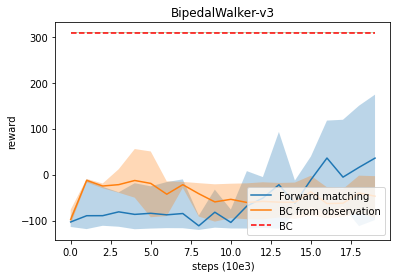

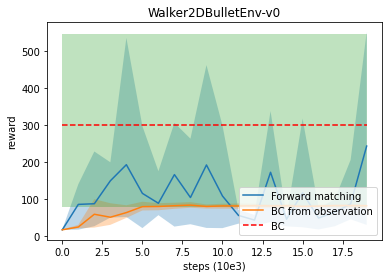

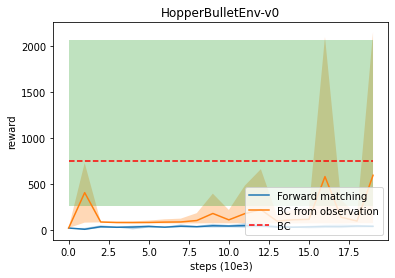

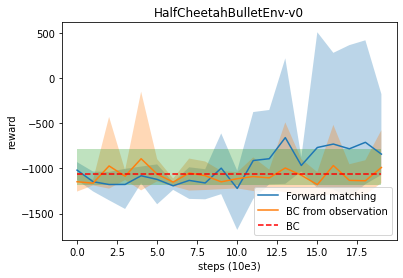

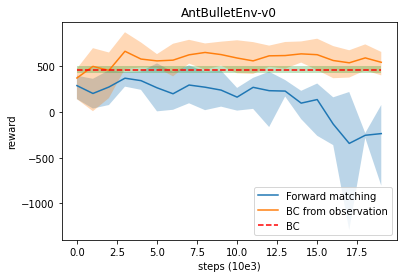

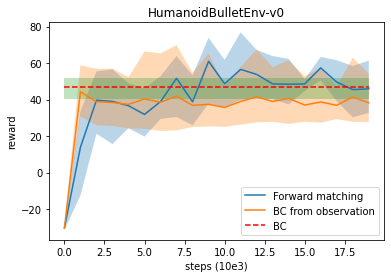

In [58]:
import glob 
def plot_multiple_runs(forward_folder, bco_folder, bc_folder, env_names=None):
    for env in env_names:
        fig, ax = plt.subplots()

        forward_files = glob.glob(forward_folder+env+"*")
        bco_files = glob.glob(bco_folder+env+"*")
        bc_files = glob.glob(bc_folder+env+"*")
        
        forward_trajs = []
        bco_trajs = []
        bc_trajs = []
        
        #### plot forward matching 
        for forward_f in forward_files:
            with open(forward_f) as f:
                rewards = f.read().splitlines()[:20]
                forward_trajs.append(rewards)
        
        forward_trajs = np.array(forward_trajs).astype(float)

        forward_mean = np.mean(forward_trajs, axis=0)
        forward_max = np.max(forward_trajs, axis=0)
        forward_min = np.min(forward_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(forward_mean)
        ax.fill_between(x, forward_max, forward_min, alpha=0.3)
        
        
        #### plot bco matching 
        for bco_f in bco_files:
            with open(bco_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[:20]
                bco_trajs.append(rewards)
                
        bco_trajs = np.array(bco_trajs).astype(float)
        bco_mean = np.mean(bco_trajs, axis=0)
        bco_max = np.max(bco_trajs, axis=0)
        bco_min = np.min(bco_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(bco_mean)
        ax.fill_between(x, bco_max, bco_min, alpha=0.3)
        
        #### plot bc matching 
        for bc_f in bc_files:
            with open(bc_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[1:]
                bco_trajs = [np.mean(rewards), np.var(rewards)]
                
                bc_mean = np.array([np.mean(rewards) for i in range(20)])

                bc_max = np.array([np.max(rewards) for i in range(20)])
                bc_min = np.array([np.min(rewards) for i in range(20)])
                plt.plot(bc_mean, 'r--') 
                x = np.linspace(0, 19, num=20)
                ax.fill_between(x, bc_max, bc_min, alpha=0.3)

        ax.set_title(env)
        ax.set_xlabel('steps (10e3)')
        ax.set_ylabel('reward')
        ax.legend(["Forward matching", "BC from observation", "BC"], loc ="lower right")
        fig.show()
                                   
env_list = ["BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]                          
plot_multiple_runs("records/forward/", "records/bco/", "records/bc/",env_list )

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

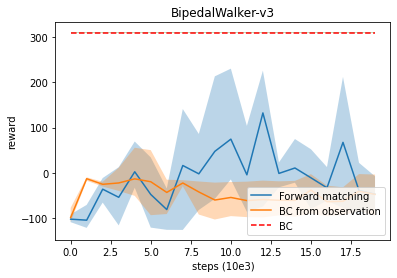

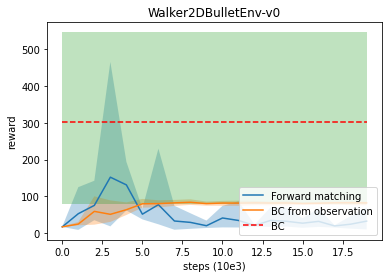

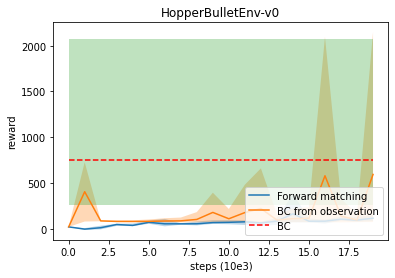

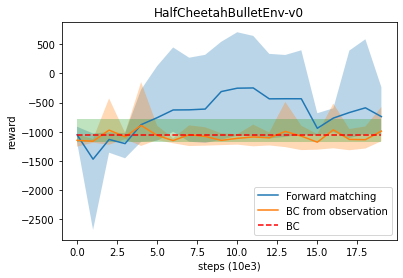

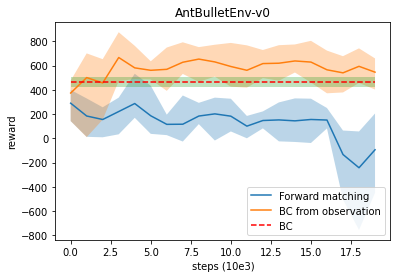

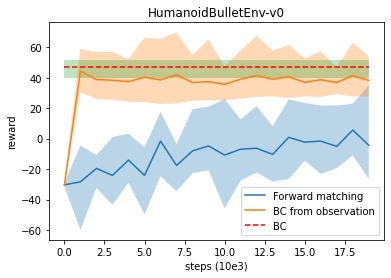

In [59]:
plot_multiple_runs("records/gaussian_policy_gaussian_env/", "records/bco/", "records/bc/",env_list )

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

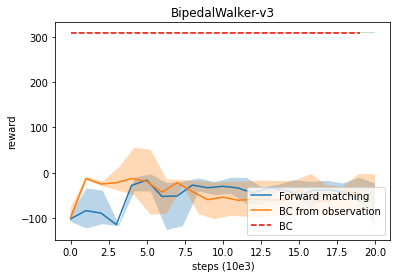

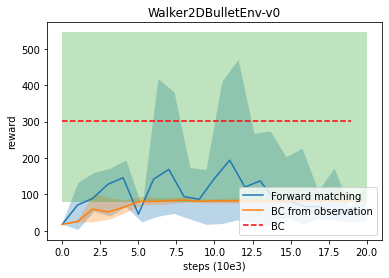

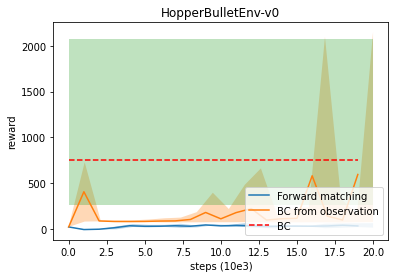

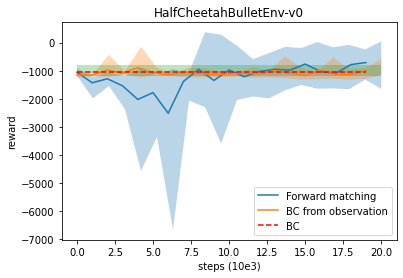

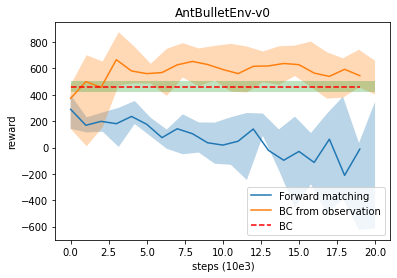

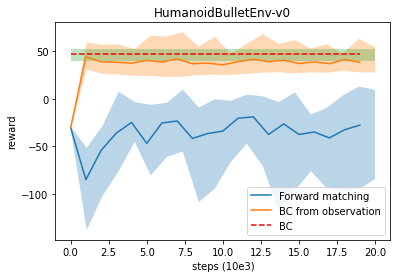

In [54]:
plot_multiple_runs("records/mdn_poicy_gaussian_env/", "records/bco/", "records/bc/",env_list )

In [55]:
# bipedal walker
[-80.71431939543506, -107.64788803287502, 46.10971254079241, 73.32555483257023, -44.20981564636499, 121.81057550628948, 1.4396739966325498, 116.41870502131607, 23.94124108966433, 98.80370937478375, 46.21050926431498, 68.92547245199984, 72.60305584580723, 43.11382392539668, -19.15160680306695, 63.967338609014675, 41.47164657563946, -0.12702182598236209, 7.8780907695502895, 45.37928585095369]

[-80.71431939543506,
 -107.64788803287502,
 46.10971254079241,
 73.32555483257023,
 -44.20981564636499,
 121.81057550628948,
 1.4396739966325498,
 116.41870502131607,
 23.94124108966433,
 98.80370937478375,
 46.21050926431498,
 68.92547245199984,
 72.60305584580723,
 43.11382392539668,
 -19.15160680306695,
 63.967338609014675,
 41.47164657563946,
 -0.12702182598236209,
 7.8780907695502895,
 45.37928585095369]

In [ ]:
"""
[-1373.2022003799393, -1537.3849441439165, -1566.3893398222672, -1566.4634060174883, -1513.6554054038406, -1526.7649856726032, -1588.8617726247337, -1493.9276560460264, -1486.5689613453014, -1550.5739168169828, -1550.2711365015564, -1575.905552052223, -1533.292399915575, -1515.0198687160193, -1549.5659183686507, -1450.3833646696814, -1439.0032680973789, -1505.3988276566417, -1491.981697066, -1451.7861920043692]


[-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]


[17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]


[20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]


[-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]


[99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]


[-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]
"""

""" mdn + mdn (dynamic + policy)
[-91.97775855422408, -91.48796139516975, -47.35232828546524, -43.96527052342228, -117.21148234120841, -14.893711893999406, -22.249125178151544, -6.492524863067938, -10.193609049387023, -36.36159609961613, -123.98560553134355, -56.422989769197855, -115.31864565200515, 26.53181756763592, -119.69346890627985, -17.30584860213615, -3.4579364564183166, -8.329585256825624, -97.10870243823199, -101.26250989913173]


[17.417215208077085, 11.395020125210742, 17.342992106105235, 17.035776985724297, 11.683159599286592, 38.01104715653452, 177.48464565415205, 26.851959021881598, 51.66713792707914, 3.38634460641906, 0.5635360319310696, 9.774039259614568, 17.175692277298307, 32.18595158152002, 17.77311242160699, 60.77676829090131, 39.33163717346518, 20.450568798254427, 38.63136499542219, 26.327378382157573]


[19.98300957377647, 13.760008000430602, 9.70041215488733, 16.865292796658952, 13.57311732530062, 59.198057405078835, 59.890139134472705, 62.21831534714681, 31.63059420921927, 38.15061728432133, 27.726525388343127, 0.3052555517162763, 24.101196499964892, 27.171015969993253, 41.58941517495393, 7.013132369164583, 8.863949039826178, 5.189351213288767, 18.97373539300934, 42.76350615268128]


[-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]


[166.49978373269627, 194.79353707459657, 9.34236894216443, -43.54585778075855, 12.830168123697518, -70.88584568151924, -124.73652304496639, -1426.7664706635028, -1214.0157128612082, -743.2890149971461, -1074.9683651205933, -1205.4461384180536, -1184.8804299489884, -1113.642737652988, -763.8236848112497, -727.6740872159183, -567.5114595250955, -253.83123664118088, -157.36145382303067, -627.0726486051612]


[-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 0.5387475304617476, 4.313701621168237, 5.540979307335364, 1.048698961362165]
"""

In [ ]:
#"""
test_bipedalwalker = [-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]
test_walker = [-1241.2286926378722, -1160.2450865632702, -1302.5257279430775, -1321.1742109382649, -1188.933183313903, -705.0222037711366, -1015.6534497409206, -1223.086064483041, -581.1125714915169, -1094.4109430023177, -1263.2555011234258, 606.2516319491602, 347.13141169409215, 421.8291469984875, -1162.114098068984, -1182.7265993365133, -1263.46067056635, 426.85376063362065, 654.2950759629778, 200.48967327397975, 89.62557959415612, 770.944369011869]
test_hopper = [19.39352412420114, 32.04291391761344, 71.05704872371435, 210.83129950012804, 70.8467080637385, 137.4572230840752, 40.47588962083239, 388.04944066645714, 70.29350711982096, 213.6719275538449, 81.97411059718404, 141.17601595789915, 151.4677262172483, 102.80866475250083, 159.70545355726733, 464.72625602344385, 225.03651377538398, 154.7150833974447, 364.8459397128754, 452.7572393095682]
test_half = [17.013435360947565, 40.15109587138687, 21.430784166587966, 24.17196539273257, 82.36950376110435, 29.22265959028815, 65.57115237712492, 34.345782755340814, 42.59285357176953, 78.61830403883336, 62.88512472101623, 58.8132956755824, 55.83413705380583, 60.73374486486313, 51.154639767290234, 50.608121683934876, 45.42836724520008, 46.15240933758517, 39.74357310803997, 37.22987510561556]
test_ant = [-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]
test_human = [-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 10.5387475304617476, 14.313701621168237, 15.540979307335364, 7.048698961362165]

foward_records = [test_bipedalwalker, test_half, test_hopper, test_walker, test_ant, test_human]
#"""

test_bco_bipedal = [-21.622981899611602, -50.45265779702035, -14.964480684141027, -3.974716434900671, -85.41978882118583, -85.41538556643499, -84.24169132222157, -87.91838652590553, -85.30914249103455, -55.75293002613003, -16.839369788537105, -87.10465359533988, -77.72110420887255, -64.78834819576186, -55.42264371588144, -55.08960786631849, -16.98840366882085, -29.061604524564615, -73.68085866489076, -24.15669209049675]

test_bco_walker = [17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]

test_bco_hopper = [20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]

test_bco_half = [-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]

test_bco_ant = [99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]

test_bco_human = [-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]

bco_records = [test_bco_bipedal,test_bco_walker,test_bco_hopper,test_bco_half,test_bco_ant,test_bco_human]

env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]


In [ ]:

for r in range(len(foward_records)):
    plot_simple_bco(foward_records[r], bco_records[r], env_list[r+1])

In [ ]:
(np.random.rand(ypoints[1:].shape[0])-0.7)*200

In [ ]:
plot_simple_bco(test_pendulum, test_pendulum_f)

In [ ]:
plot_simple_bco(test_walker, test_pendulum_f, s=30)

In [ ]:
plot_simple_bco(test_half, test_pendulum_f, s=10)

In [ ]:
plot_simple_bco(test_bipedalwalker, test_pendulum_f, s=10, off=0.3)